In [38]:
from comet_ml import Experiment
import comet_ml
from comet_ml.integration.pytorch import log_model
from libs import dataloader
import torch
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
import mdmm

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# W bosons regressions with a Transformer

## Dataset Loading

In [2]:
datafolder = "/eos/user/d/dvalsecc/EFT_PhD_Course/training_datasets"

# Usage example
input_paths_training = [ f"{datafolder}/{f}_training.npy" for f in ["jet_data", "jet_padding_mask", "lepton_data", "met_data", "nu_data", "W_data"]]
input_paths_validation = [ f"{datafolder}/{f}_validation.npy" for f in ["jet_data", "jet_padding_mask","lepton_data", "met_data", "nu_data", "W_data"]]

dataset_train = dataloader.ChunkedNumpyDataset(input_paths_training, max_events=1000000, device="cuda")
dataset_val  = dataloader.ChunkedNumpyDataset(input_paths_validation, max_events=500000, device="cuda")

# Create DataLoader
batch_size = 512
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=True)


## Model definition

Let's start defining a basic transformer with encoder and decoder layers.

In [10]:
import torch
import torch.nn as nn
from torch.nn import Transformer, TransformerEncoderLayer, TransformerDecoderLayer

class MaskedTransformer(nn.Module):
    def __init__(self, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward=512):
        super().__init__()
        #https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html#torch.nn.Transformer
        self.transformer = Transformer(d_model=d_model,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       batch_first = True # Inputs will be [batch, sequence, dim]
                                      )

    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        output = self.transformer(src, tgt, 
                                  src_key_padding_mask=src_mask,
                                  tgt_key_padding_mask=tgt_mask)
        return output


Let's pass to the transformer encode the jets and get out from the Transformer decoder 2 objetcs. 

NB: the number of elements in the decoder is not fixed in the definition of the model.

In [5]:
# Example usage
d_model = 5
nhead = 1
num_encoder_layers = 4
num_decoder_layers = 4

model = MaskedTransformer(d_model, nhead, num_encoder_layers, num_decoder_layers)
model.to("cuda")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


MaskedTransformer(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-3): 4 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=5, out_features=5, bias=True)
          )
          (linear1): Linear(in_features=5, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=512, out_features=5, bias=True)
          (norm1): LayerNorm((5,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((5,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((5,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-3): 4 x TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
          

In [6]:
inputs = next(iter(dataloader_train))
jets, jets_mask, lepton, met, nu, W = inputs
tgt = torch.zeros((batch_size, 2, 5), dtype=torch.float32).to("cuda")

W_out = model(jets, tgt, src_mask=jets_mask)
W_out.shape

torch.Size([512, 2, 5])

In [7]:
W_out

tensor([[[ 0.9528,  1.0941,  0.0338, -1.6442, -0.4365],
         [ 1.6635, -0.0082,  0.3260, -0.7044, -1.2769]],

        [[ 1.3977,  0.1294,  0.5803, -1.5397, -0.5677],
         [ 1.5451,  0.5479, -0.0347, -0.7186, -1.3397]],

        [[ 1.5874, -0.0315,  0.5035, -0.8005, -1.2590],
         [ 1.8460, -0.5109,  0.2176, -0.9741, -0.5787]],

        ...,

        [[ 1.1332, -0.6795, -1.4442, -0.0870,  1.0775],
         [ 1.2335, -1.7722, -0.0834,  0.5732,  0.0488]],

        [[ 1.3836, -1.0411, -0.0407, -1.1394,  0.8376],
         [ 1.3730,  0.7305, -0.0695, -1.5210, -0.5129]],

        [[ 1.9051, -0.2597, -0.0919, -0.9865, -0.5670],
         [ 1.8256,  0.2272, -0.4510, -1.0551, -0.5468]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)

Until now our model makes little sense. We are passing the jets to the Transformer encoder, and then passing empty tensors [Batch, 2, 5] to the Transformer decoder. 

The Transformer decoder manipulate the 2 empty tensors (columns) and using information from the encoder, returns them. 

**Problems**: 
- At the moment the transformer dimension is fixed to the dimension of the last axis of the input --> very limited
- The same for the target.

We need more capacity

### Transformer with projections in an embedded space

In [8]:
import torch
import torch.nn as nn
from torch.nn import Transformer, TransformerEncoderLayer, TransformerDecoderLayer

class WWRegressor(nn.Module):
    
    def __init__(self, d_model=128, nhead=8, 
                 num_encoder_layers=2, 
                 num_decoder_layers=2, 
                 dim_feedforward=512,
                 output_dim=4,
                 regression_net=[64,64],
                 jet_features = 5
                ):
        super().__init__()
        self.d_model = d_model
        self.transformer = MaskedTransformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward)

        self.embedding_jets = nn.Sequential(
            nn.Linear(jet_features, d_model),
            nn.ReLU()
        )

        _layers = [nn.Linear(d_model, regression_net[0]), nn.ReLU()]
        for i in range(len(regression_net)-1):
            _layers.append(nn.Linear(regression_net[i], regression_net[i+1]))
            _layers.append(nn.ReLU())
            
        _layers.append(nn.Linear(regression_net[-1], 4))
        self.regression_net = nn.Sequential(*_layers)

    def forward(self, jets, jets_mask):
        emb = self.embedding_jets(jets)
        tgt = torch.zeros((jets.shape[0], 2, self.d_model), dtype=torch.float32).to("cuda")
        out_transf = self.transformer(src=emb, tgt=tgt, src_mask=jets_mask)

        out = self.regression_net(out_transf)
        return out
        

In [9]:
# Example usage
d_model = 64
nhead = 8
num_encoder_layers = 4
num_decoder_layers = 4

model = WWRegressor(d_model, nhead, num_encoder_layers, num_decoder_layers,
                   regression_net=[32,32])
model.to("cuda")

WWRegressor(
  (transformer): MaskedTransformer(
    (transformer): Transformer(
      (encoder): TransformerEncoder(
        (layers): ModuleList(
          (0-3): 4 x TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
            )
            (linear1): Linear(in_features=64, out_features=512, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (linear2): Linear(in_features=512, out_features=64, bias=True)
            (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            (dropout1): Dropout(p=0.1, inplace=False)
            (dropout2): Dropout(p=0.1, inplace=False)
          )
        )
        (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
      (decoder): TransformerDecoder(
        (layers): ModuleList(
          (0-3): 4 x

In [10]:
inputs = next(iter(dataloader_train))
jets, jets_mask, lepton, met, nu, W = inputs
W_out = model(jets, jets_mask)
W_out.shape

torch.Size([512, 2, 4])

In [11]:
W_out

tensor([[[-0.1521,  0.1395,  0.1542,  0.1344],
         [-0.1391,  0.1795,  0.1325,  0.0889]],

        [[-0.1609,  0.1962,  0.0755,  0.0936],
         [-0.0771,  0.1646,  0.0909,  0.0756]],

        [[-0.1285,  0.1372,  0.1536,  0.0411],
         [-0.1214,  0.0821,  0.2436,  0.1409]],

        ...,

        [[-0.0897,  0.1980,  0.0626,  0.0661],
         [-0.1571,  0.1922,  0.1001,  0.0697]],

        [[-0.2079,  0.1236,  0.1565,  0.1516],
         [-0.2232,  0.1717,  0.1229,  0.0542]],

        [[-0.1853,  0.1643,  0.1237,  0.1099],
         [-0.1412,  0.1488,  0.0799,  0.1324]]], device='cuda:0',
       grad_fn=<ViewBackward0>)

The numbers are still nonsense of course, we haven't trained the model. But now the shapes are handled correctly. 
We need now to add also the leptons and met to the inputs. 

### Adding leptons and MET to the inputs
Leptons and MET need a different embedding network to make the dimensions of the input tensors to the transformer the same

In [2]:
datafolder = "/eos/user/d/dvalsecc/EFT_PhD_Course/training_datasets"

# Usage example
input_paths_training = [ f"{datafolder}/{f}_training.npy" for f in ["jet_data", "lepton_data", "met_data","jetlepmet_padding_mask",  "nu_data", "W_data"]]
input_paths_validation = [ f"{datafolder}/{f}_validation.npy" for f in ["jet_data", "lepton_data", "met_data","jetlepmet_padding_mask", "nu_data", "W_data"]]

dataset_train = dataloader.ChunkedNumpyDataset(input_paths_training, max_events=500000, device="cuda")
dataset_val  = dataloader.ChunkedNumpyDataset(input_paths_validation, max_events=200000, device="cuda")

# Create DataLoader
batch_size = 1024
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=False)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size*5, shuffle=False)

In [3]:
import torch
import torch.nn as nn
from torch.nn import Transformer, TransformerEncoderLayer, TransformerDecoderLayer

def get_obj_type_tensor(max_njets):
    o = torch.zeros((max_njets+2+1, 1), dtype=torch.float32)
    o[-3:-1,0] = 1.
    o[-1,0] = -1.
    return o

class WWRegressorComplete(nn.Module):
    
    def __init__(self, d_model=128, nhead=8, 
                 num_encoder_layers=2, 
                 num_decoder_layers=2, 
                 dim_feedforward=512,
                 output_dim=4,
                 regression_net=[64,64],
                 jet_features = 5,
                 let_features = 3, 
                 met_features = 2,
                 max_njets= 13,
                ):
        super().__init__()
        self.d_model = d_model
        self.transformer = MaskedTransformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward)

        self.embedding_jets = nn.Sequential(
            nn.Linear(jet_features, d_model-1), # -1 to account for the additional label added to the features
            nn.SELU()
        )
        self.embedding_lep = nn.Sequential(
            nn.Linear(let_features, d_model-1),
            nn.SELU()
        )
        self.embedding_met = nn.Sequential(
            nn.Linear(met_features, d_model-1),
            nn.SELU()
        )
        
        _layers = [nn.Linear(d_model, regression_net[0]), nn.SELU()]
        for i in range(len(regression_net)-1):
            _layers.append(nn.Linear(regression_net[i], regression_net[i+1]))
            _layers.append(nn.SELU())
            
        _layers.append(nn.Linear(regression_net[-1], output_dim))
        self.regression_net = nn.Sequential(*_layers)

        self.register_buffer('obj_type', get_obj_type_tensor(max_njets))
        self.register_buffer("decoder_null_tokens", torch.zeros((2, self.d_model), dtype=torch.float32))
        

    def forward(self, jets, leptons, met, full_mask):
        batch_size = jets.size(0)
        emb_jets = self.embedding_jets(jets)
        emb_lep = self.embedding_lep(leptons)
        emb_met = self.embedding_met(met)

        labels = self.obj_type.expand(batch_size, *list(self.obj_type.shape))
        
        emb = torch.cat([emb_jets, emb_lep, emb_met], dim=1)
        emb = torch.cat([emb, labels], dim=-1)

        # expanding the mask for lepton and met
        
        tgt = self.decoder_null_tokens.expand(batch_size, *list(self.decoder_null_tokens.shape))
        out_transf = self.transformer(src=emb, tgt=tgt, src_mask=full_mask)

        out = self.regression_net(out_transf)
        return out
        

In [4]:
# Example usage
d_model = 64
nhead = 4
num_encoder_layers = 2
num_decoder_layers = 2

model = WWRegressorComplete(d_model, nhead, num_encoder_layers, num_decoder_layers,
                   regression_net=[32,32])
model.to("cuda")

NameError: name 'MaskedTransformer' is not defined

In [8]:
inputs = next(iter(dataloader_train))
jets, lepton, met, full_mask, nu, W = inputs
W_out = model(jets, lepton, met, full_mask)
W_out.shape

torch.Size([1024, 2, 4])

## Training Loop

In [5]:
datafolder = "/eos/user/d/dvalsecc/EFT_PhD_Course/training_datasets"

# Usage example
input_paths_training = [ f"{datafolder}/{f}_training.npy" for f in ["jet_data", "lepton_data", "met_data","jetlepmet_padding_mask",  "nu_data", "W_data"]]
input_paths_validation = [ f"{datafolder}/{f}_validation.npy" for f in ["jet_data", "lepton_data", "met_data","jetlepmet_padding_mask", "nu_data", "W_data"]]

dataset_train = dataloader.ChunkedNumpyDataset(input_paths_training, max_events=400000, device="cuda")
dataset_val  = dataloader.ChunkedNumpyDataset(input_paths_validation, max_events=200000, device="cuda")

# Create DataLoader
batch_size = 1024
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=False)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size*5, shuffle=False)

Let's have a function plotting some validation plots for the regressed Ws

In [13]:
def validation_plots(W, W_out):
    f1 , axs = plt.subplots(2, 4, figsize=(16, 10))
    for i in range(2):
        for j in range(4):
            f = plt
            axs[i][j].hist2d(W[:,i, j].cpu().numpy(), W_out[:,i, j].cpu().numpy(),
              bins=60, range=((-3,3),(-3,3)),
            norm=LogNorm())
            if j == 0:
                axs[i][j].set_xlabel("Target pt")
                axs[i][j].set_ylabel("Regressed pt")
            elif j == 1:
                axs[i][j].set_xlabel("Target eta")
                axs[i][j].set_ylabel("Regressed eta")
            elif j == 2:
                axs[i][j].set_xlabel("Target phi")
                axs[i][j].set_ylabel("Regressed phi")
            elif j == 3:
                axs[i][j].set_xlabel("Target mass")
                axs[i][j].set_ylabel("Regressed mass")

    f2 , axs = plt.subplots(2, 4, figsize=(16, 10))
    for i in range(2):
        for j in range(4):
            f = plt
            axs[i][j].hist(W[:,i, j].cpu().numpy(), bins=80, range=(-3,3), label="Target", histtype="step")
            axs[i][j].hist(W_out[:,i, j].cpu().numpy(), bins=80, range=(-3,3), label="Regressed", histtype="step")
            axs[i][j].legend()
            if j == 0:
                axs[i][j].set_xlabel("pt")
            elif j == 1:
                axs[i][j].set_xlabel("eta")
            elif j == 2:
                axs[i][j].set_xlabel("phi")
            elif j == 3:
                axs[i][j].set_xlabel("mass")

    f3 , axs = plt.subplots(1, 4, figsize=(16, 5))
    for j in range(4):
        axs[j].hist2d(W_out[:,0, j].cpu().numpy()-W[:,0,j].cpu().numpy(),
                      W_out[:,1, j].cpu().numpy()-W[:,1,j].cpu().numpy(),
                    bins=80, range=((-2,2),(-2,2)), 
                    norm=LogNorm())
        if j == 0:
            axs[j].set_xlabel("Delta pt W1")
            axs[j].set_ylabel("Delta pt W2")
        elif j == 1:
            axs[j].set_xlabel("Delta eta W1")
            axs[j].set_ylabel("Delta eta W2")
        elif j == 2:
            axs[j].set_xlabel("Delta phi W1")
            axs[j].set_ylabel("Delta phi W1")
        elif j == 3:
            axs[j].set_xlabel("Delta mass W1")
            axs[j].set_ylabel("Delta mass W2")

    return f1,f2, f3

In [8]:
def train(model, device, loader, val_loader,  optimizer, criterion, epochs, experiment=None):
    model.train()
    for epoch in range(epochs):
        model.train()
        for batch_idx, (jets, lepton, met, full_mask, nu, W) in enumerate(loader):
            
            optimizer.zero_grad()
            W_out = model(jets, lepton, met, full_mask)
            
            loss = criterion(W_out, W).mean()
            if batch_idx % 100 == 0:
                print(f"epoch {epoch}, step {batch_idx}, Loss: {loss}")
                if exp:
                   experiment.log_metric("train_loss_step", loss.item(), step=batch_idx)
            loss.backward()
            optimizer.step()
        # Log metrics
        if experiment:
            experiment.log_metric("train_loss_epoch", loss.item(), step=epoch)
        
        # Validation loss
        #model.eval()
        val_loss = 0.  
        with torch.no_grad():
            for jets_val, lepton_val, met_val ,full_mask_val, nu_val, W_val in val_loader:
                W_out_val = model(jets_val, lepton_val, met_val,full_mask_val)
                loss = criterion(W_out_val, W_val)
                val_loss += loss.nanmean().item()

            _ = validation_plots(W_val, W_out_val)
            plt.show()
            
            val_loss = val_loss / len(val_loader)
            
            if experiment:
                experiment.log_metric("val_loss_epoch", val_loss.item(), step=epoch)
            print(f"epoch {epoch}, validation loss: {val_loss}")
        
        print("End of epoch")
    return model

In [116]:
comet_token = open("comet_token.txt").read()
comet_ml.login(api_key=comet_token)


COMET INFO: Valid Comet API Key saved in /afs/cern.ch/user/d/dvalsecc/.comet.config (set COMET_CONFIG to change where it is saved).


Model with 160359 parameters
epoch 0, step 0, Loss: 1.2387480735778809
epoch 0, step 100, Loss: 0.8249739408493042
epoch 0, step 200, Loss: 0.7704488039016724
epoch 0, step 300, Loss: 0.8145601749420166
epoch 0, step 400, Loss: 0.767666220664978


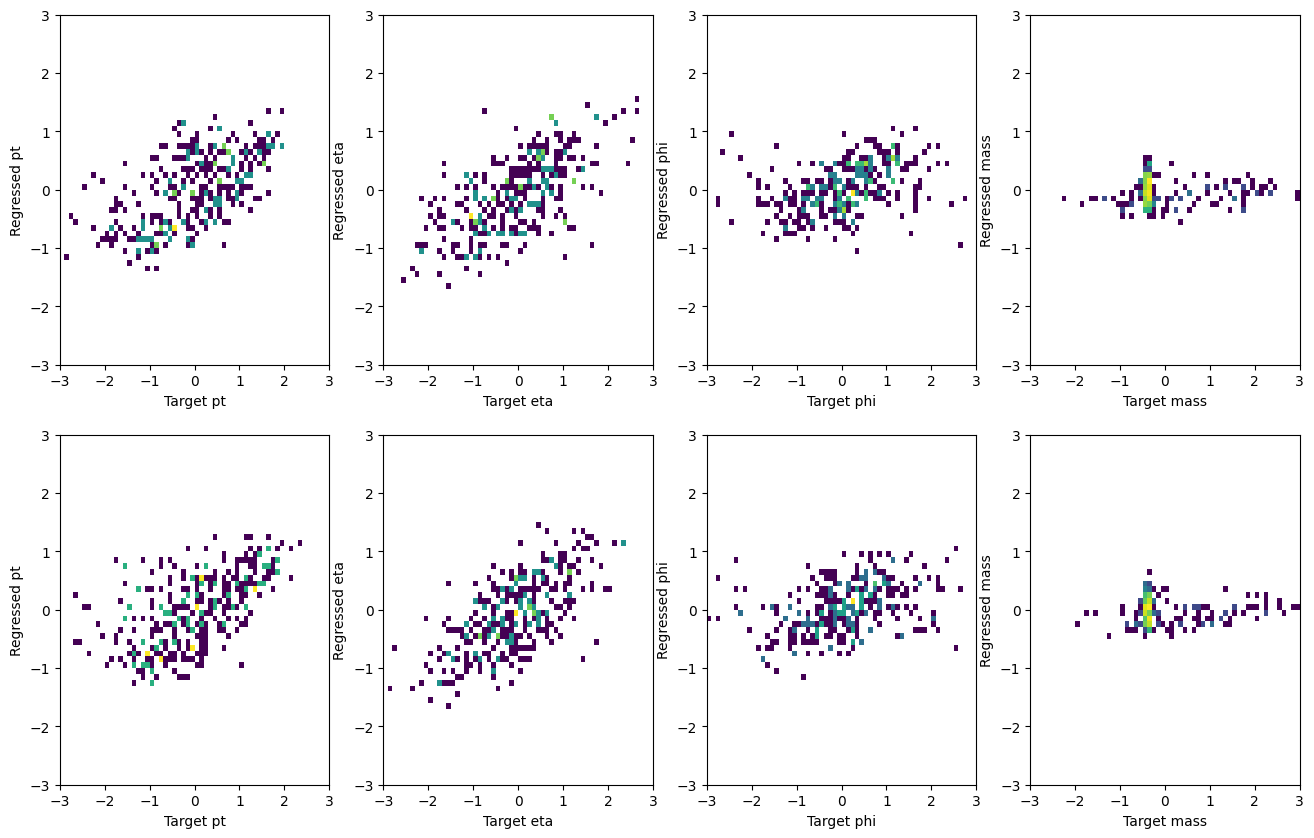

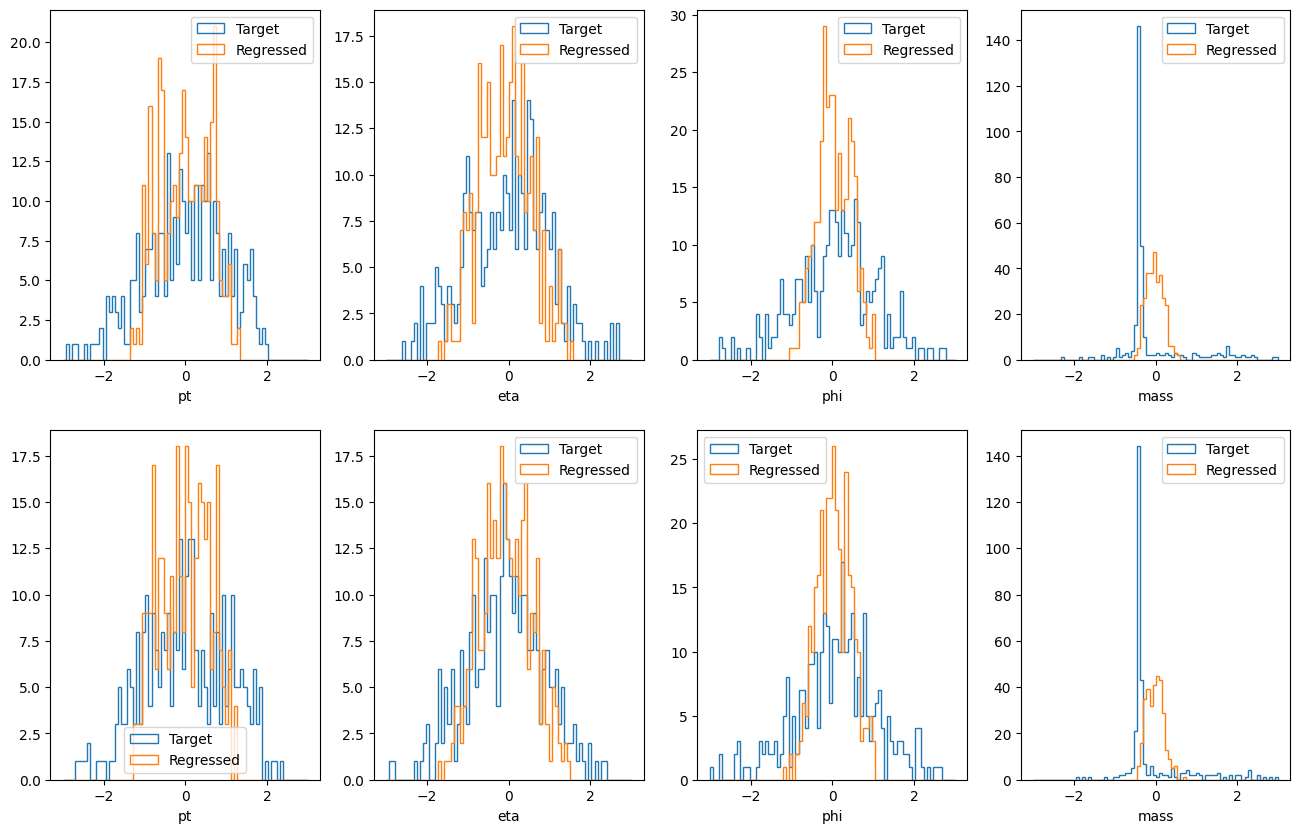

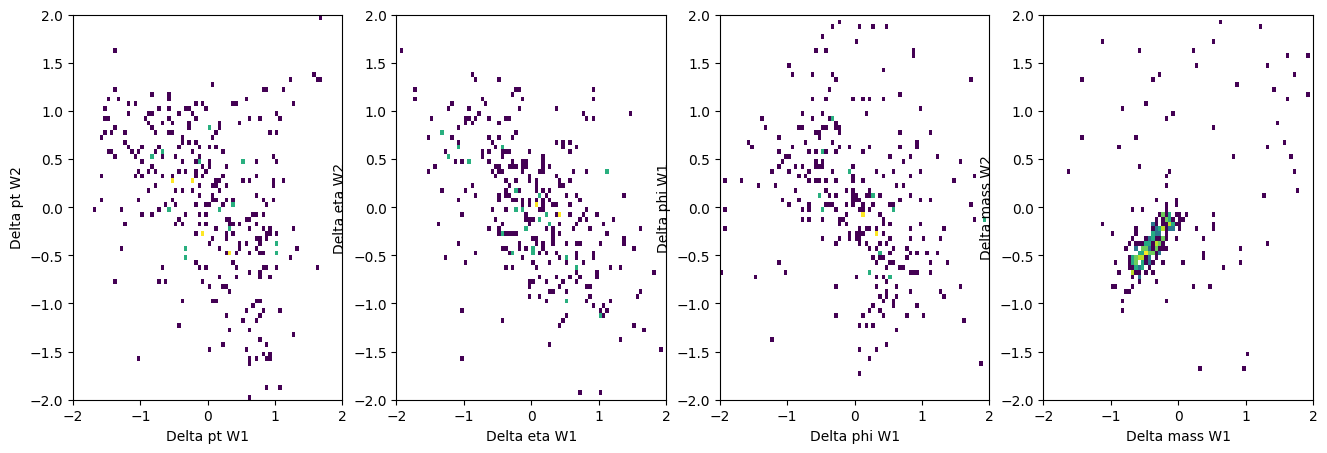

epoch 0, validation loss: 0.7622907400131226
End of epoch
epoch 1, step 0, Loss: 0.7471094727516174
epoch 1, step 100, Loss: 0.7699037790298462
epoch 1, step 200, Loss: 0.7366201281547546
epoch 1, step 300, Loss: 0.797472357749939
epoch 1, step 400, Loss: 0.7542062997817993


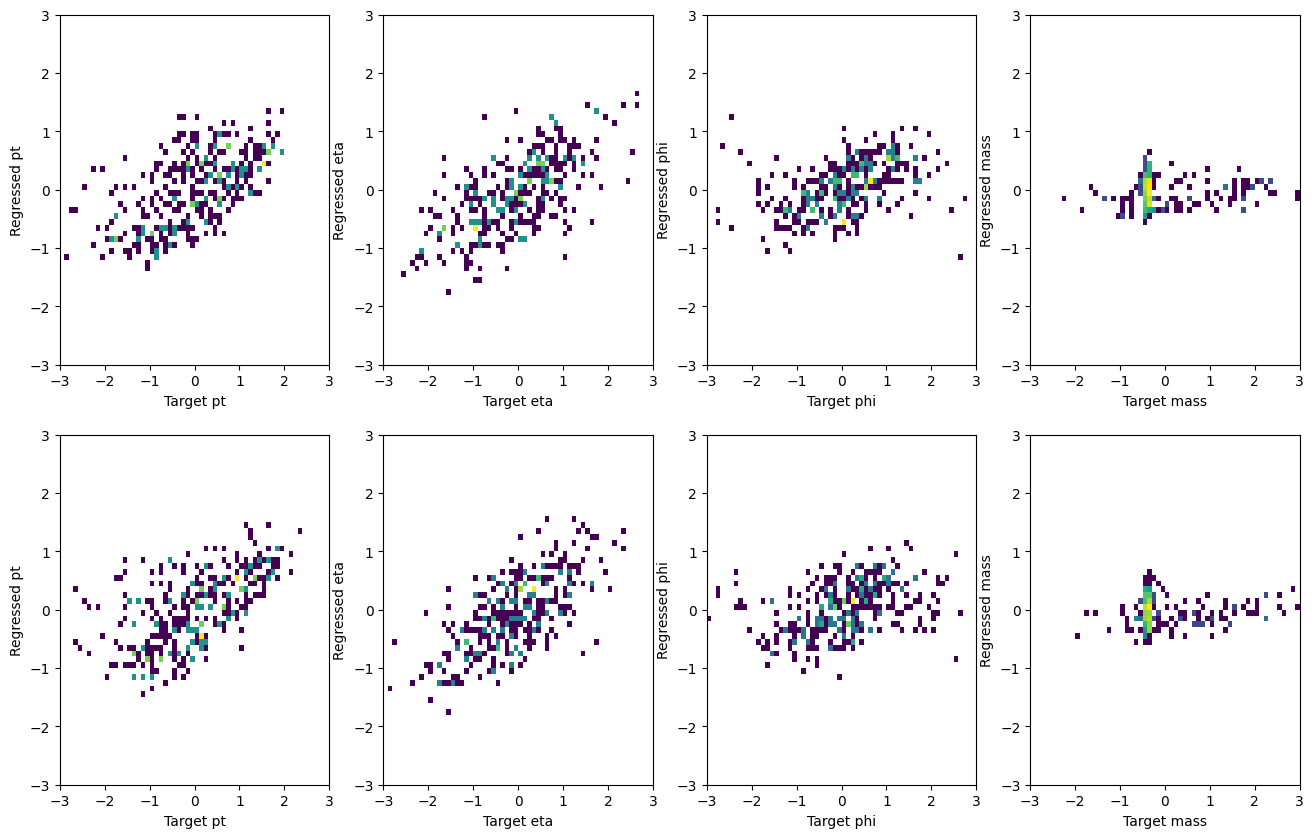

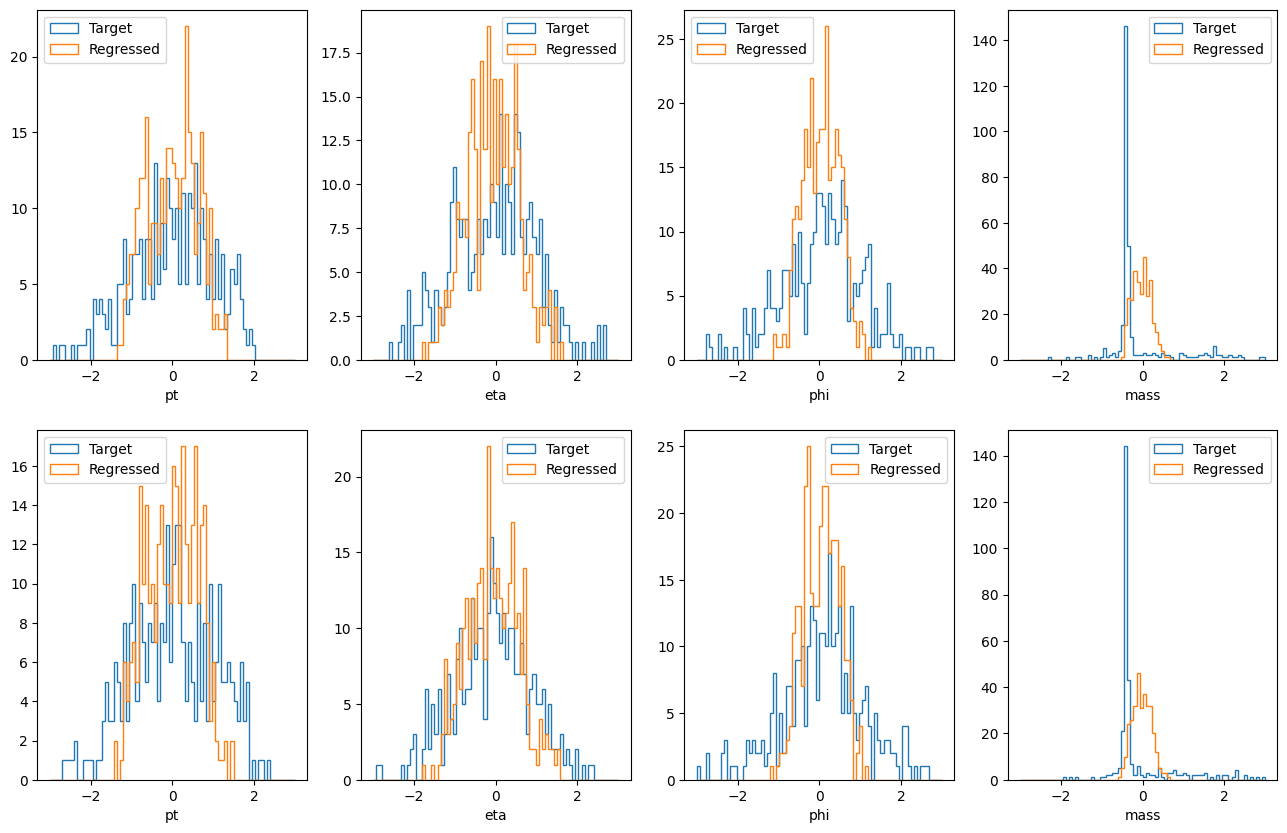

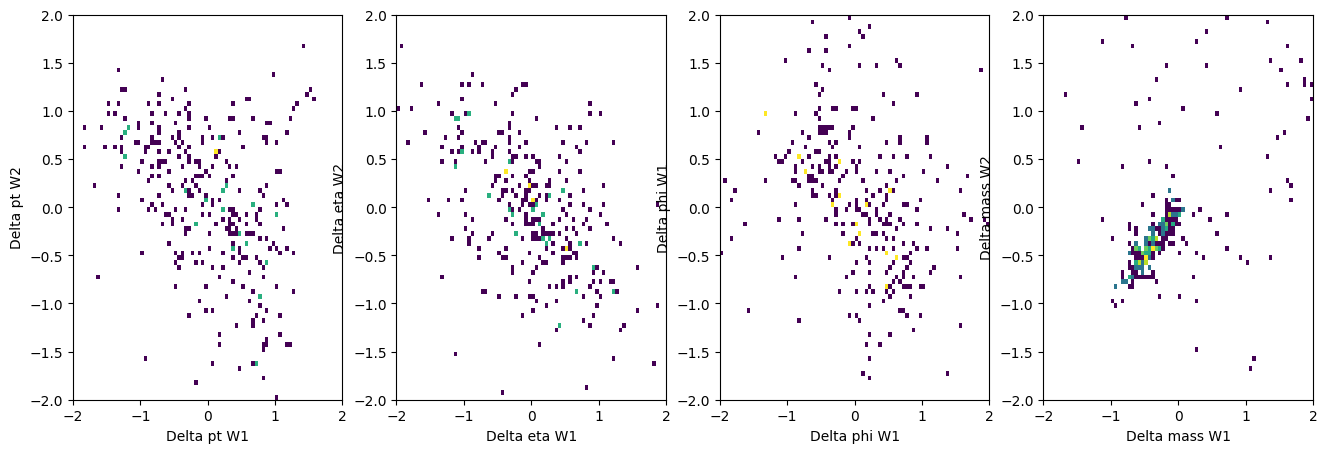

epoch 1, validation loss: 0.7513888791203499
End of epoch
epoch 2, step 0, Loss: 0.7391846179962158
epoch 2, step 100, Loss: 0.7587633728981018
epoch 2, step 200, Loss: 0.7299572825431824
epoch 2, step 300, Loss: 0.7958773374557495
epoch 2, step 400, Loss: 0.7492348551750183


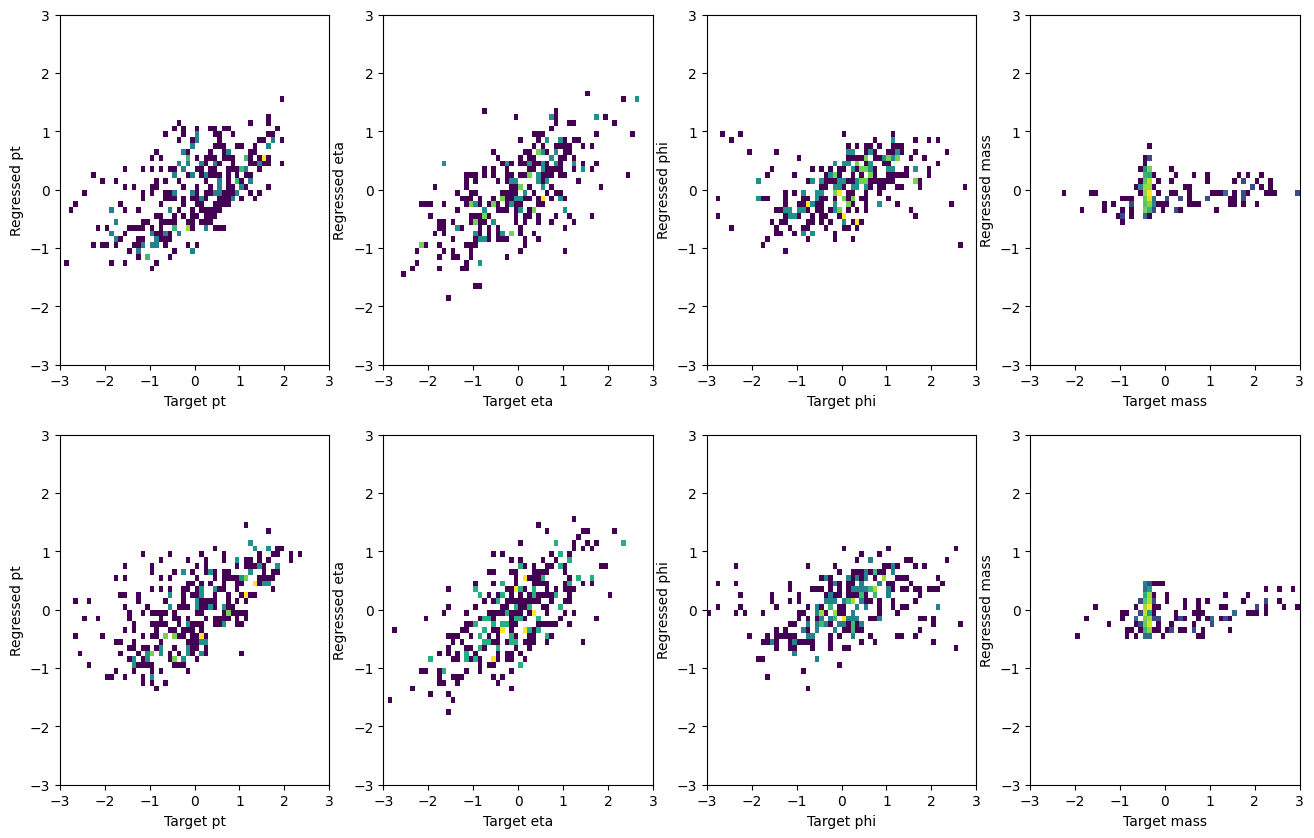

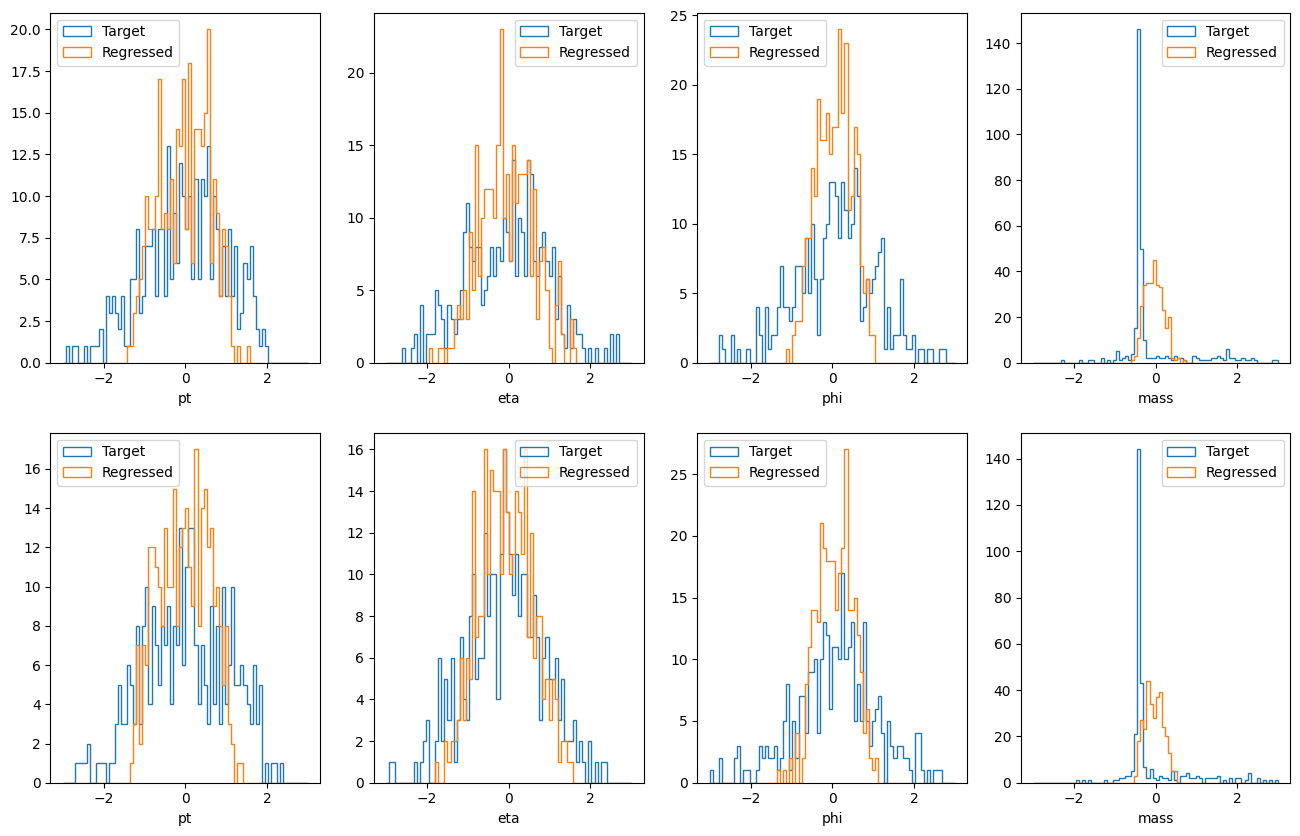

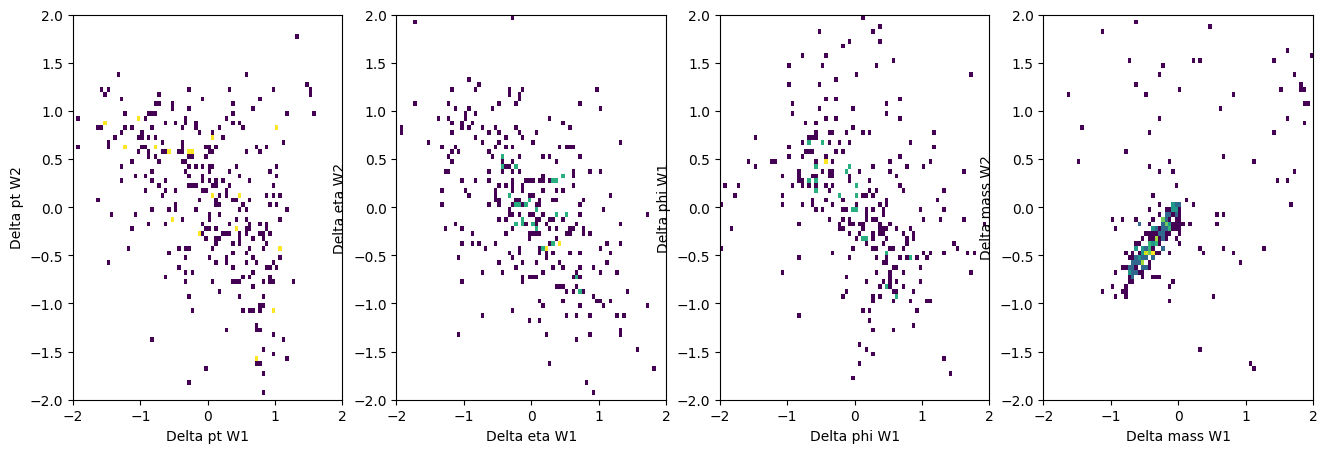

epoch 2, validation loss: 0.7466804832220078
End of epoch
epoch 3, step 0, Loss: 0.7310185432434082
epoch 3, step 100, Loss: 0.7553145289421082
epoch 3, step 200, Loss: 0.7254079580307007
epoch 3, step 300, Loss: 0.786575198173523
epoch 3, step 400, Loss: 0.7441049218177795


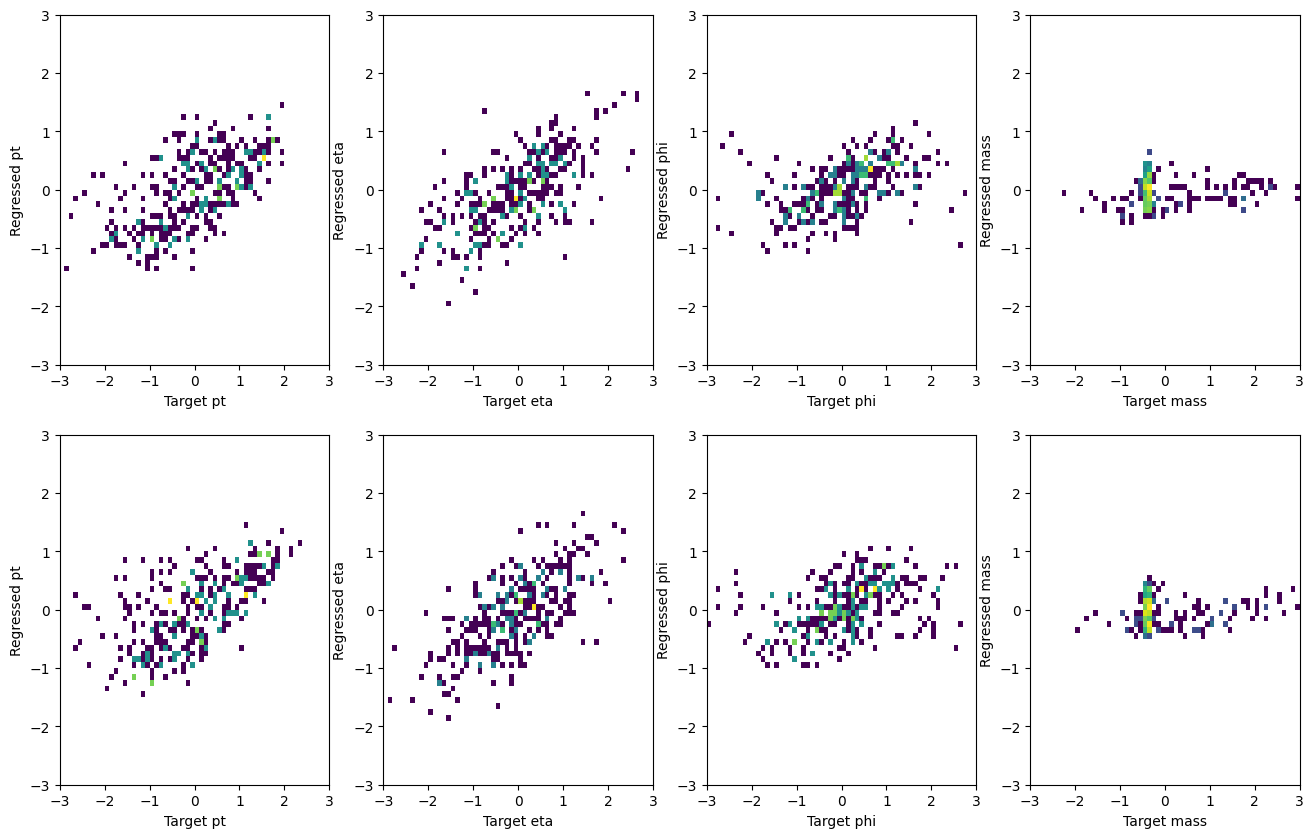

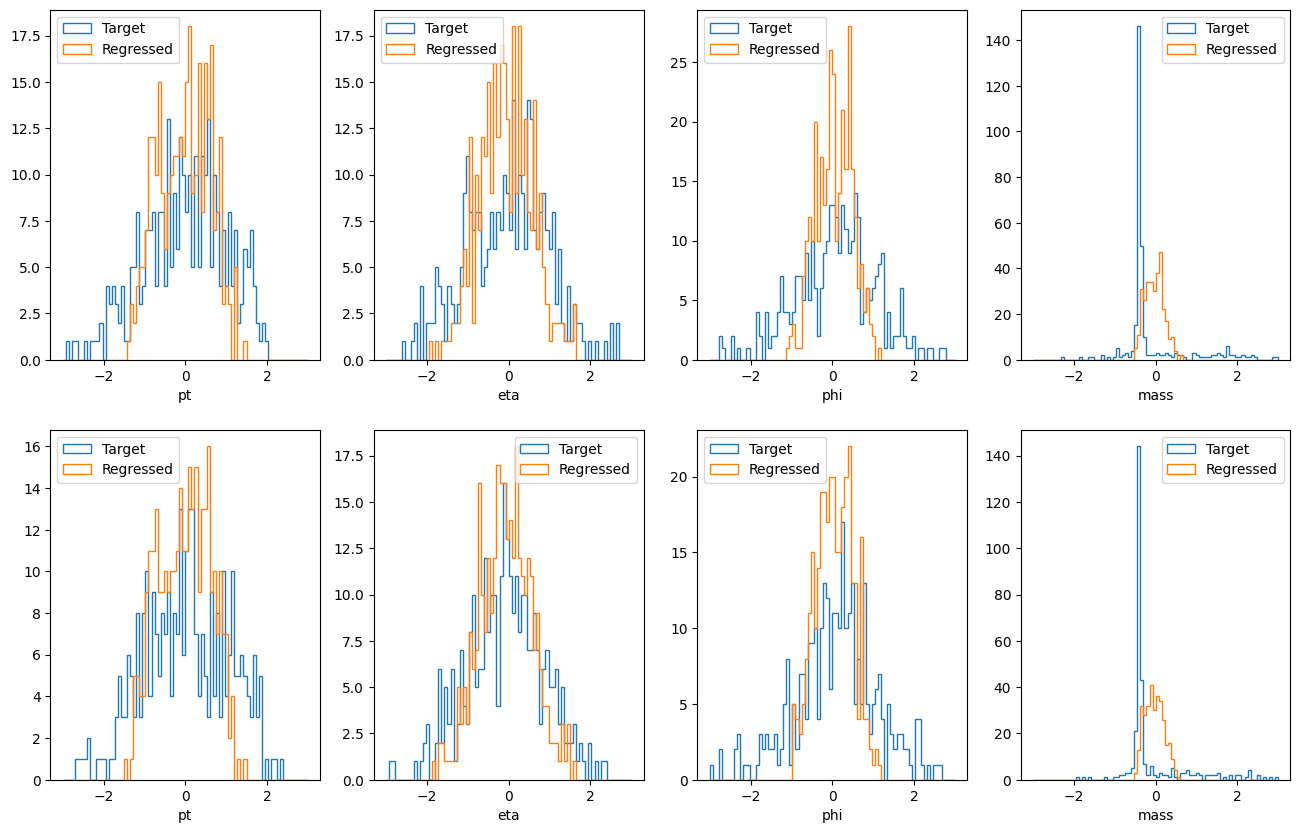

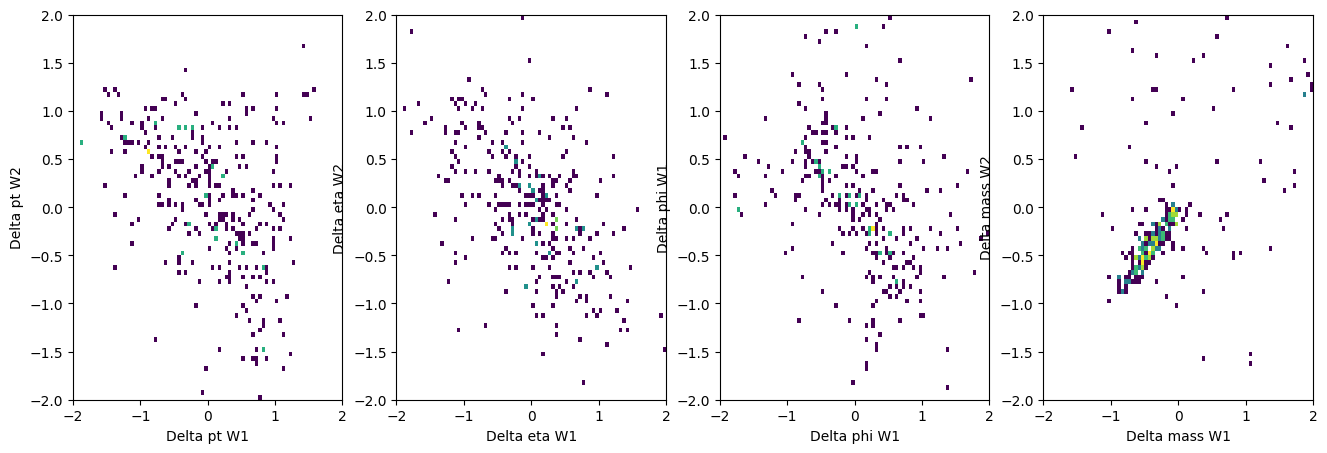

epoch 3, validation loss: 0.7437488168478013
End of epoch
epoch 4, step 0, Loss: 0.7292577028274536
epoch 4, step 100, Loss: 0.750279426574707
epoch 4, step 200, Loss: 0.7263621687889099
epoch 4, step 300, Loss: 0.7862496376037598
epoch 4, step 400, Loss: 0.7478222846984863


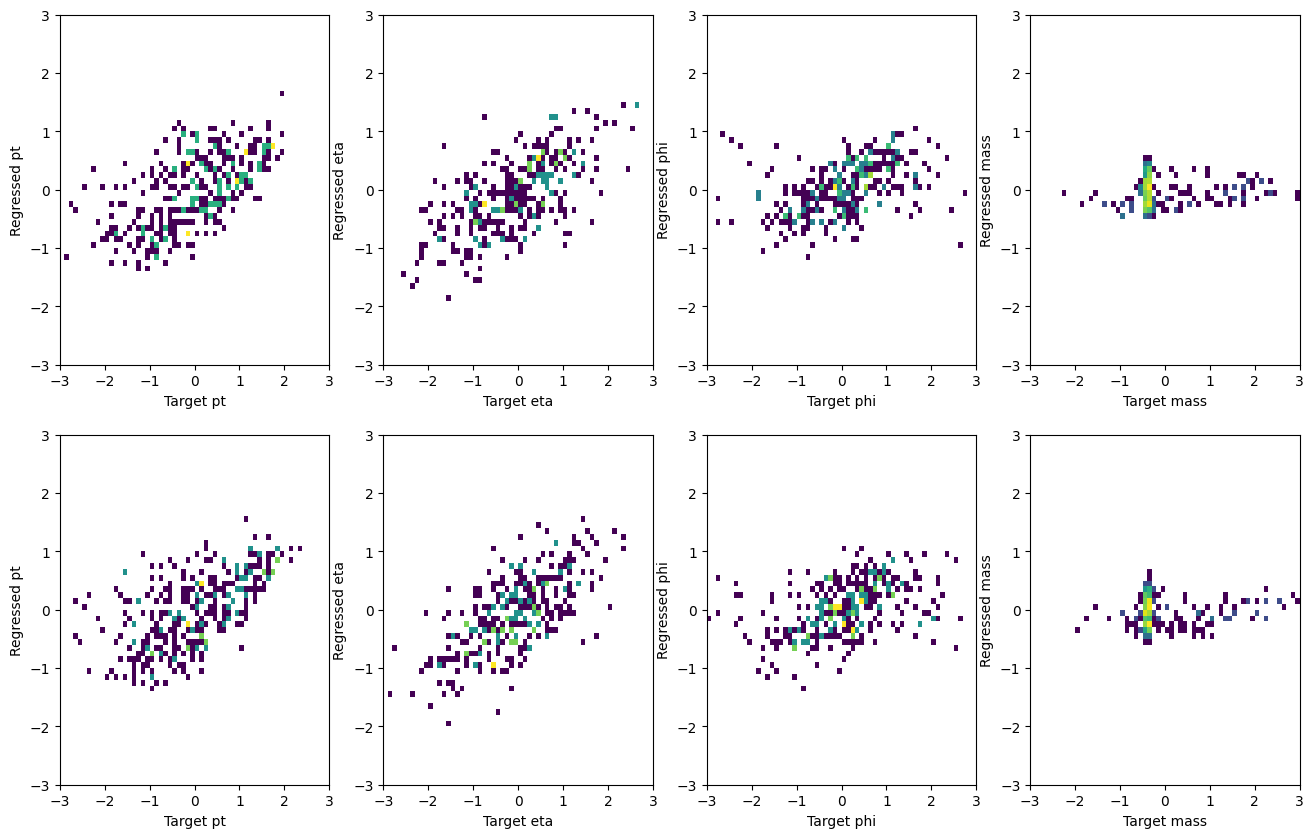

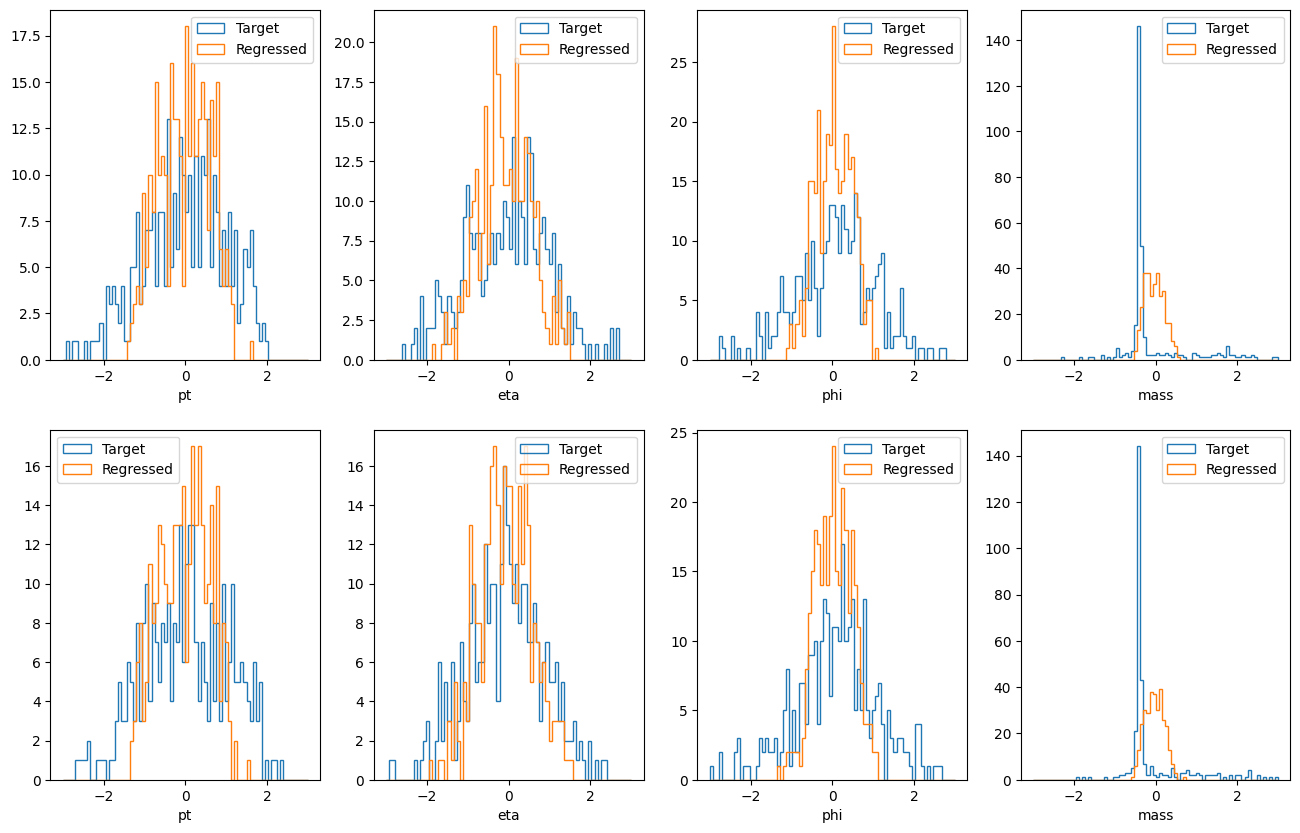

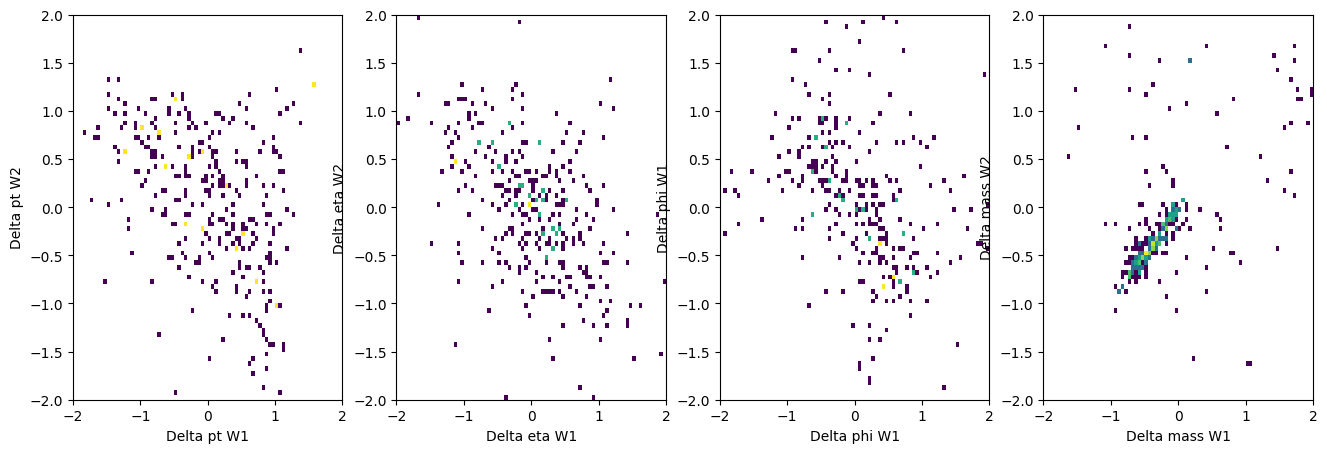

epoch 4, validation loss: 0.7417986392974854
End of epoch
epoch 5, step 0, Loss: 0.7265141010284424
epoch 5, step 100, Loss: 0.7465047836303711
epoch 5, step 200, Loss: 0.7203946709632874
epoch 5, step 300, Loss: 0.7829704284667969
epoch 5, step 400, Loss: 0.7409535646438599


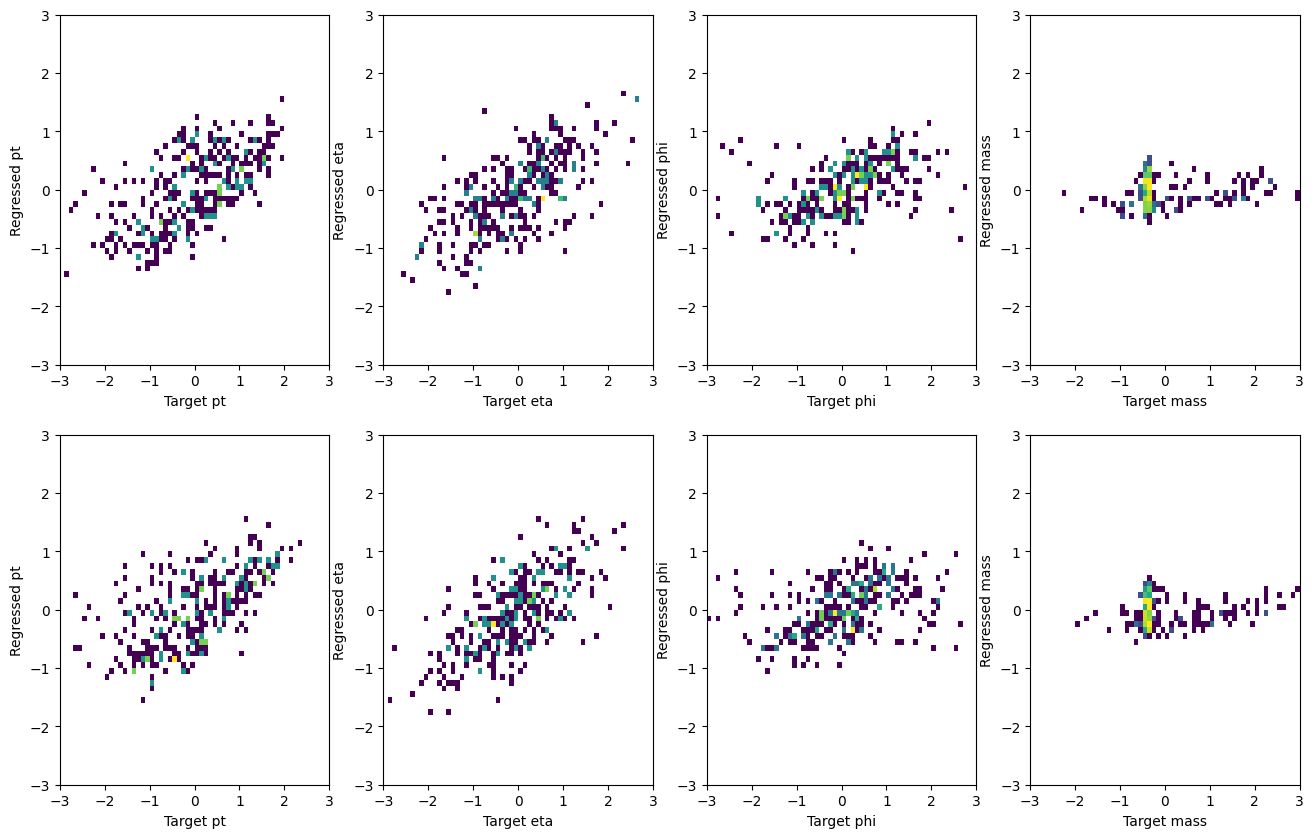

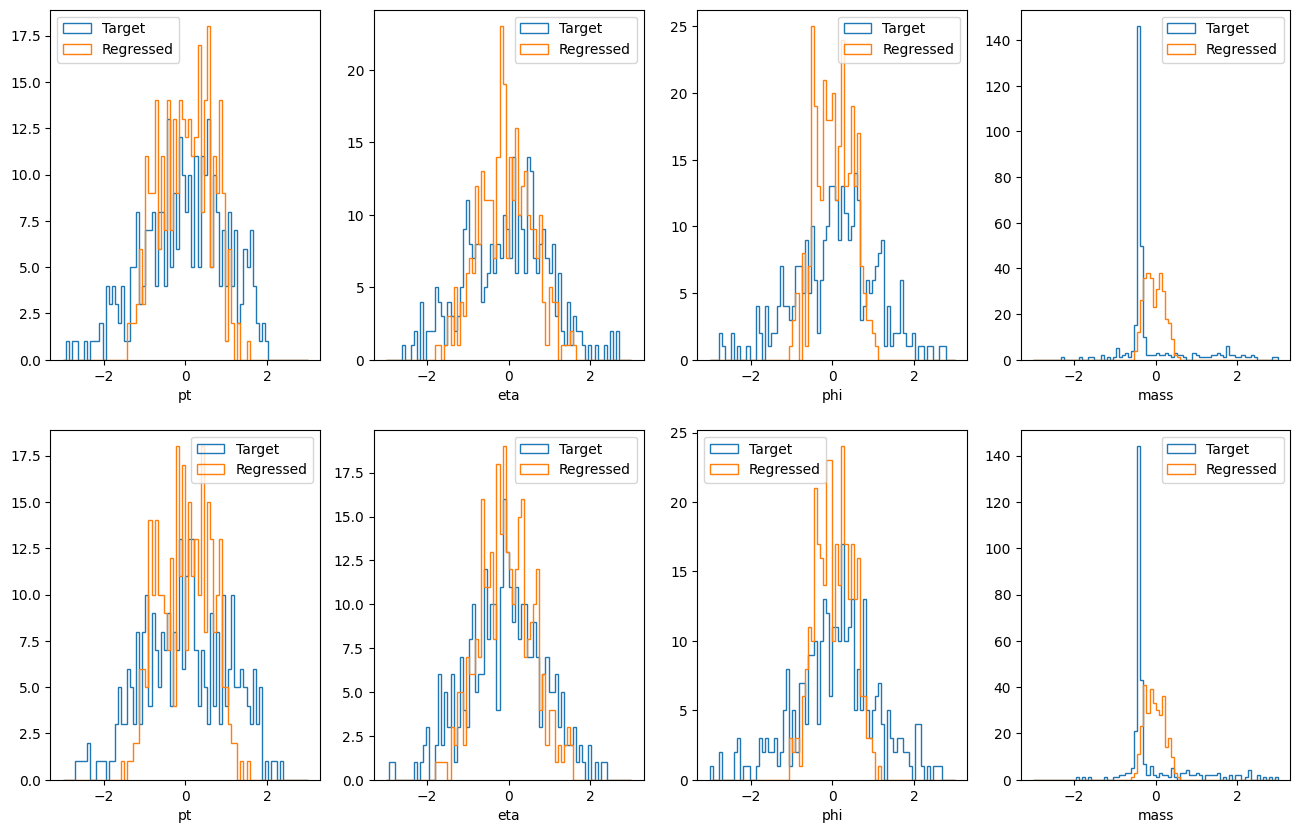

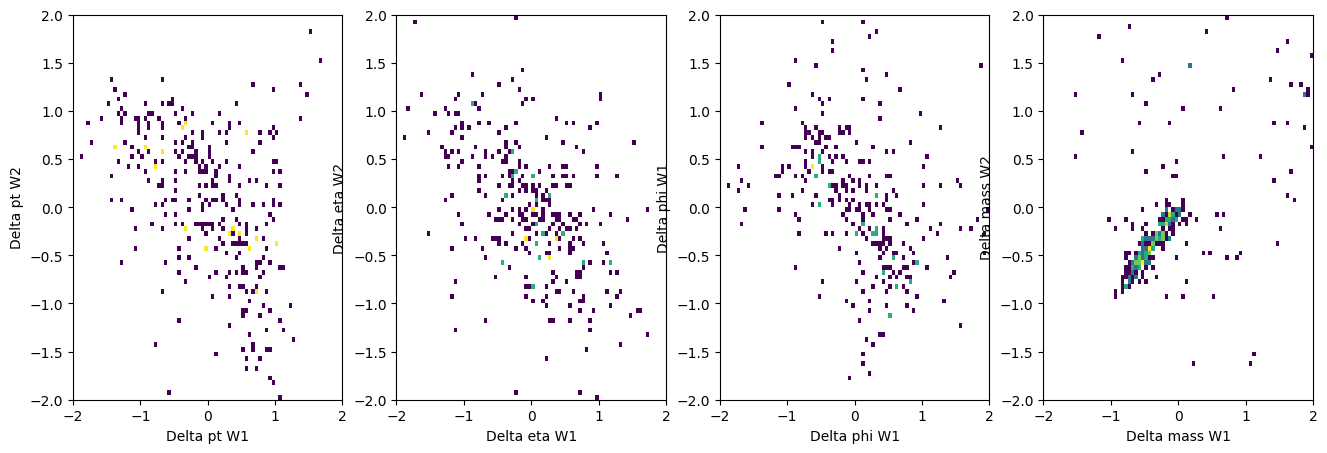

epoch 5, validation loss: 0.7402564451098442
End of epoch
epoch 6, step 0, Loss: 0.7248624563217163
epoch 6, step 100, Loss: 0.7477060556411743
epoch 6, step 200, Loss: 0.7216111421585083
epoch 6, step 300, Loss: 0.7799398899078369
epoch 6, step 400, Loss: 0.7433578372001648


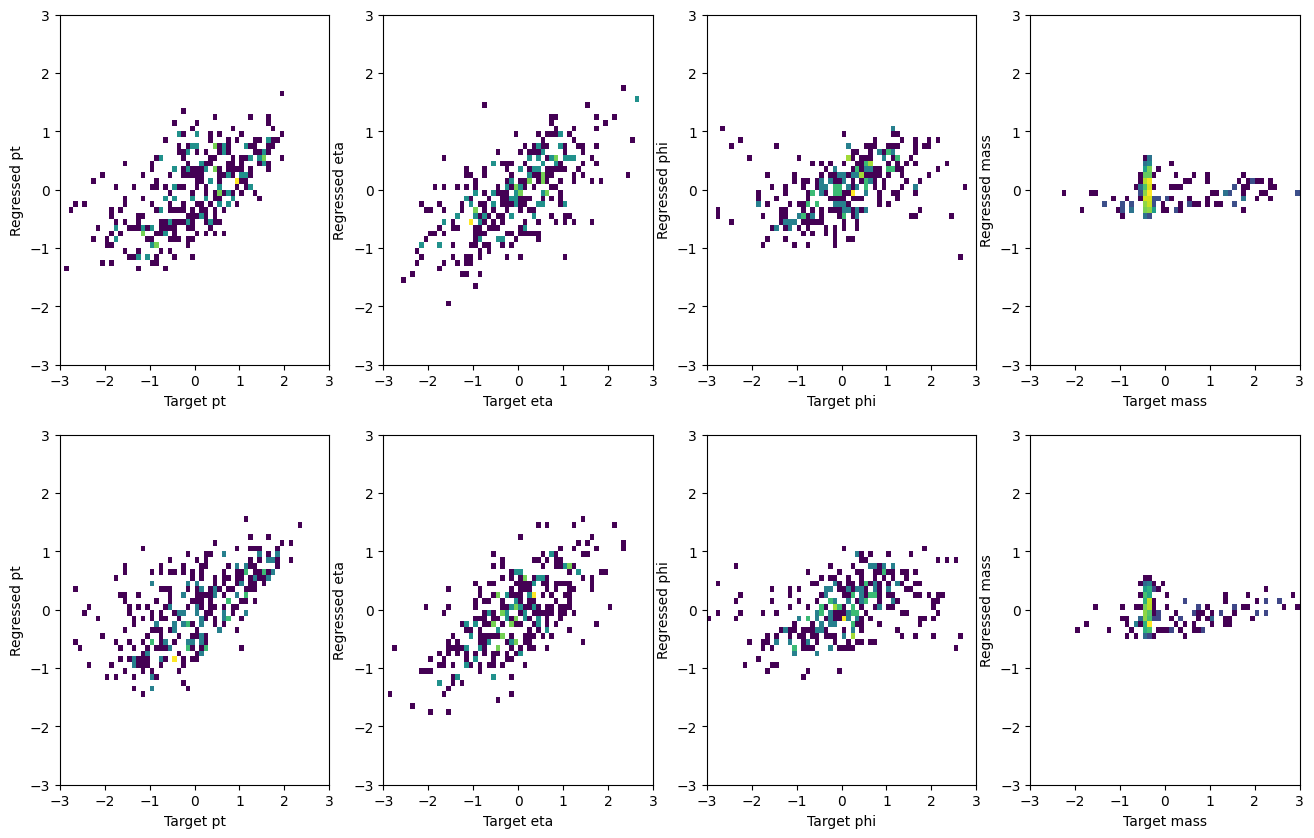

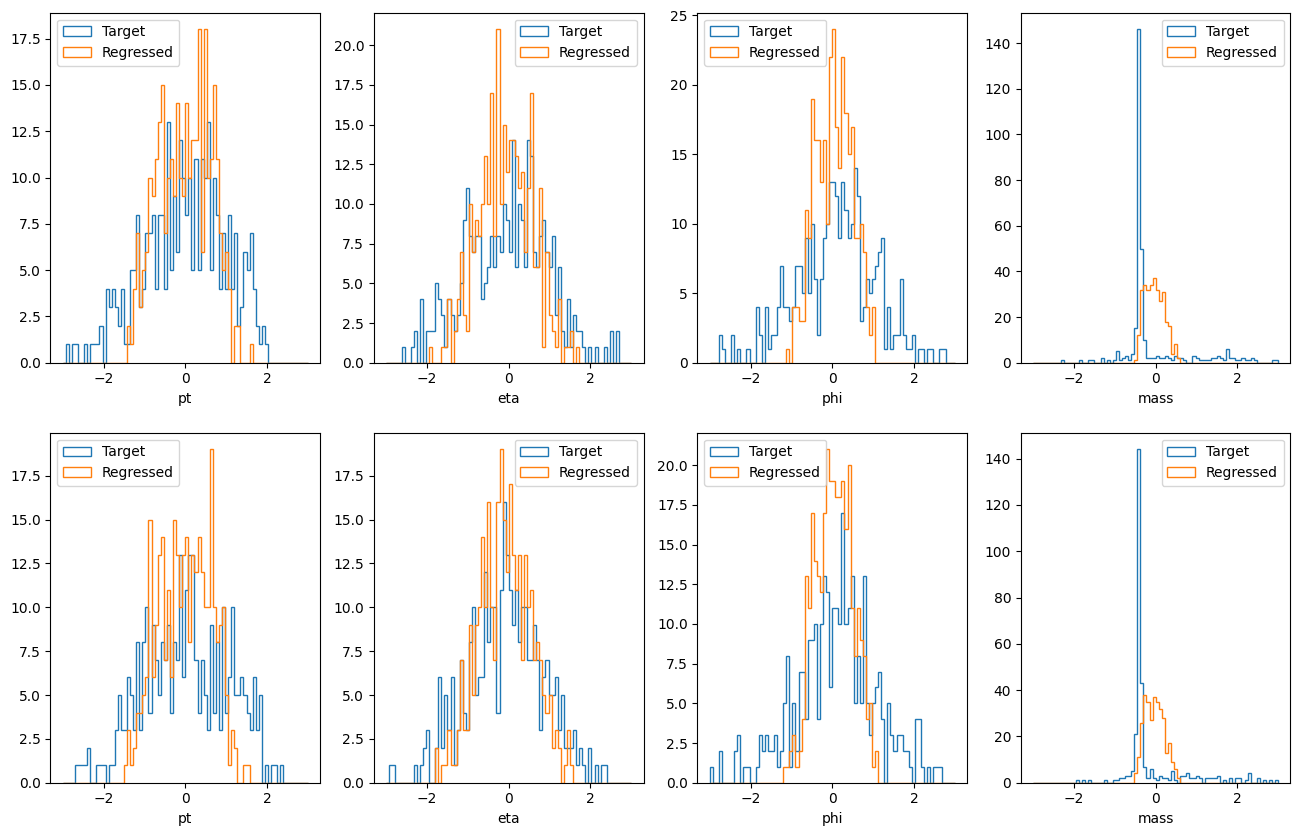

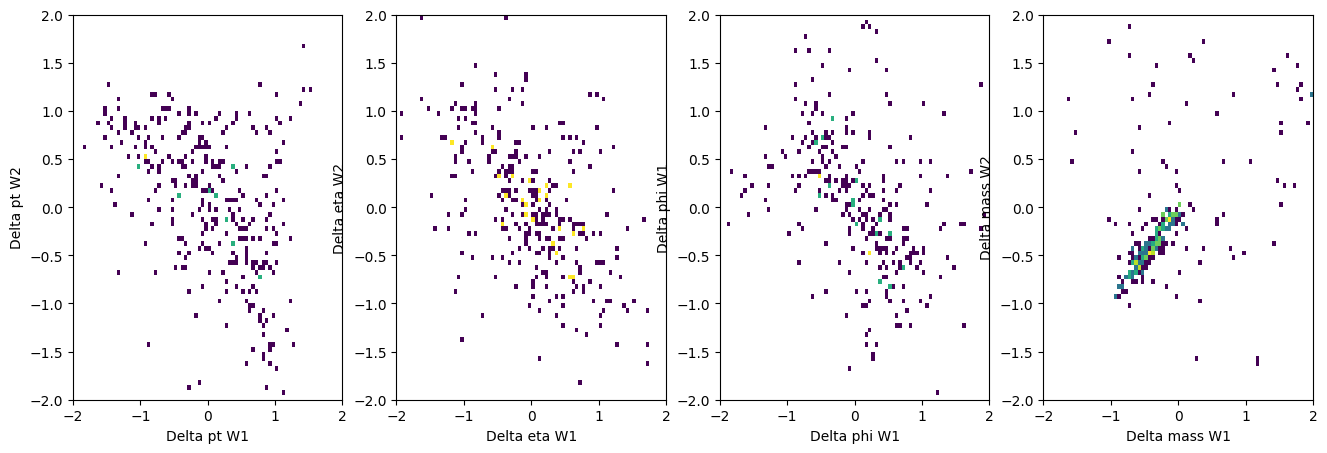

epoch 6, validation loss: 0.7394515708088875
End of epoch
epoch 7, step 0, Loss: 0.7267739772796631
epoch 7, step 100, Loss: 0.7452336549758911
epoch 7, step 200, Loss: 0.7177525162696838
epoch 7, step 300, Loss: 0.7778132557868958
epoch 7, step 400, Loss: 0.7401158213615417


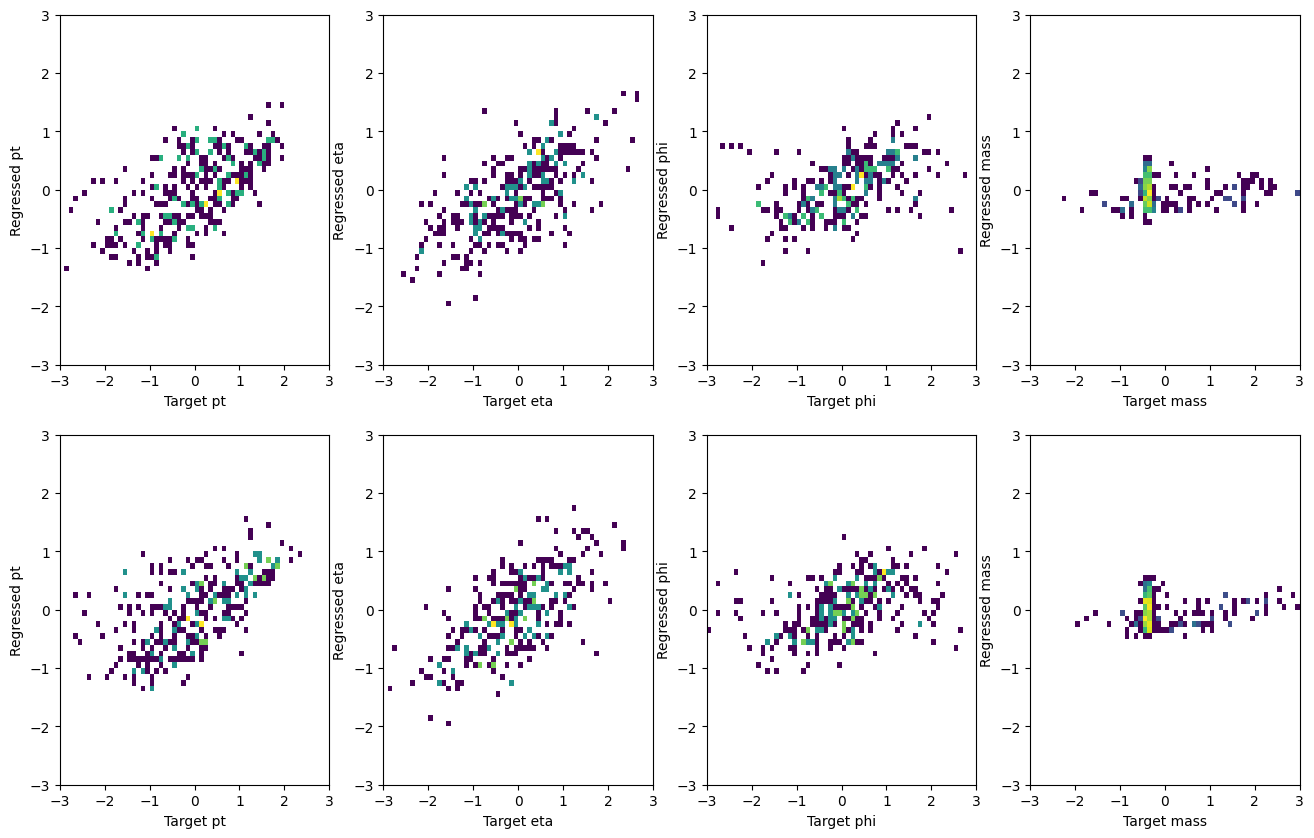

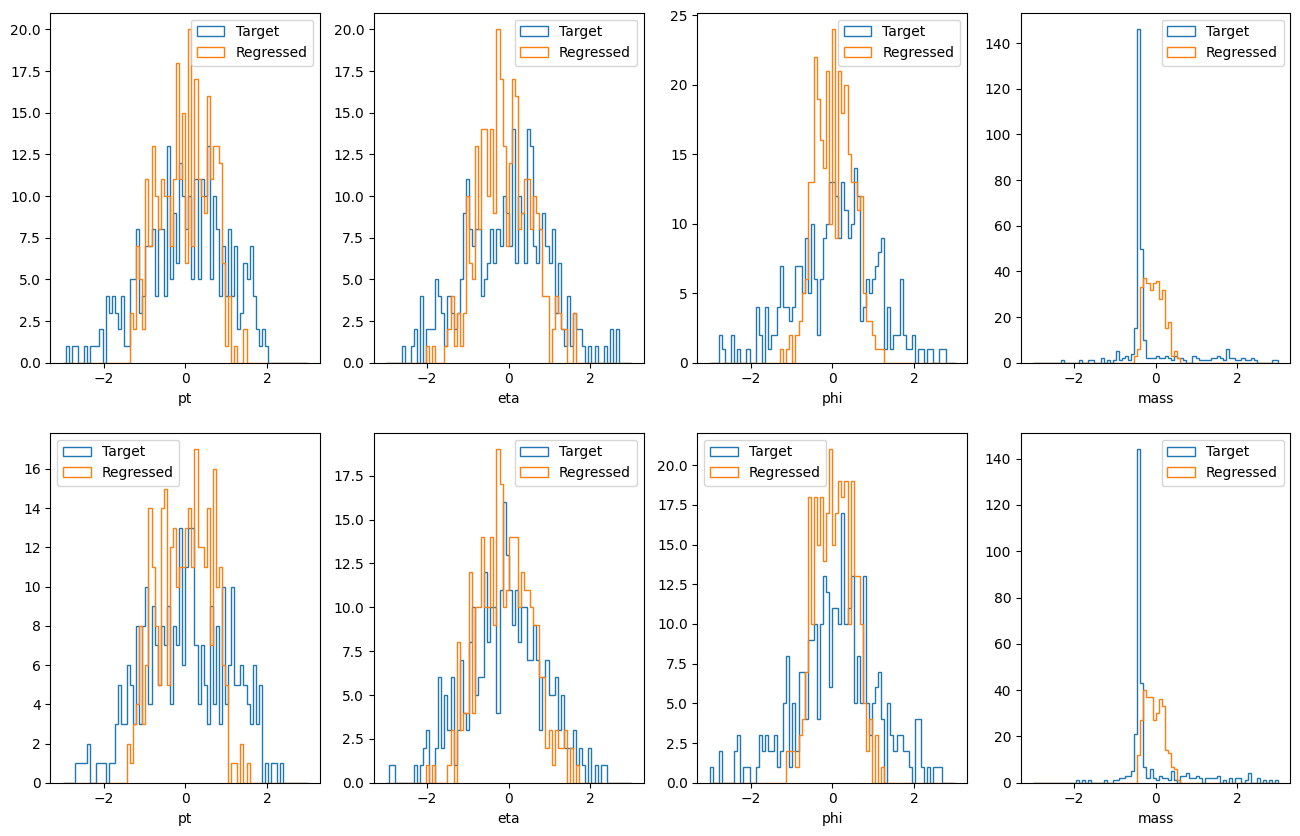

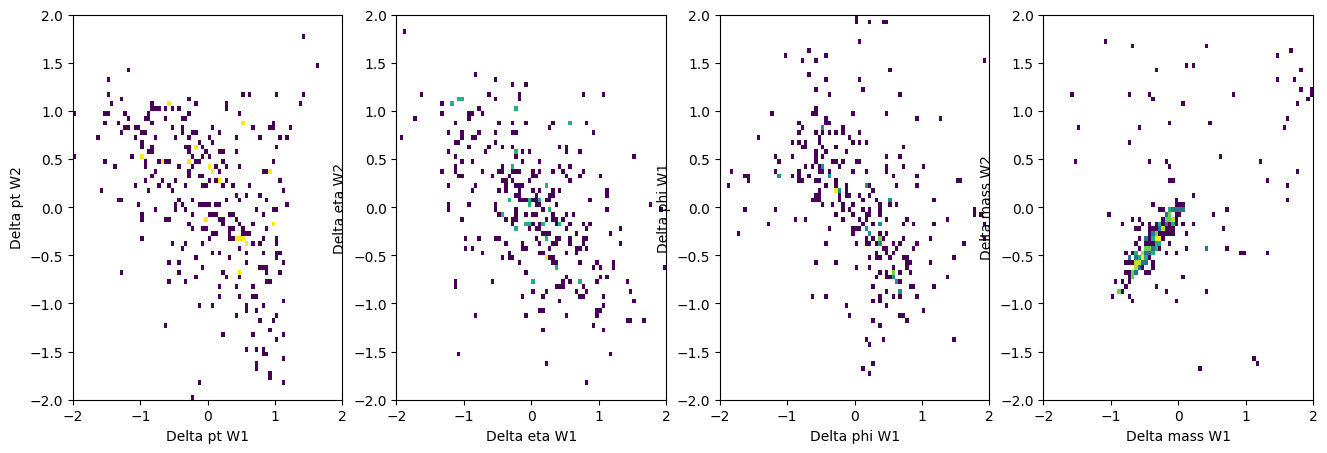

epoch 7, validation loss: 0.7385977506637573
End of epoch
epoch 8, step 0, Loss: 0.7247451543807983
epoch 8, step 100, Loss: 0.7449182271957397
epoch 8, step 200, Loss: 0.7173811197280884
epoch 8, step 300, Loss: 0.7822244763374329
epoch 8, step 400, Loss: 0.741448163986206


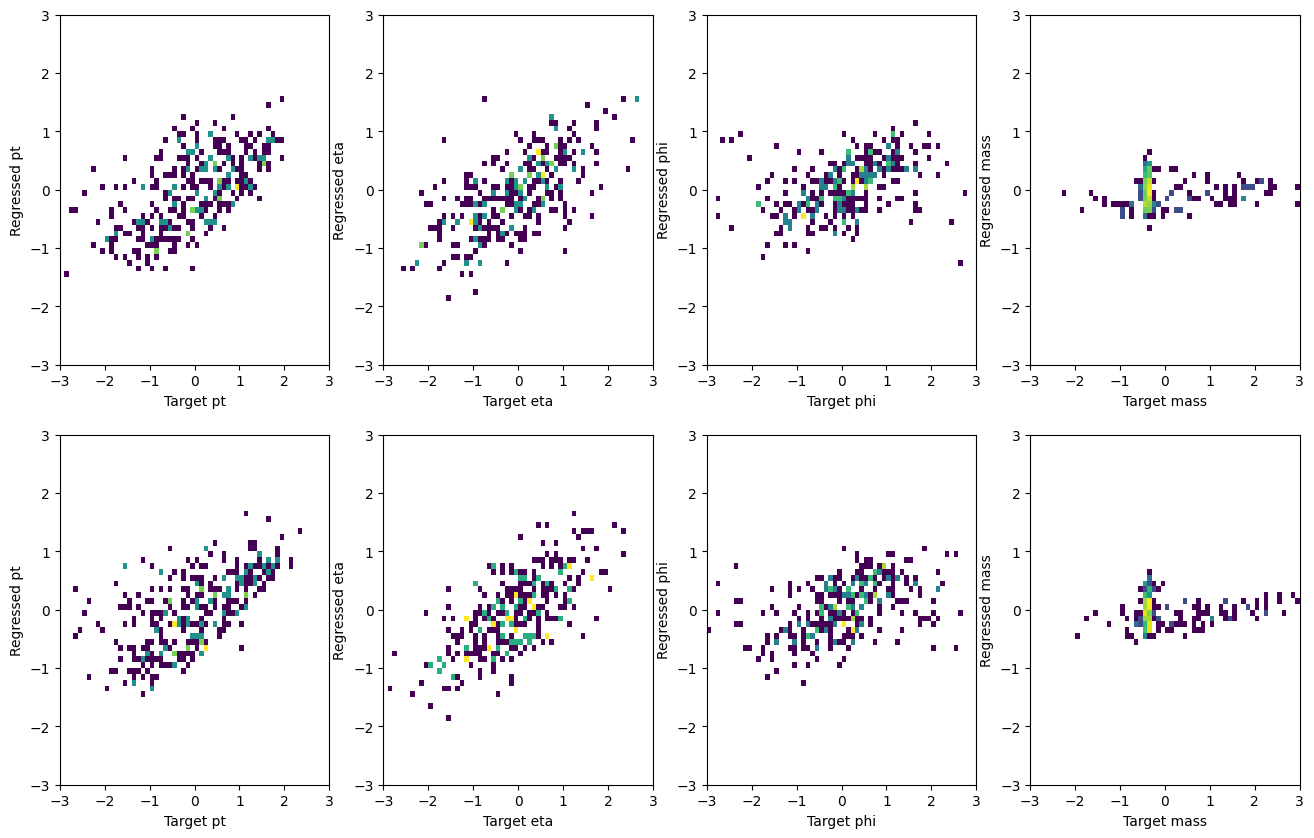

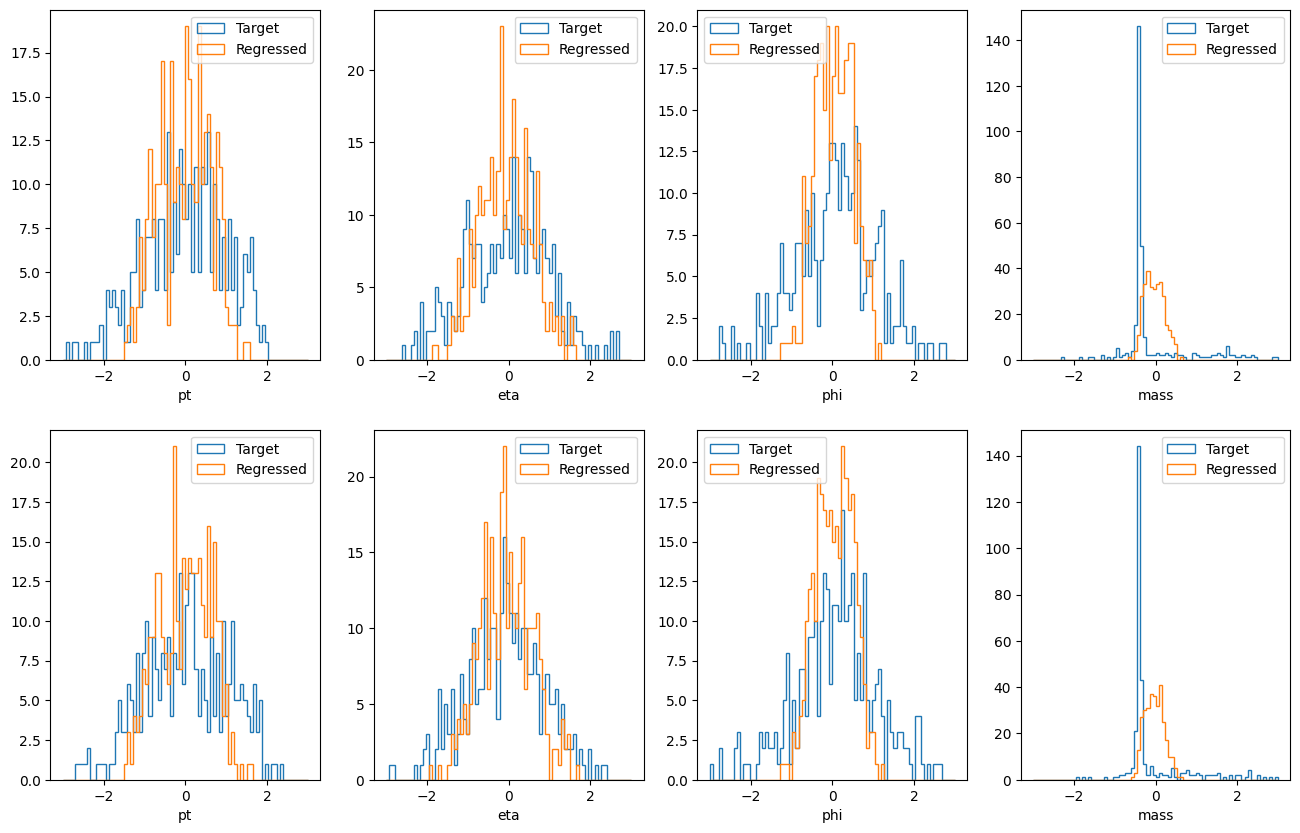

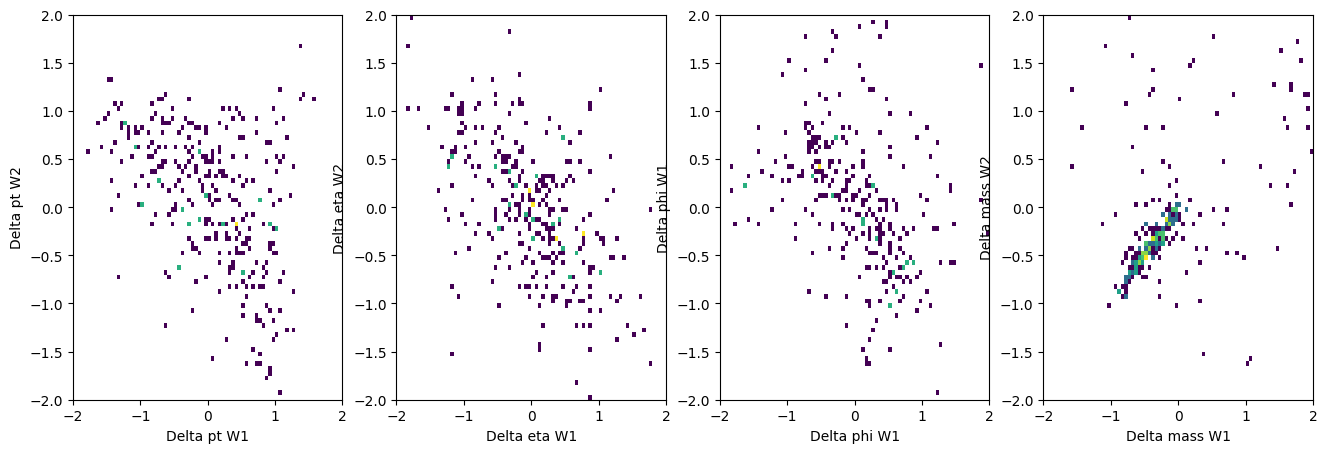

epoch 8, validation loss: 0.7377177610993385
End of epoch
epoch 9, step 0, Loss: 0.7244933843612671
epoch 9, step 100, Loss: 0.7420876026153564
epoch 9, step 200, Loss: 0.7173391580581665
epoch 9, step 300, Loss: 0.7768611311912537
epoch 9, step 400, Loss: 0.7415664196014404


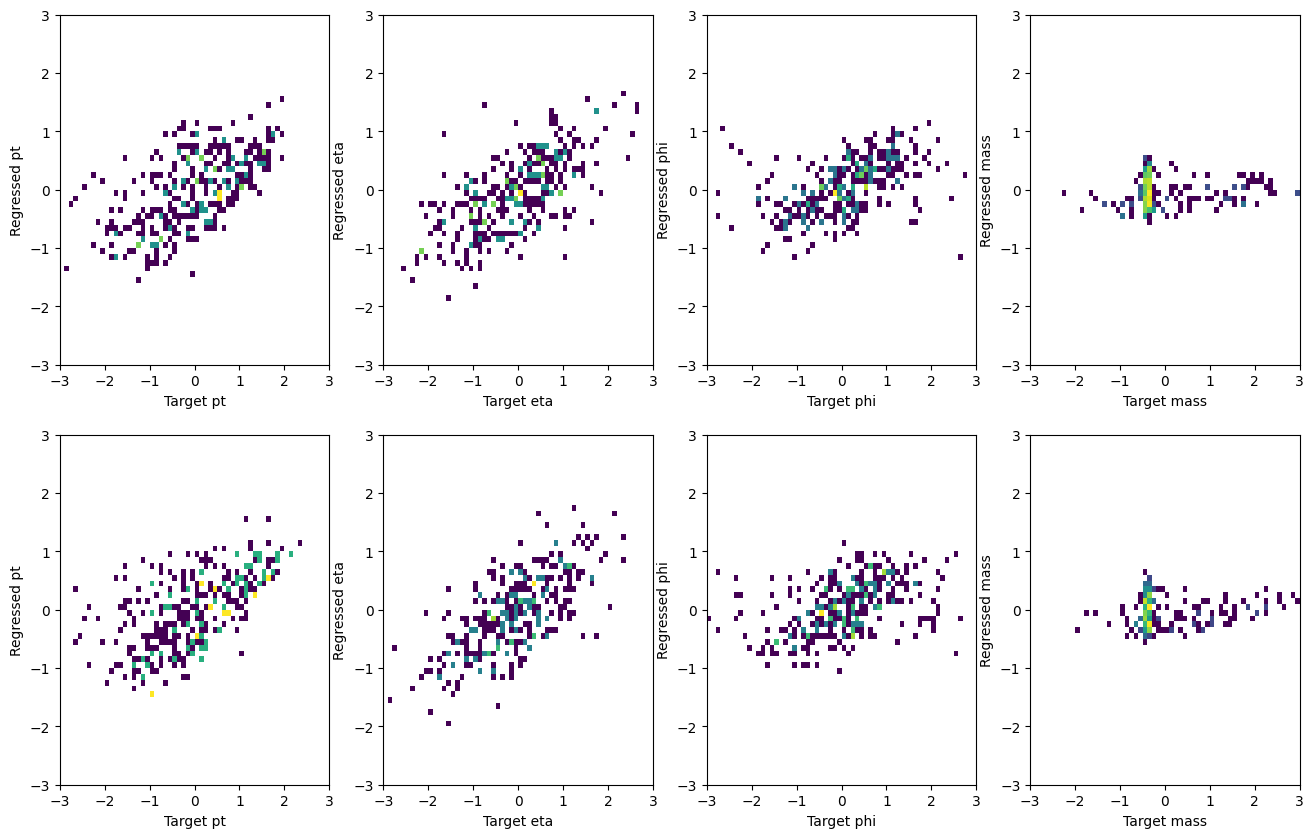

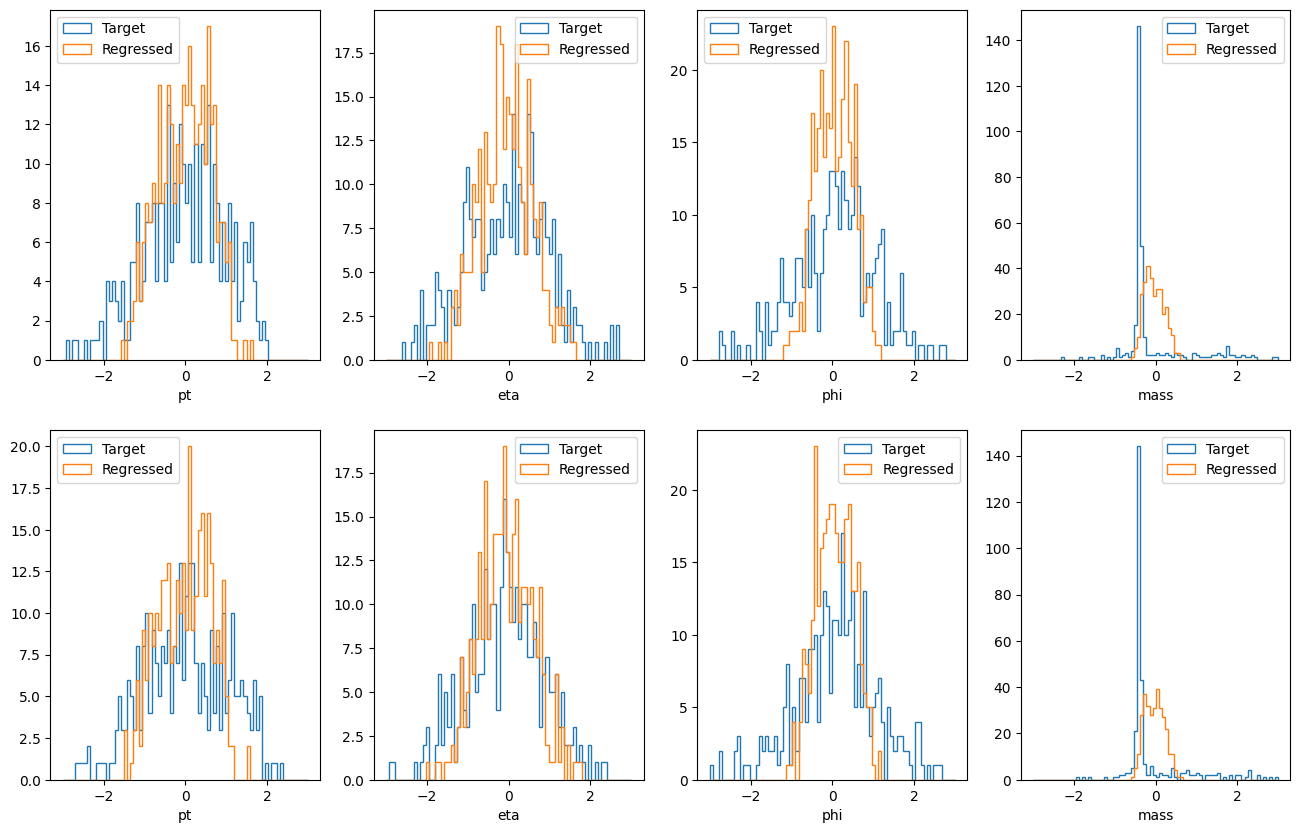

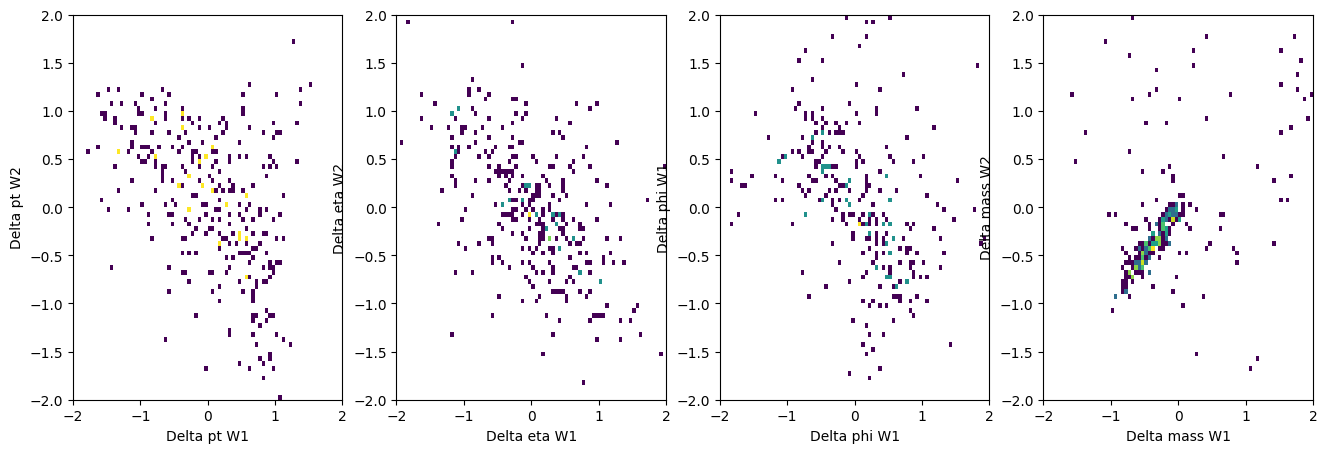

epoch 9, validation loss: 0.7370046213269233
End of epoch


In [11]:
num_epochs = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

d_model = 32
nhead = 4
num_encoder_layers = 2
num_decoder_layers = 2
learning_rate = 1e-4

model = WWRegressorComplete(d_model, nhead, num_encoder_layers, num_decoder_layers,
                   regression_net=[16])
model.to(device)

print(f"Model with {count_parameters(model)} parameters")

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss(reduction='none')

# Create Comet.ml experiment
# exp = Experiment(
#              api_key=comet_token,
#              project_name="PhDCourse",
#              workspace="valsdav",
#              auto_output_logging = "simple",
#              # disabled=True
#          )
# exp.log_parameters({"model_param_tot": count_parameters(model)})

#exp.display(tab='panels')
exp = None

trained_model = train(model, device, dataloader_train, dataloader_val, optimizer, criterion, num_epochs)

(<Figure size 1600x1000 with 8 Axes>,
 <Figure size 1600x1000 with 8 Axes>,
 <Figure size 1600x500 with 4 Axes>)

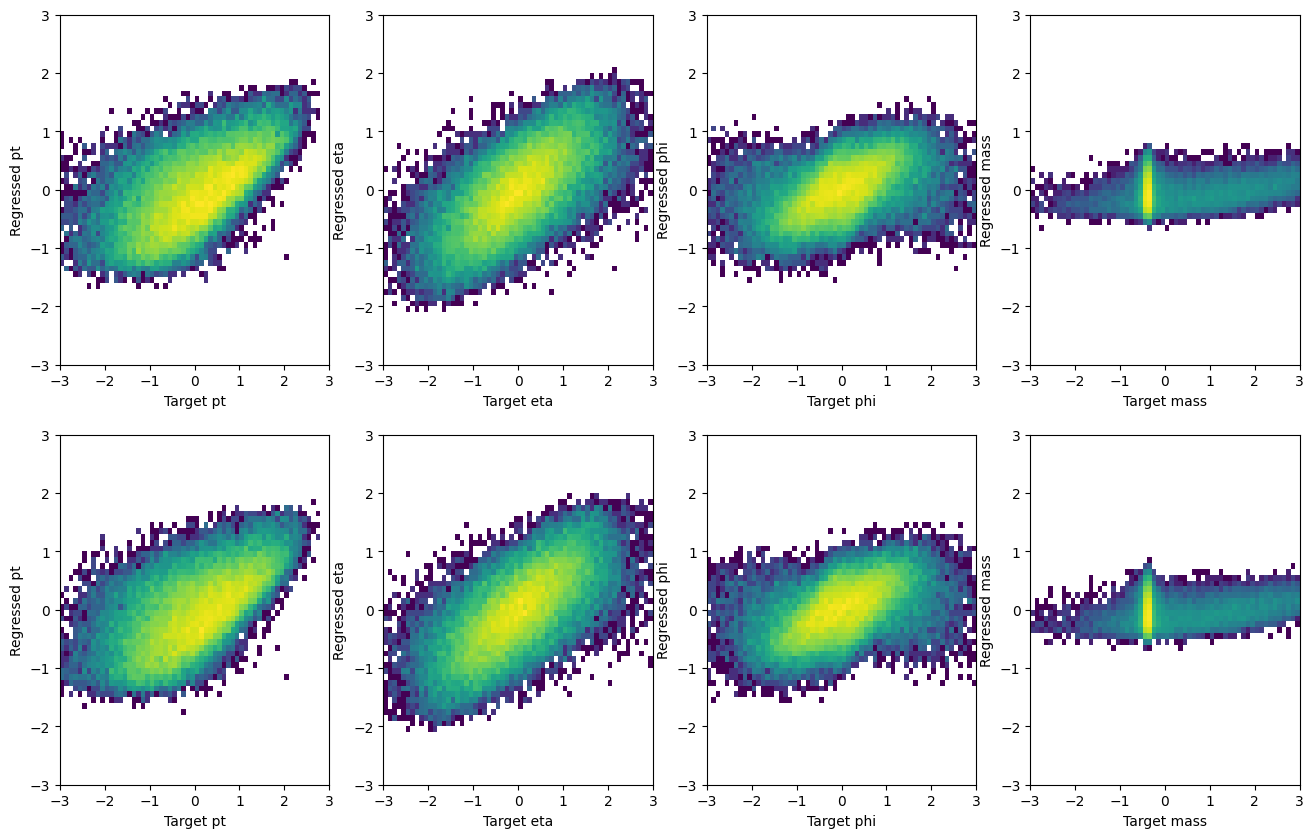

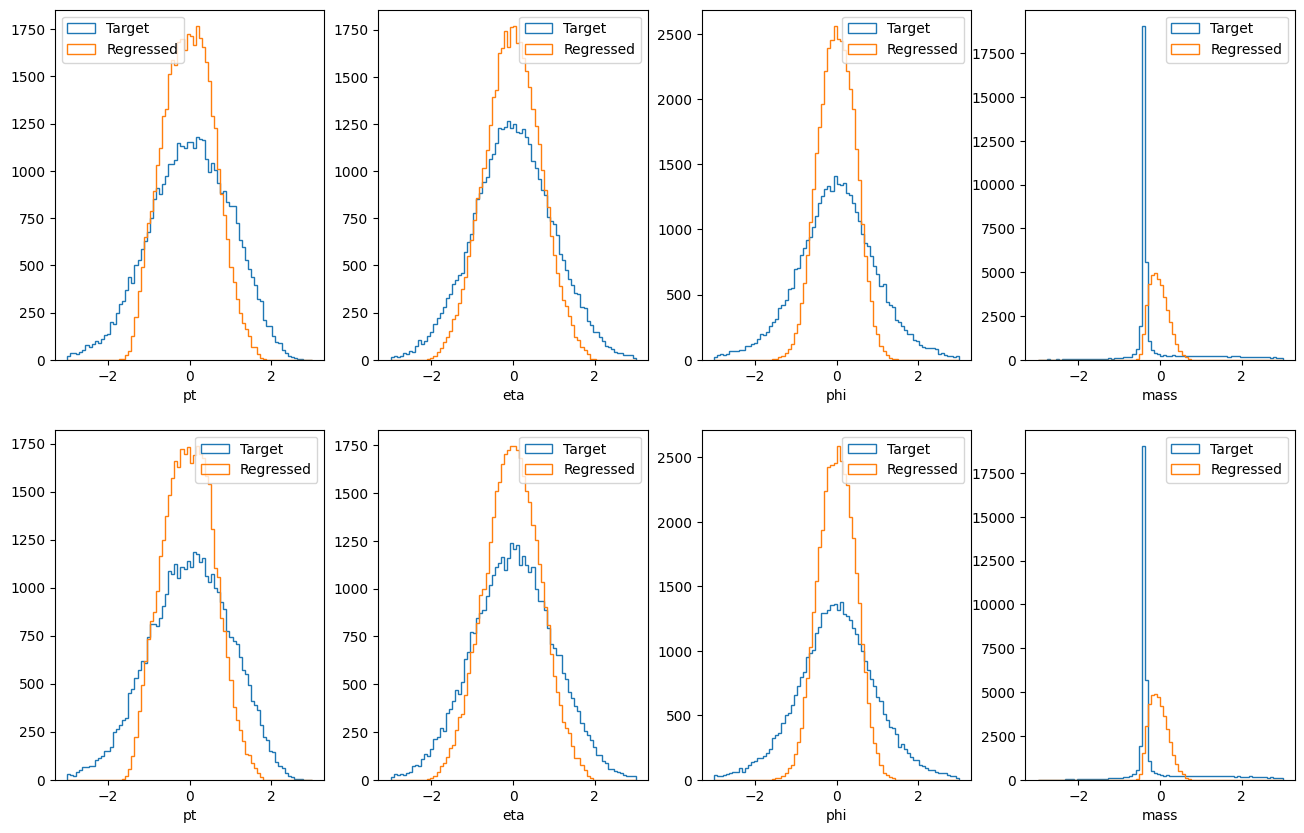

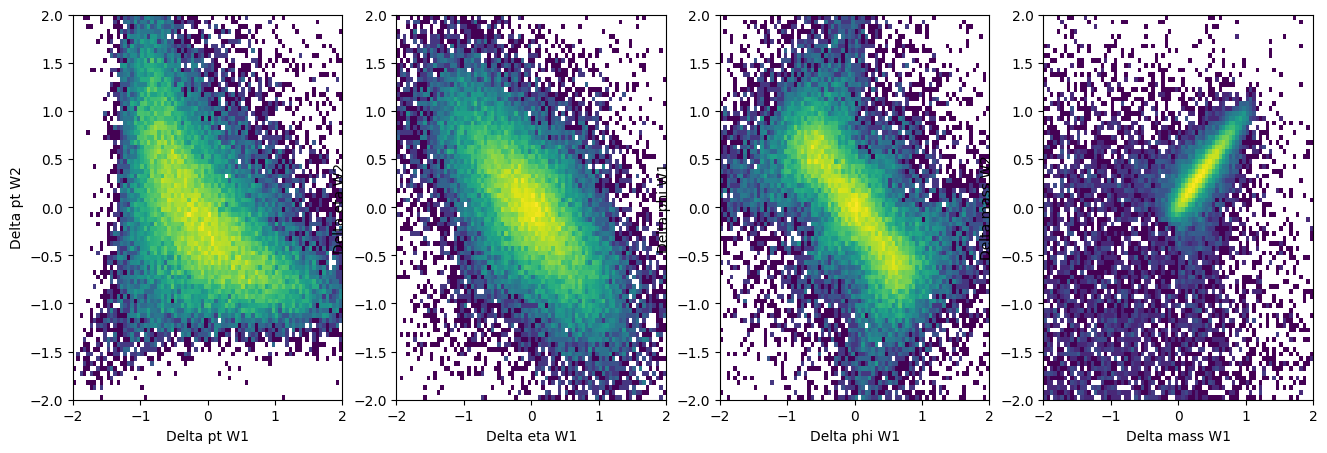

In [14]:
#Larger evaluation
with torch.no_grad():
    jets, lepton, met,full_mask, nu, W = dataset_val[0:40000]
    W_out = model(jets, lepton, met,full_mask)
    loss = criterion(W_out, W)

validation_plots(W, W_out)

In [15]:
torch.save(model.state_dict(), "models/model_WWregr_initial.pt")

## Training with MMD loss

Often regressions are biased toward the most probable value. This is a "feature" of the MSE loss.
If the value to regress is not "flat" but has long tails, the regression will often collpapse on the most probable case.

Using an alternative regression loss such as the **Huber loss** [wikipedia](https://en.wikipedia.org/wiki/Huber_loss) can alleviate the problem, but not solve it completely. 

To counteract this problem we can add to the loss a term that is measuring the difference between the distribution of the target variable and the distribution of the output of the regression./



In [16]:
from libs.mmd import MMD

In [17]:
torch.cuda.empty_cache()

In [21]:
datafolder = "/eos/user/d/dvalsecc/EFT_PhD_Course/training_datasets"

# Usage example
input_paths_training = [ f"{datafolder}/{f}_training.npy" for f in ["jet_data", "lepton_data", "met_data","jetlepmet_padding_mask",  "nu_data", "W_data"]]
input_paths_validation = [ f"{datafolder}/{f}_validation.npy" for f in ["jet_data", "lepton_data", "met_data","jetlepmet_padding_mask", "nu_data", "W_data"]]

dataset_train = dataloader.ChunkedNumpyDataset(input_paths_training, max_events=400000, device="cuda")
dataset_val  = dataloader.ChunkedNumpyDataset(input_paths_validation, max_events=200000, device="cuda")

# Create DataLoader
batch_size = 1024
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=False)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size*6, shuffle=False)

In [22]:
def train_withMMD(model, device, loader, val_loader,  optimizer, criterion, epochs, experiment=None):
    for epoch in range(epochs):
        model.train()
        for batch_idx, (jets, lepton, met, full_mask, nu, W) in enumerate(loader):
            
            optimizer.zero_grad()
            W_out = model(jets, lepton, met, full_mask)
            mask_nan = torch.isnan(W_out).any(axis=(1,2))
            MMDs_1 = []
            MMDs_2 = []
            for i in range(4):
                MMDs_1.append(MMD(W[~mask_nan][:,0,i:i+1], W_out[~mask_nan][:,0,i:i+1], kernel="multiscale", device=device, dtype=torch.float32))
                MMDs_2.append(MMD(W[~mask_nan][:,1,i:i+1], W_out[~mask_nan][:,1,i:i+1], kernel="multiscale", device=device, dtype=torch.float32))
            MMD_loss_1 = sum(MMDs_1)/4
            MMD_loss_2 = sum(MMDs_2)/4
            
            loss_huber = criterion(W_out, W).nanmean()
            loss =  loss_huber +  MMD_loss_1 + MMD_loss_2
            
            
            if batch_idx % 100 == 0:
                print(f"epoch {epoch}, step {batch_idx}, Loss: {loss.item():.4f}, loss regr: {loss_huber.item():.4f},  MMD W1: {MMD_loss_1.item():.4f}, MMD W2: {MMD_loss_2.item():.4f} ")
                if exp:
                   experiment.log_metric("train_loss_step", loss.item(), step=batch_idx)
                    
            loss.backward()
            optimizer.step()
        # Log metrics
        if experiment:
            experiment.log_metric("train_loss_epoch", loss.item(), step=epoch)
        
        # Validation loss
        #model.eval()  #I'm having problems with model.eval
        val_loss = 0.  
        val_loss_huber = 0.
        val_loss_mmd_w1 = 0.
        val_loss_mmd_w2 = 0.
        
        with torch.no_grad():
            for jets_val, lepton_val, met_val ,full_mask_val, nu_val, W_val in val_loader:
                W_out_val = model(jets_val, lepton_val, met_val, full_mask_val)
       
                mask_nan_val = torch.isnan(W_out_val).any(axis=(1,2))
                MMDs_1_val = []
                MMDs_2_val = []
                for i in range(4):
                    MMDs_1_val.append(MMD(W_val[~mask_nan_val][:,0,i:i+1], W_out_val[~mask_nan_val][:,0,i:i+1], kernel="multiscale", device=device, dtype=torch.float32))
                    MMDs_2_val.append(MMD(W_val[~mask_nan_val][:,1,i:i+1], W_out_val[~mask_nan_val][:,1,i:i+1], kernel="multiscale", device=device, dtype=torch.float32))
                MMD_loss_1_val = sum(MMDs_1_val)/4
                MMD_loss_2_val = sum(MMDs_2_val)/4
                
                loss_huber_val = criterion(W_out_val, W_val).nanmean()
                val_loss += (loss_huber_val +  MMD_loss_1_val + MMD_loss_2_val).item()
                val_loss_huber += loss_huber_val.item()
                val_loss_mmd_w1 += MMD_loss_1_val.item()
                val_loss_mmd_w2 += MMD_loss_2_val.item()
                
            val_loss = val_loss / len(val_loader)
            val_loss_huber = val_loss_huber / len(val_loader)
            val_loss_mmd_w1 = val_loss_mmd_w1 / len(val_loader)
            val_loss_mmd_w2 = val_loss_mmd_w2 / len(val_loader)
            
            if experiment:
                experiment.log_metric("val_loss_epoch", val_loss.item(), step=epoch)
            print(f"epoch {epoch}, Validation Loss: {val_loss:.4f}, loss regr: {val_loss_huber:.4f},  MMD W1: {val_loss_mmd_w1:.4f}, MMD W2: {val_loss_mmd_w2:.4f} ")

            #print for one batch
            _ = validation_plots(W_val, W_out_val)
            plt.show()
            
        print(f"End of epoch {epoch}")
    return model

Model with 160359 parameters
epoch 0, step 0, Loss: 4.2049, loss regr: 1.0727,  MMD W1: 1.5581, MMD W2: 1.5742 
epoch 0, step 100, Loss: 1.4390, loss regr: 1.1583,  MMD W1: 0.1320, MMD W2: 0.1487 
epoch 0, step 200, Loss: 1.1331, loss regr: 0.9534,  MMD W1: 0.0863, MMD W2: 0.0934 
epoch 0, step 300, Loss: 1.1177, loss regr: 0.9826,  MMD W1: 0.0642, MMD W2: 0.0710 
epoch 0, Validation Loss: 1.0049, loss regr: 0.9093,  MMD W1: 0.0473, MMD W2: 0.0483 


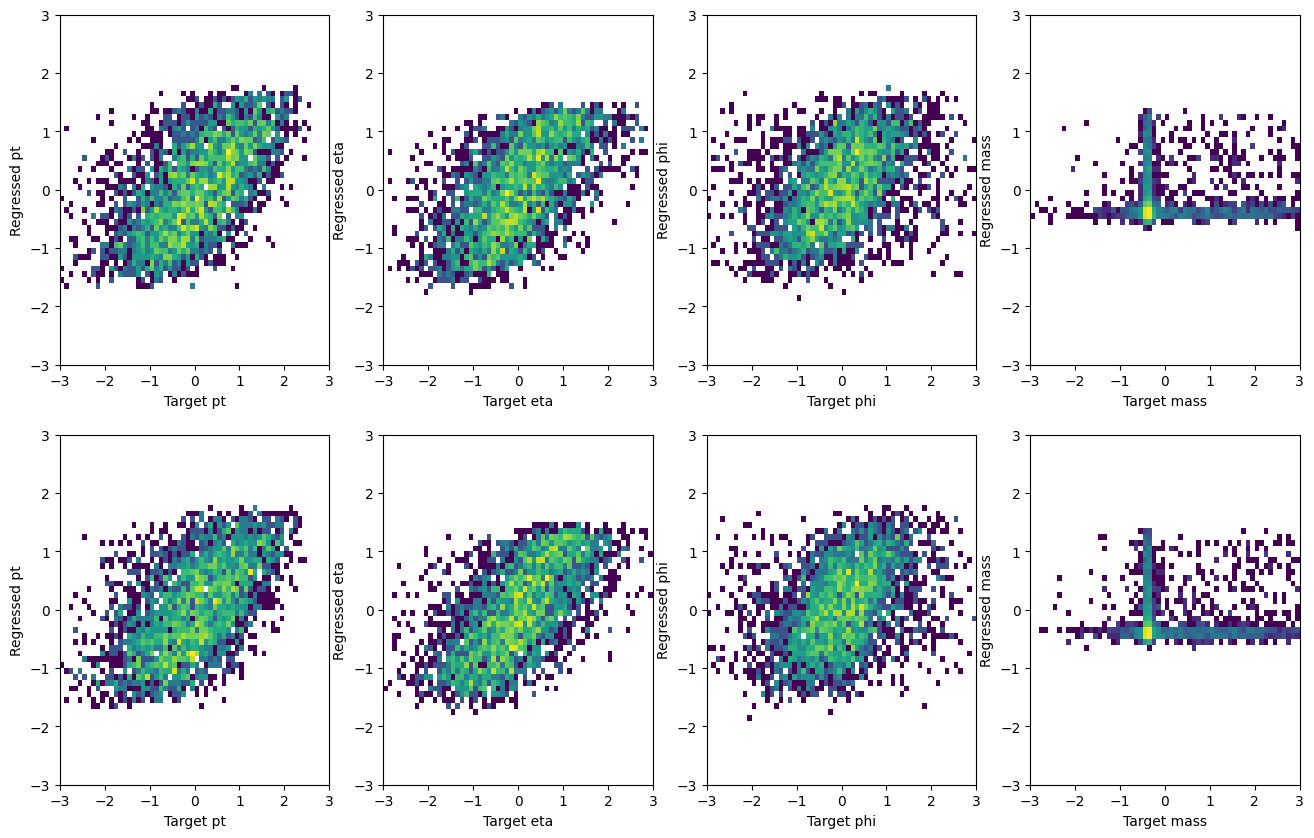

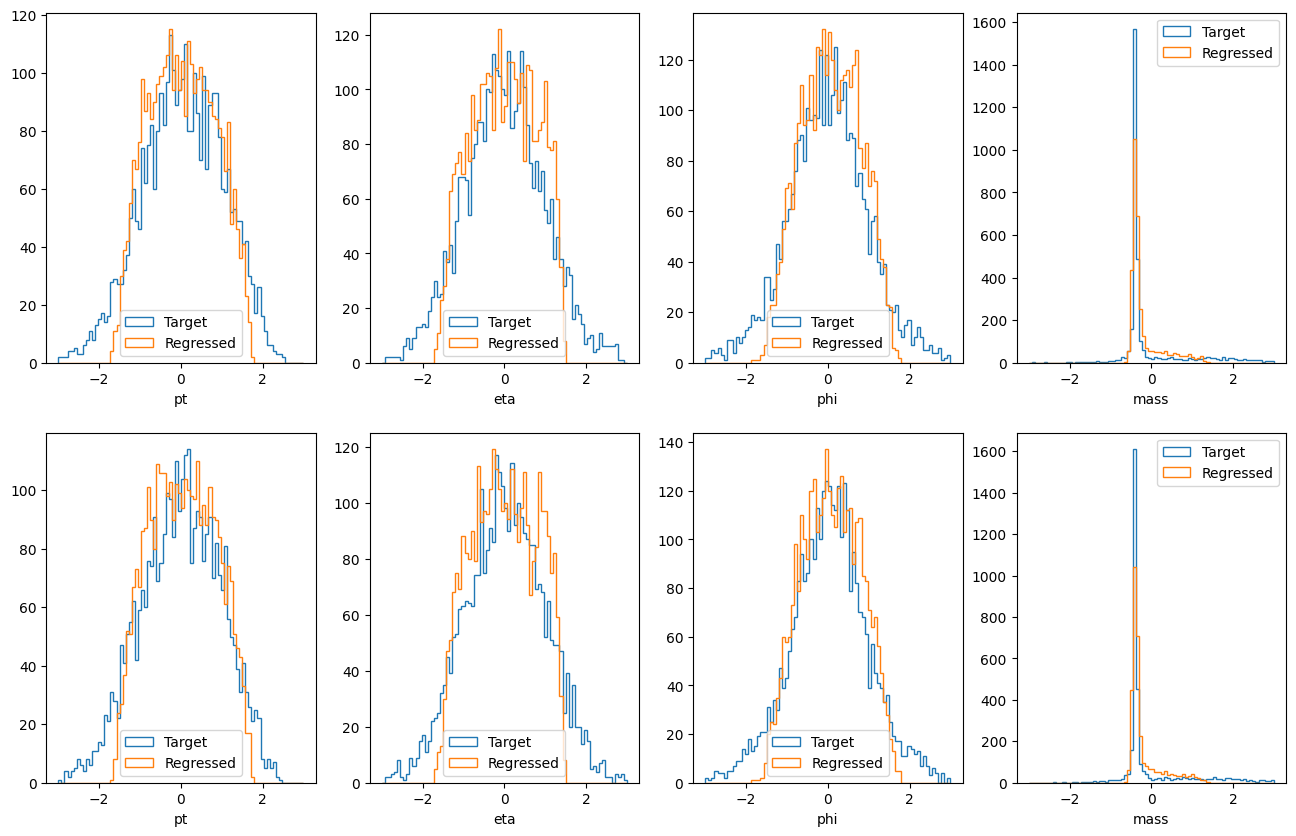

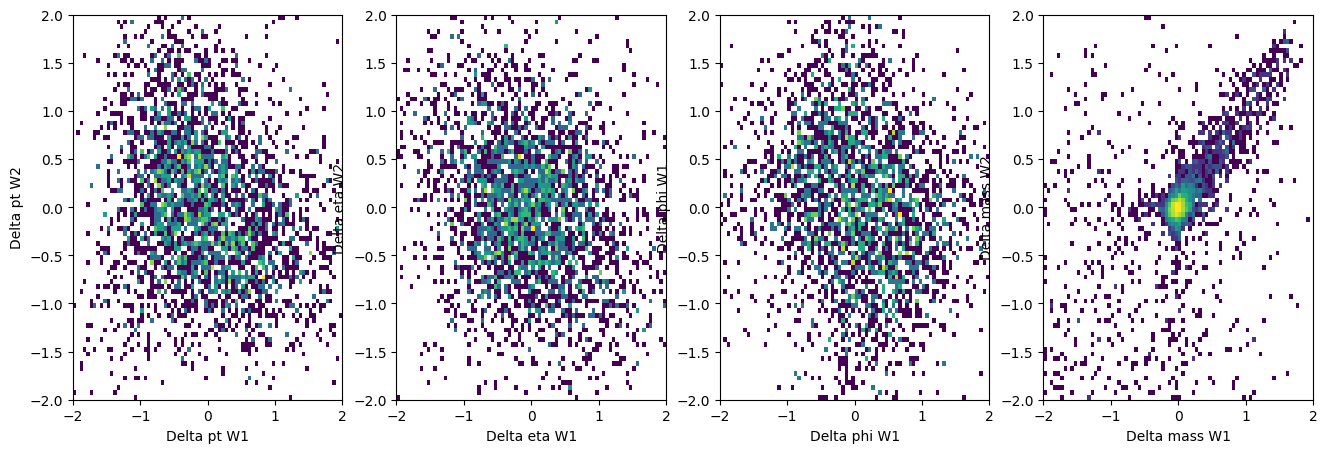

End of epoch 0
epoch 1, step 0, Loss: 1.0097, loss regr: 0.9028,  MMD W1: 0.0529, MMD W2: 0.0540 
epoch 1, step 100, Loss: 1.0023, loss regr: 0.9038,  MMD W1: 0.0469, MMD W2: 0.0516 
epoch 1, step 200, Loss: 0.9523, loss regr: 0.8544,  MMD W1: 0.0479, MMD W2: 0.0499 
epoch 1, step 300, Loss: 1.0031, loss regr: 0.9126,  MMD W1: 0.0429, MMD W2: 0.0476 
epoch 1, Validation Loss: 0.9371, loss regr: 0.8682,  MMD W1: 0.0338, MMD W2: 0.0352 


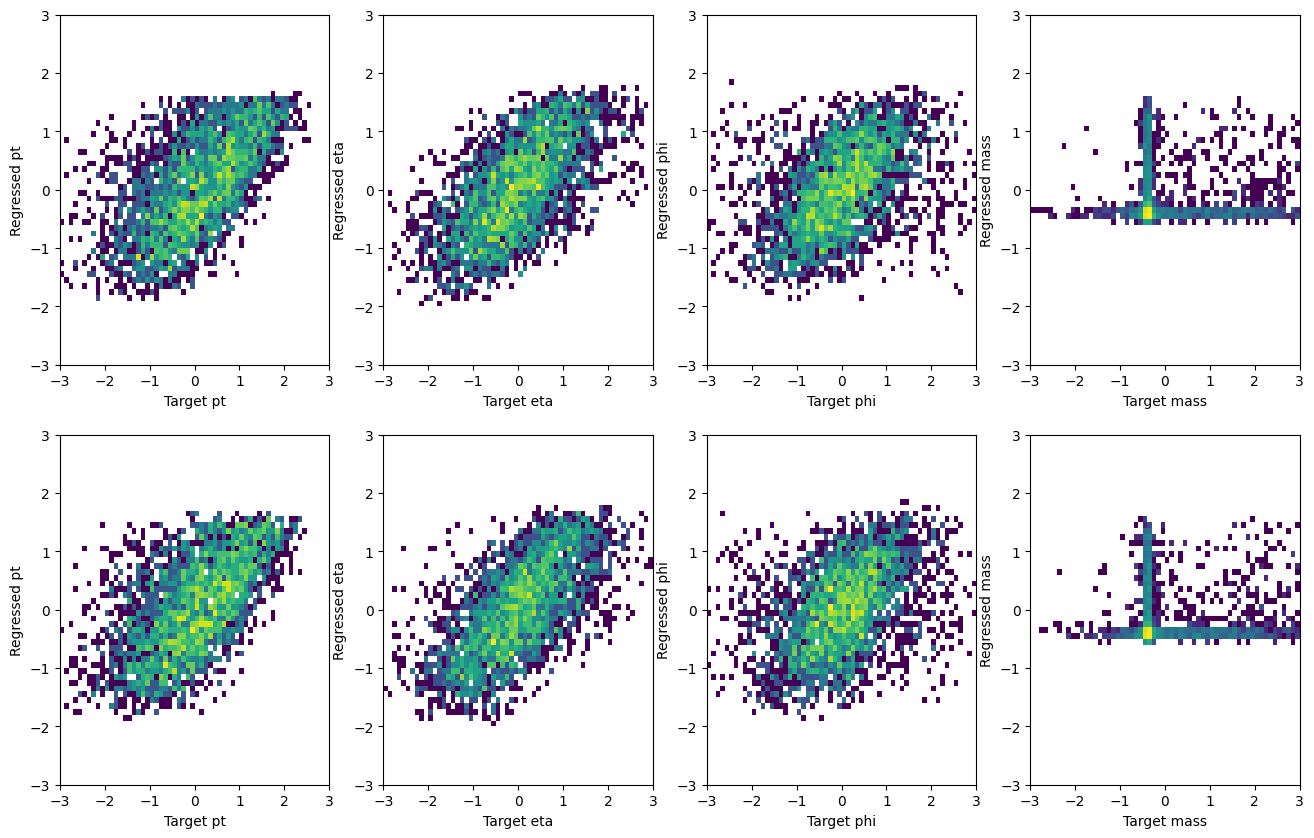

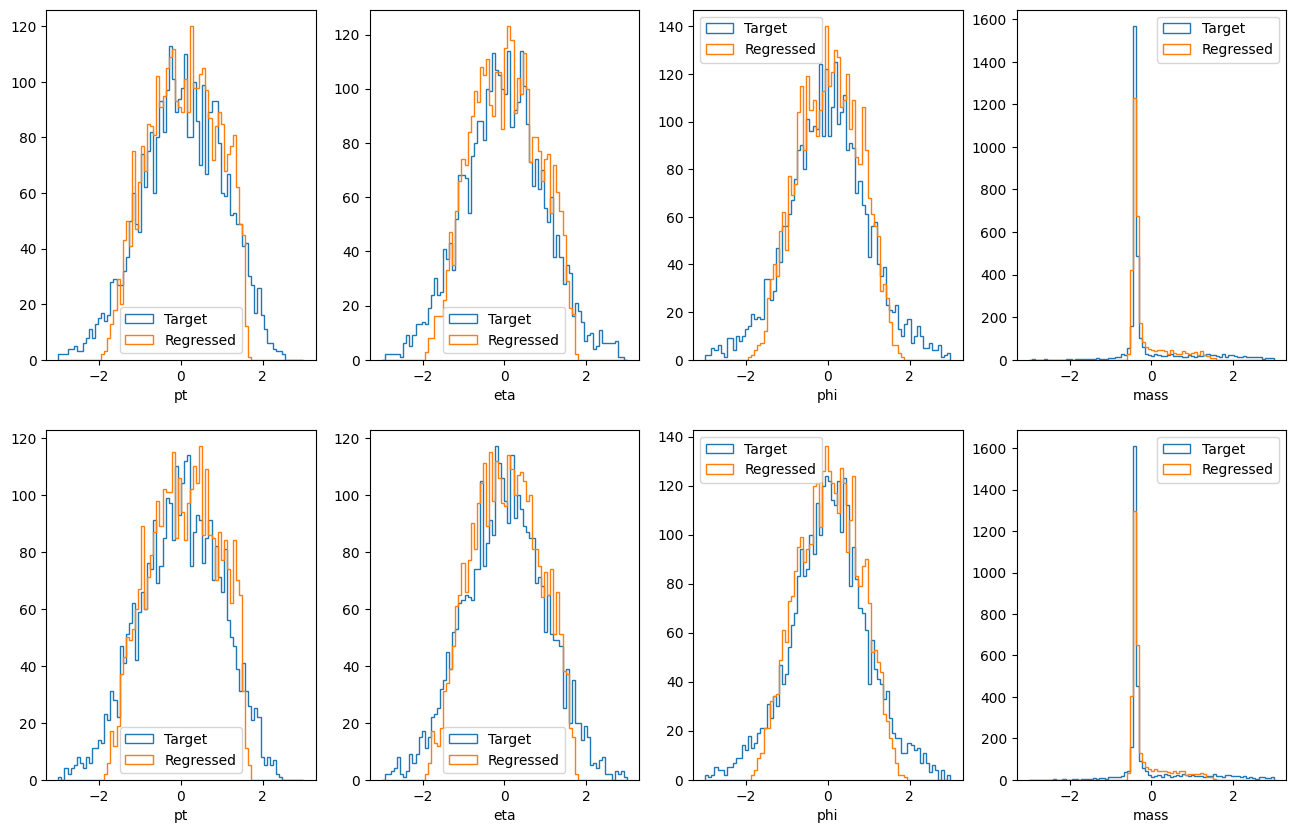

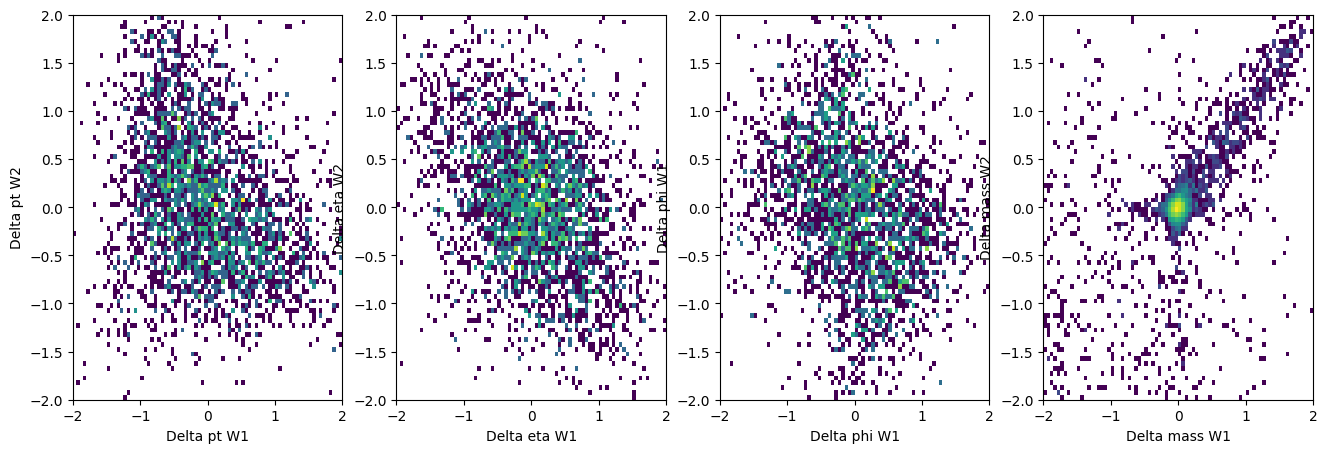

End of epoch 1
epoch 2, step 0, Loss: 0.9359, loss regr: 0.8607,  MMD W1: 0.0377, MMD W2: 0.0375 
epoch 2, step 100, Loss: 0.9582, loss regr: 0.8685,  MMD W1: 0.0442, MMD W2: 0.0454 
epoch 2, step 200, Loss: 0.9046, loss regr: 0.8222,  MMD W1: 0.0415, MMD W2: 0.0409 
epoch 2, step 300, Loss: 0.9783, loss regr: 0.8924,  MMD W1: 0.0406, MMD W2: 0.0452 
epoch 2, Validation Loss: 0.9171, loss regr: 0.8523,  MMD W1: 0.0318, MMD W2: 0.0330 


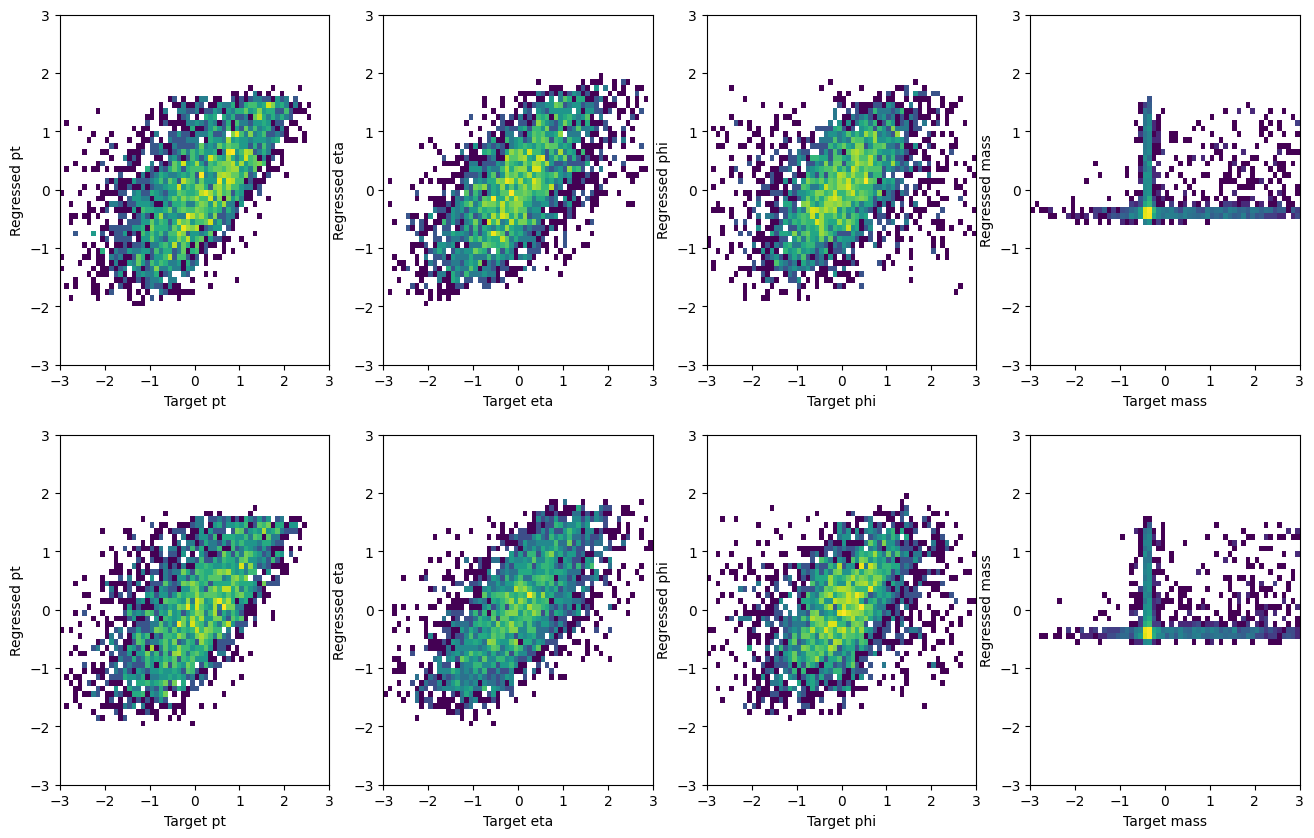

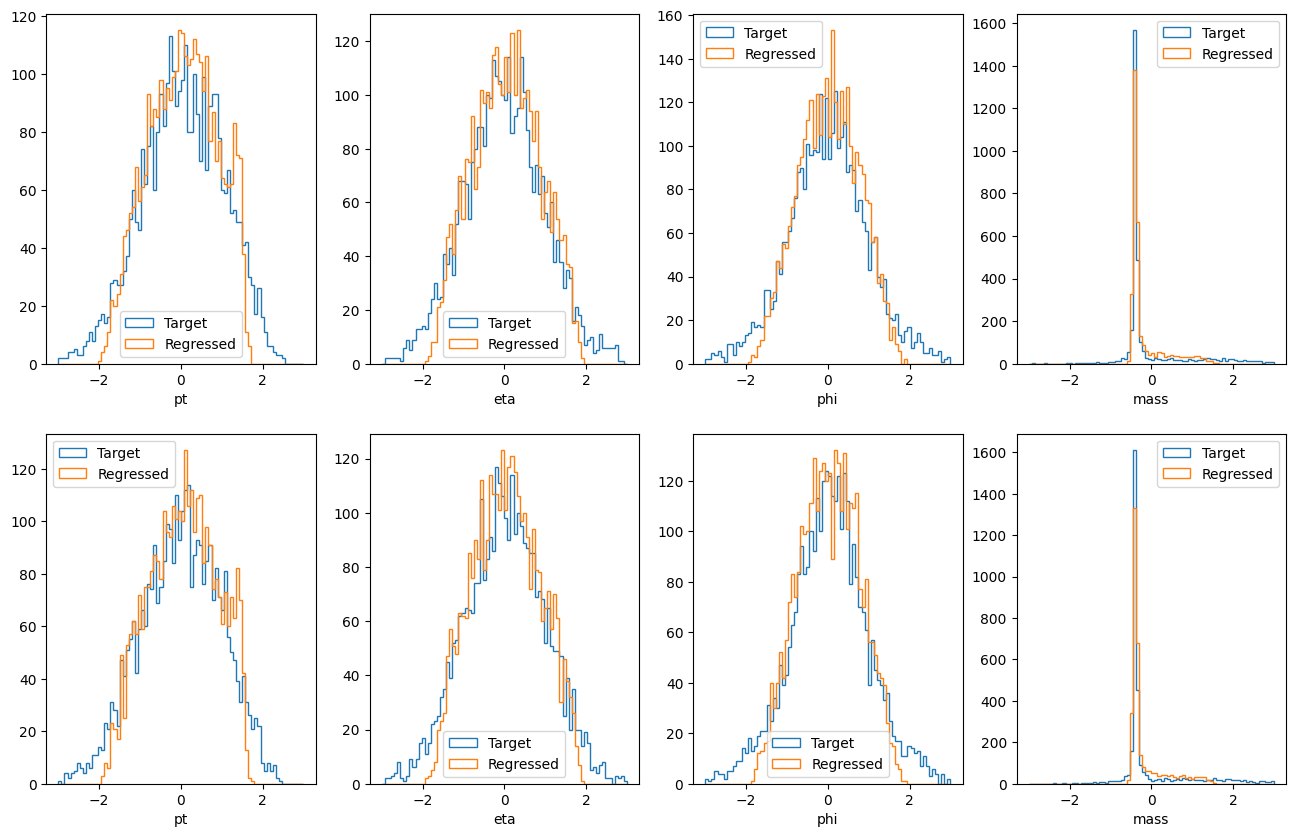

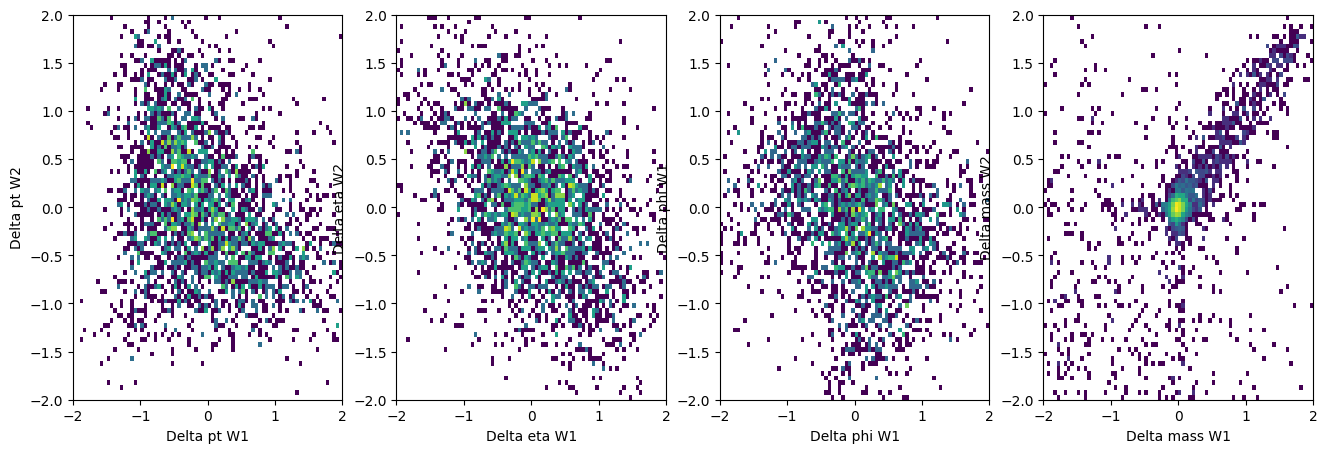

End of epoch 2
epoch 3, step 0, Loss: 0.9065, loss regr: 0.8386,  MMD W1: 0.0333, MMD W2: 0.0346 
epoch 3, step 100, Loss: 0.9522, loss regr: 0.8639,  MMD W1: 0.0453, MMD W2: 0.0431 
epoch 3, step 200, Loss: 0.8847, loss regr: 0.8035,  MMD W1: 0.0399, MMD W2: 0.0412 
epoch 3, step 300, Loss: 0.9646, loss regr: 0.8842,  MMD W1: 0.0394, MMD W2: 0.0409 
epoch 3, Validation Loss: 0.9078, loss regr: 0.8436,  MMD W1: 0.0314, MMD W2: 0.0328 


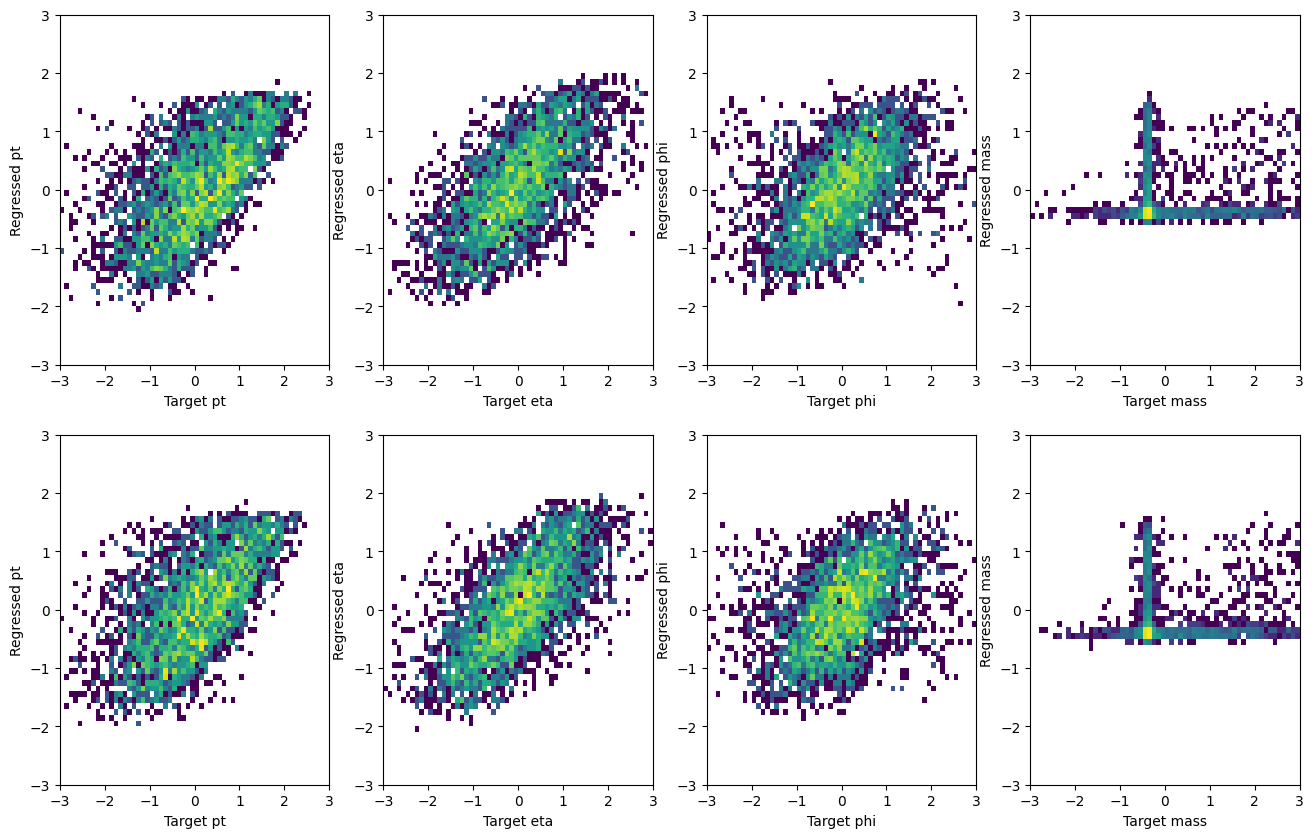

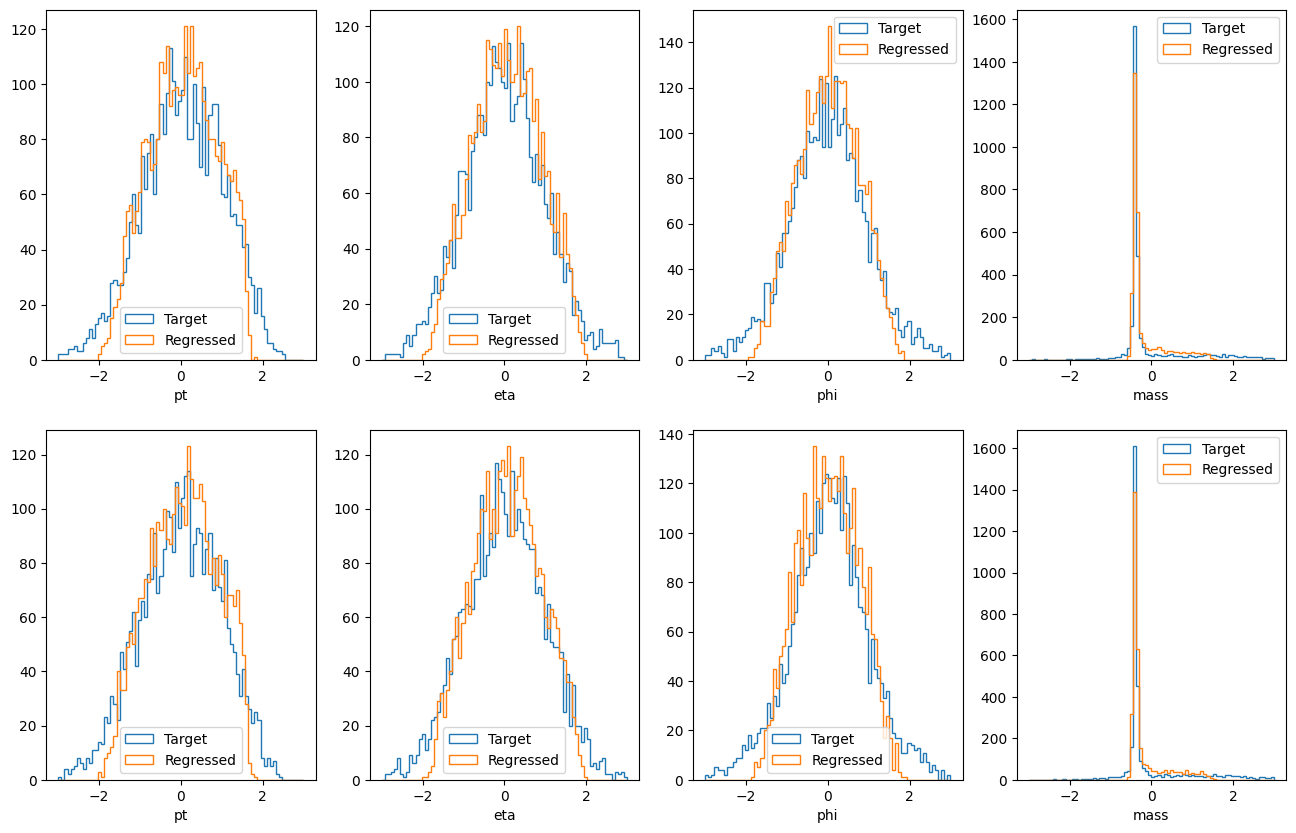

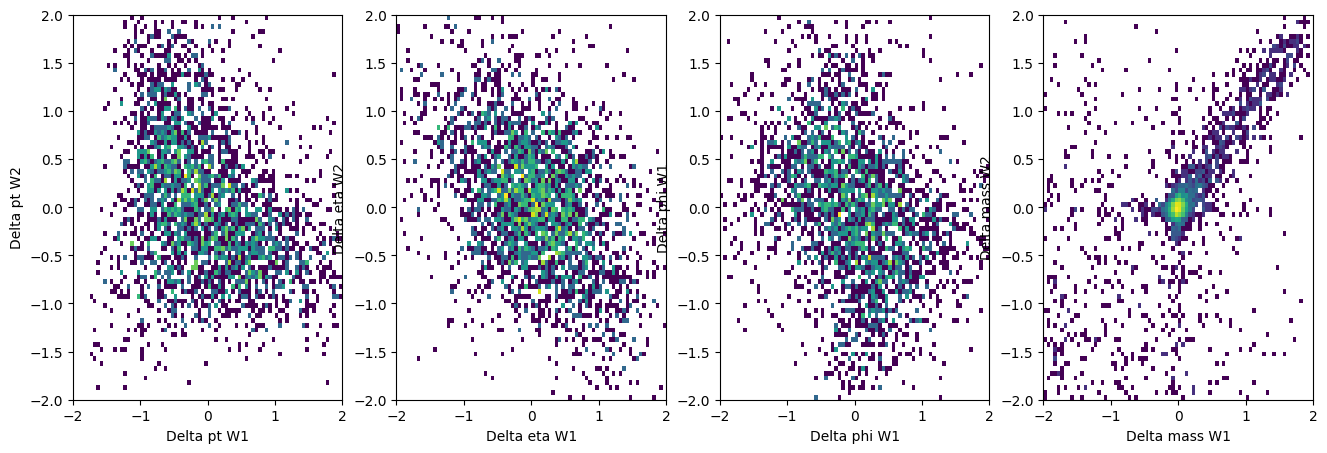

End of epoch 3
epoch 4, step 0, Loss: 0.9030, loss regr: 0.8351,  MMD W1: 0.0339, MMD W2: 0.0341 
epoch 4, step 100, Loss: 0.9396, loss regr: 0.8468,  MMD W1: 0.0457, MMD W2: 0.0470 


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7ff6c6738b90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


epoch 4, step 200, Loss: 0.8823, loss regr: 0.8098,  MMD W1: 0.0351, MMD W2: 0.0375 


KeyboardInterrupt: 

In [23]:
num_epochs = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

d_model = 32
nhead = 4
num_encoder_layers = 2
num_decoder_layers = 2
learning_rate = 1e-4

model = WWRegressorComplete(d_model, nhead, num_encoder_layers, num_decoder_layers,
                   regression_net=[16])
model.to(device)

print(f"Model with {count_parameters(model)} parameters")

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
#criterion = torch.nn.HuberLoss(delta=2., reduction='none')
criterion = torch.nn.MSELoss(reduction='none')
# Create Comet.ml experiment
# exp = Experiment(
#              api_key=comet_token,
#              project_name="PhDCourse",
#              workspace="valsdav",
#              auto_output_logging = "simple",
#              # disabled=True
#          )
# exp.log_parameters({"model_param_tot": count_parameters(model)})

#exp.display(tab='panels')
exp = None

trained_model = train_withMMD(model, device, dataloader_train, dataloader_val, optimizer, criterion, num_epochs)

In [24]:
with torch.no_grad():
    model.train()
    jets, lepton, met,full_mask, nu, W = dataset_val[0:40000]
    W_out = model(jets, lepton, met,full_mask)
    loss = criterion(W_out, W)

(<Figure size 1600x1000 with 8 Axes>,
 <Figure size 1600x1000 with 8 Axes>,
 <Figure size 1600x500 with 4 Axes>)

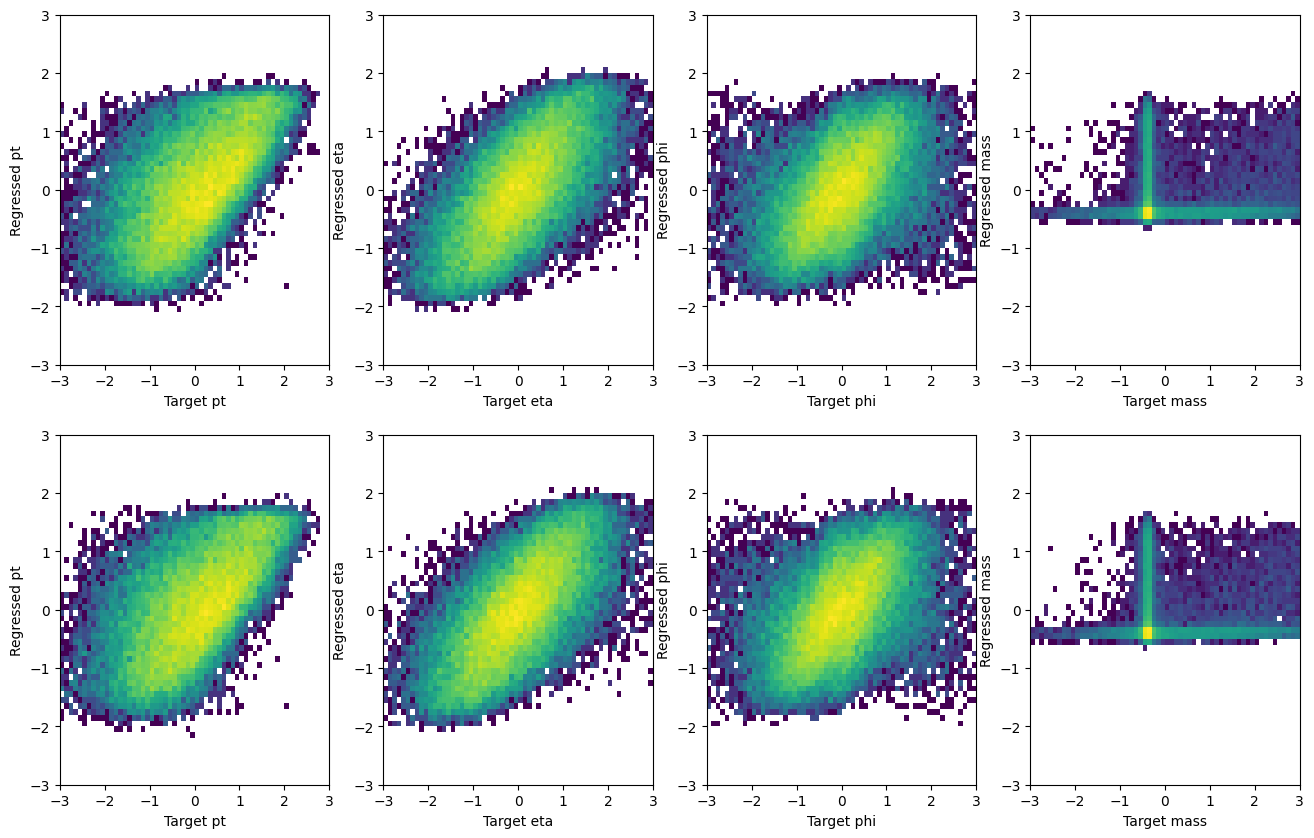

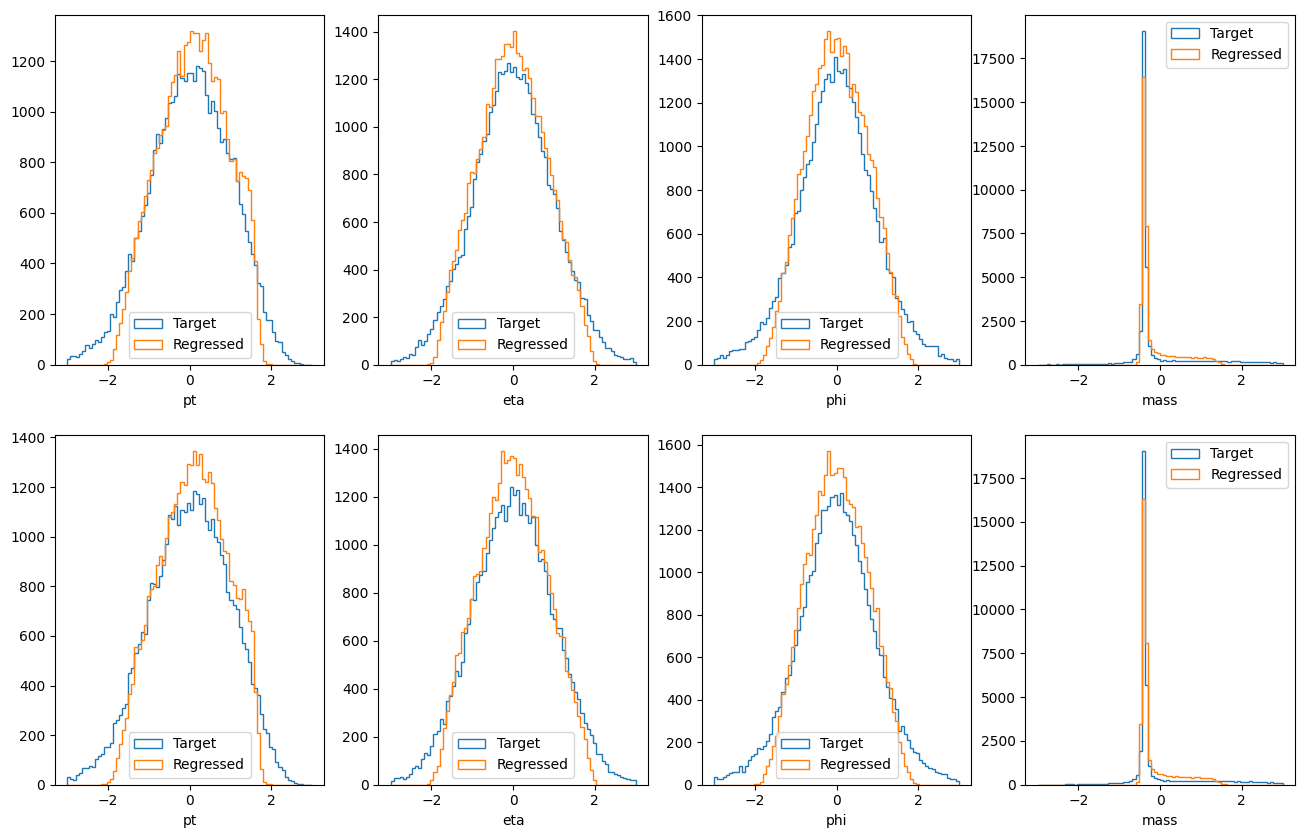

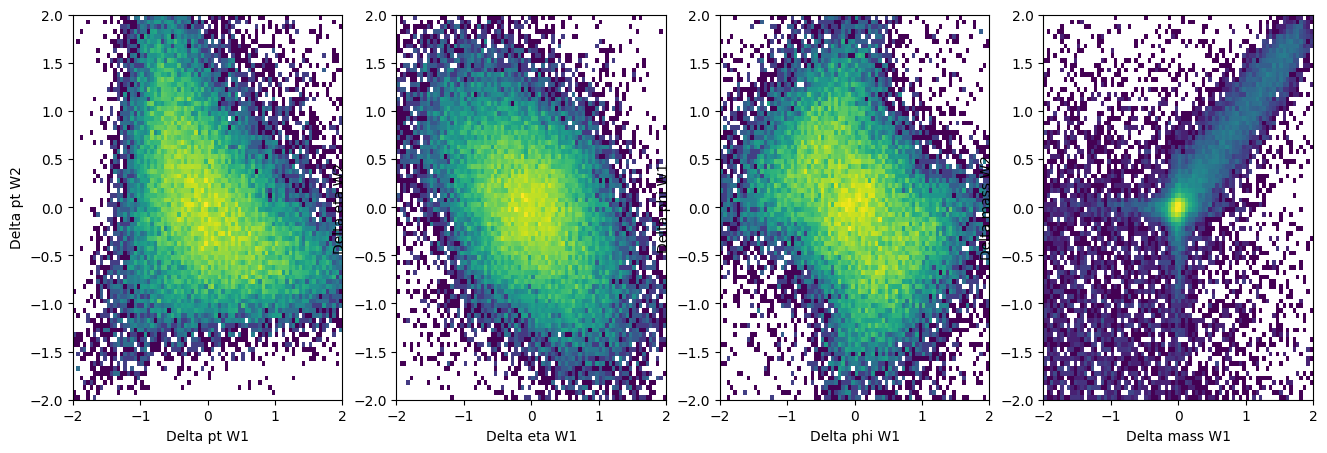

In [25]:
validation_plots(W, W_out)

In [28]:
torch.save(model.state_dict(), "models/model_WWregr_mmdloss.pt")

## Periodic-phi loss

The MSE or Huber loss for the phi variable is not taking into account the intrinsic periodicity of the phi variable. 
To take take into account we have to rescale the phi feature to the original [-pi, pi] space, and take the distance between the target and the regressed phi considering the periodicity. 

In [26]:
def logistic(x):
    return 1/(1+torch.exp(-x))

def logit(x, clip=1e-6):
    x = np.clip(x, a_min=clip, a_max=1-clip)
    return np.log(x/(1-x))

In [27]:
phi_scaling = torch.from_numpy(np.load(f"{datafolder}/W_data_scaling.npy")[2]).to("cuda")

def unscale_phi(phi):
    return  logistic((phi * phi_scaling[1])+phi_scaling[0])* 2 *np.pi - np.pi

def phi_loss(phi_x, phi_y, loss_fn):
    unscaled_x = unscale_phi(phi_x)
    unscaled_y = unscale_phi(phi_y)
    deltaPhi = torch.abs(unscaled_x - unscaled_y)
    deltaPhi = torch.where(deltaPhi > np.pi, deltaPhi - 2*np.pi, deltaPhi)
    deltaPhi = torch.where(deltaPhi <= -np.pi, deltaPhi + 2*np.pi, deltaPhi)
    return deltaPhi

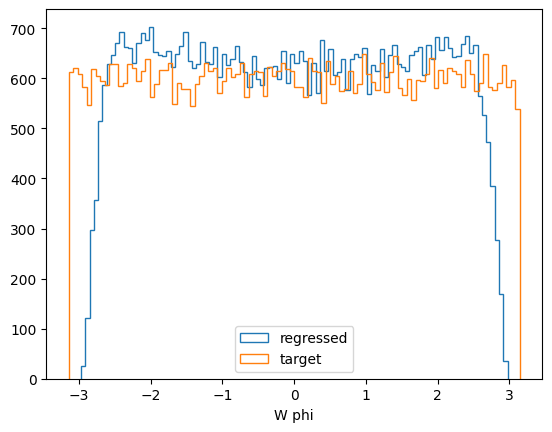

In [25]:
plt.hist(unscale_phi(W_out[:,:,2].cpu().numpy()).flatten(), 
         bins=100, histtype="step", label="regressed")
plt.hist(unscale_phi(W[:,:,2].cpu().numpy()).flatten(), 
         bins=100, histtype="step", label="target")
plt.legend()
plt.xlabel("W phi");

In [31]:
phi_loss(W_out[:,:,2], W[:,:,2], torch.nn.MSELoss())

tensor([[0.4126, 2.0707],
        [0.3275, 0.2169],
        [2.2296, 0.2769],
        ...,
        [1.8221, 0.8759],
        [1.0754, 1.6982],
        [1.0479, 0.2745]], device='cuda:0')

In [29]:
def train_withMMD_philoss(model, device, loader, val_loader,  optimizer, criterion, epochs, experiment=None):
    for epoch in range(epochs):
        model.train()
        for batch_idx, (jets, lepton, met, full_mask, nu, W) in enumerate(loader):
            
            optimizer.zero_grad()
            W_out = model(jets, lepton, met, full_mask)
            mask_nan = torch.isnan(W_out).any(axis=(1,2))
            MMDs_1 = []
            MMDs_2 = []
            for i in range(4):
                MMDs_1.append(MMD(W[~mask_nan][:,0,i:i+1], W_out[~mask_nan][:,0,i:i+1], kernel="multiscale", device=device, dtype=torch.float32))
                MMDs_2.append(MMD(W[~mask_nan][:,1,i:i+1], W_out[~mask_nan][:,1,i:i+1], kernel="multiscale", device=device, dtype=torch.float32))
            MMD_loss_1 = sum(MMDs_1)/4
            MMD_loss_2 = sum(MMDs_2)/4
            
            loss_huber = criterion(W_out[:,:,0:2], W[:,:,0:2]).nanmean() +\
                         criterion(W_out[:,:,3], W[:,:,3]).nanmean() + \
                         phi_loss(W_out[:,:,2], W[:,:,2], criterion).nanmean()
            loss =  loss_huber +  MMD_loss_1 + MMD_loss_2
            
            
            if batch_idx % 100 == 0:
                print(f"epoch {epoch}, step {batch_idx}, Loss: {loss.item():.4f}, loss regr: {loss_huber.item():.4f},  MMD W1: {MMD_loss_1.item():.4f}, MMD W2: {MMD_loss_2.item():.4f} ")
                if exp:
                   experiment.log_metric("train_loss_step", loss.item(), step=batch_idx)
                    
            loss.backward()
            optimizer.step()
        # Log metrics
        if experiment:
            experiment.log_metric("train_loss_epoch", loss.item(), step=epoch)
        
        # Validation loss
        #model.eval()  #I'm having problems with model.eval
        val_loss = 0.  
        val_loss_huber = 0.
        val_loss_mmd_w1 = 0.
        val_loss_mmd_w2 = 0.
        
        with torch.no_grad():
            for jets_val, lepton_val, met_val ,full_mask_val, nu_val, W_val in val_loader:
                W_out_val = model(jets_val, lepton_val, met_val, full_mask_val)
       
                mask_nan_val = torch.isnan(W_out_val).any(axis=(1,2))
                MMDs_1_val = []
                MMDs_2_val = []
                for i in range(4):
                    MMDs_1_val.append(MMD(W_val[~mask_nan_val][:,0,i:i+1], W_out_val[~mask_nan_val][:,0,i:i+1], kernel="multiscale", device=device, dtype=torch.float32))
                    MMDs_2_val.append(MMD(W_val[~mask_nan_val][:,1,i:i+1], W_out_val[~mask_nan_val][:,1,i:i+1], kernel="multiscale", device=device, dtype=torch.float32))
                MMD_loss_1_val = sum(MMDs_1_val)/4
                MMD_loss_2_val = sum(MMDs_2_val)/4
                
                loss_huber_val = criterion(W_out_val[:,:,0:2], W_val[:,:,0:2]).nanmean() +\
                         criterion(W_out_val[:,:,3], W_val[:,:,3]).nanmean() + \
                         phi_loss(W_out_val[:,:,2], W_val[:,:,2], criterion).nanmean()

                
                val_loss += (loss_huber_val +  MMD_loss_1_val + MMD_loss_2_val).item()
                val_loss_huber += loss_huber_val.item()
                val_loss_mmd_w1 += MMD_loss_1_val.item()
                val_loss_mmd_w2 += MMD_loss_2_val.item()
                
            val_loss = val_loss / len(val_loader)
            val_loss_huber = val_loss_huber / len(val_loader)
            val_loss_mmd_w1 = val_loss_mmd_w1 / len(val_loader)
            val_loss_mmd_w2 = val_loss_mmd_w2 / len(val_loader)
            
            if experiment:
                experiment.log_metric("val_loss_epoch", val_loss.item(), step=epoch)
            print(f"epoch {epoch}, Validation Loss: {val_loss:.4f}, loss regr: {val_loss_huber:.4f},  MMD W1: {val_loss_mmd_w1:.4f}, MMD W2: {val_loss_mmd_w2:.4f} ")

            #print for one batch
            _ = validation_plots(W_val, W_out_val)
            plt.show()
            
        print(f"End of epoch {epoch}")
    return model

In [30]:
num_epochs = 50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

d_model = 32
nhead = 4
num_encoder_layers = 4
num_decoder_layers = 2
learning_rate = 1e-4

model = WWRegressorComplete(d_model, nhead, num_encoder_layers, num_decoder_layers,
                   regression_net=[32])
model.to(device)

print(f"Model with {count_parameters(model)} parameters")

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
#criterion = torch.nn.HuberLoss(delta=2., reduction='none')
criterion = torch.nn.MSELoss(reduction='none')
# Create Comet.ml experiment
# exp = Experiment(
#              api_key=comet_token,
#              project_name="PhDCourse",
#              workspace="valsdav",
#              auto_output_logging = "simple",
#              # disabled=True
#          )
# exp.log_parameters({"model_param_tot": count_parameters(model)})

#exp.display(tab='panels')
exp = None

trained_model = train_withMMD_philoss(model, device, dataloader_train, dataloader_val, optimizer, criterion, num_epochs)

Model with 236279 parameters


In [31]:
with torch.no_grad():
    model.train()
    jets, lepton, met,full_mask, nu, W = dataset_val[0:50000]
    W_out = model(jets, lepton, met,full_mask)
    loss = criterion(W_out, W)

(<Figure size 1600x1000 with 8 Axes>,
 <Figure size 1600x1000 with 8 Axes>,
 <Figure size 1600x500 with 4 Axes>)

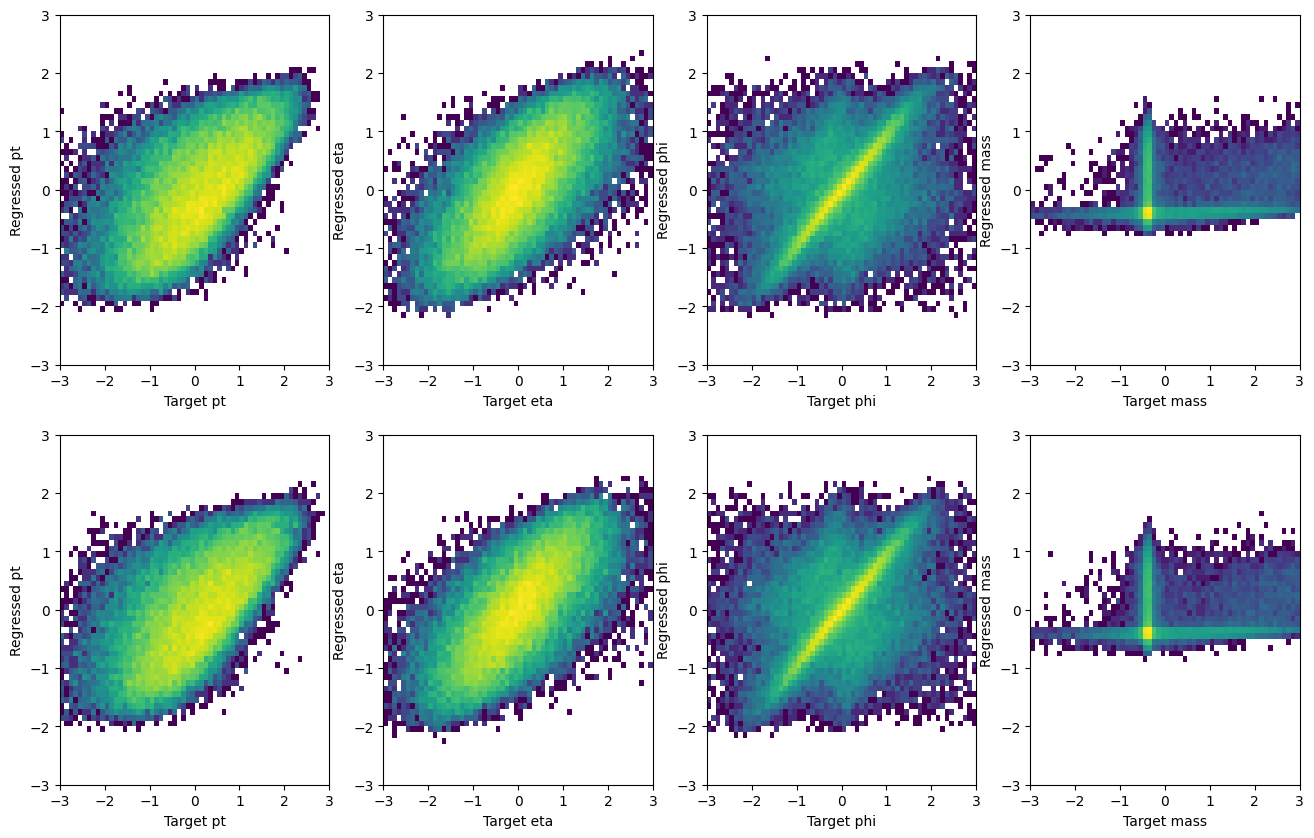

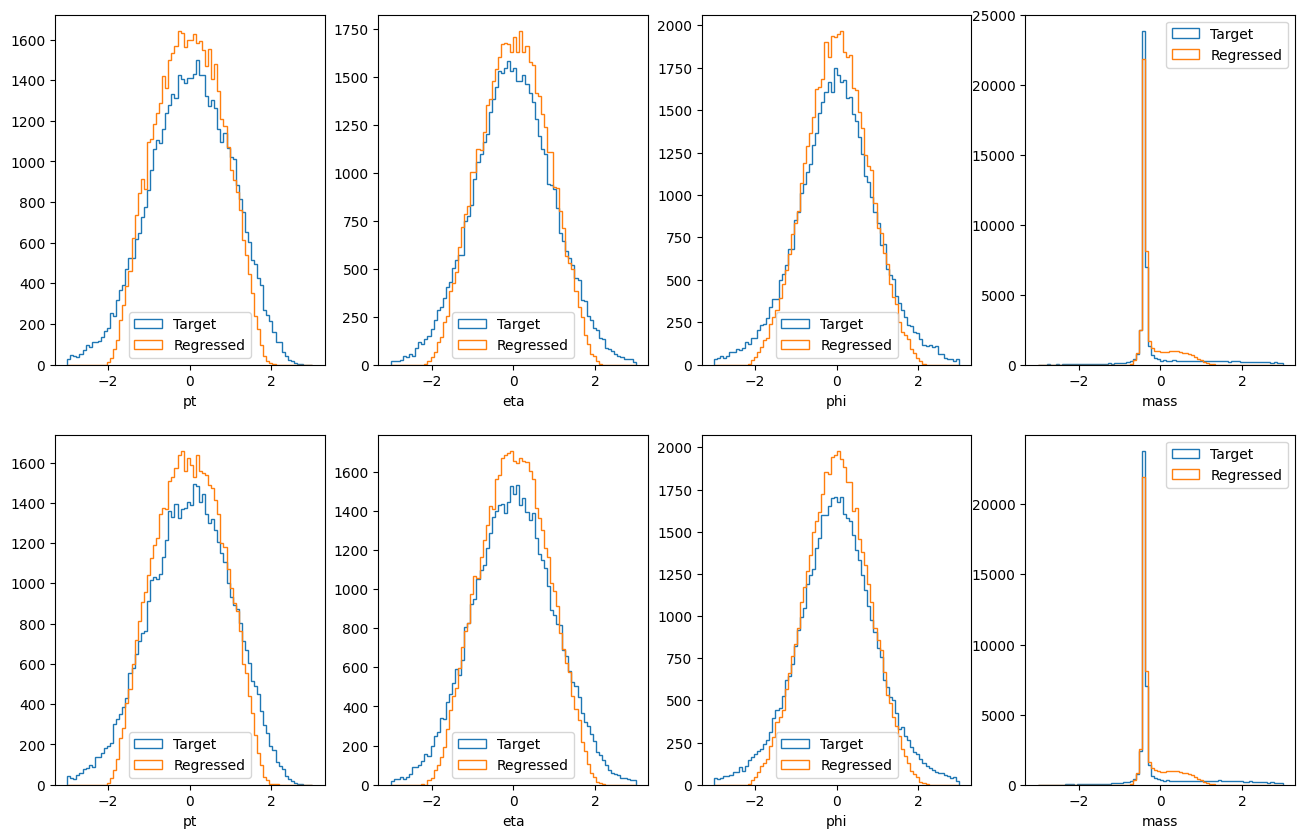

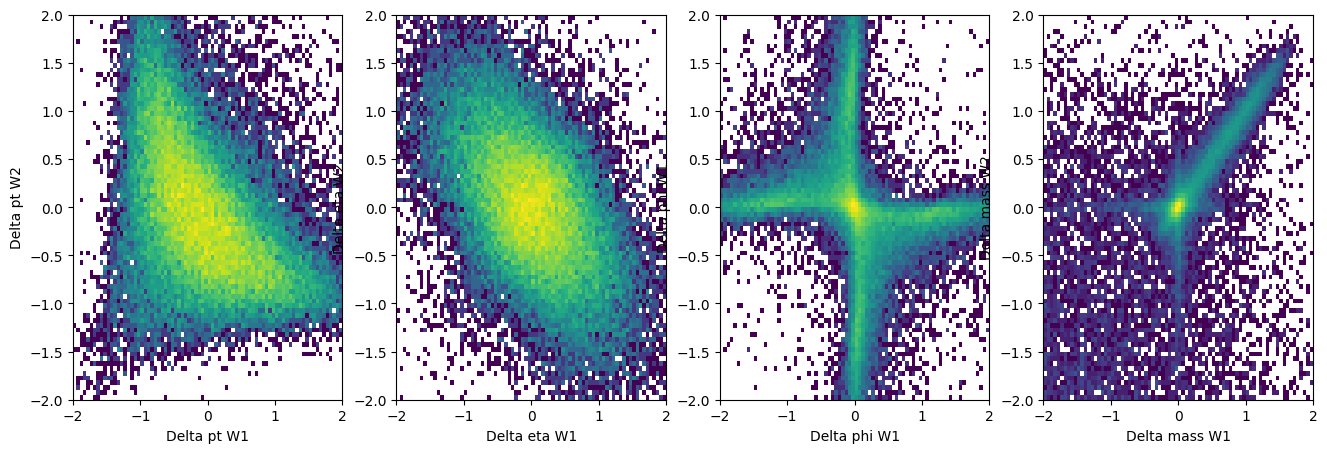

In [32]:
validation_plots(W, W_out)

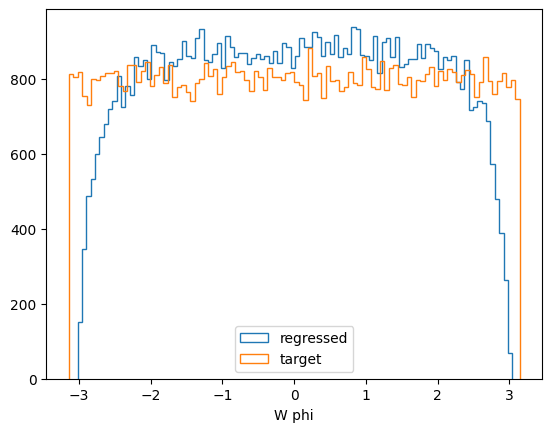

In [49]:
plt.hist(unscale_phi(W_out[:,:,2]).cpu().numpy().flatten(), 
         bins=100, histtype="step", label="regressed")
plt.hist(unscale_phi(W[:,:,2]).cpu().numpy().flatten(), 
         bins=100, histtype="step", label="target")
plt.legend()
plt.xlabel("W phi");

In [50]:
torch.save(model.state_dict(), "models/model_wwregress_mmd_phiperiodic.pt")

# Constrained optimization

We would like to have an even lower value of the MMD loss to fully match the distributions of the target W bosons. 
The problem is that the scale of the MMD loss is now much lower than the value of the regression loss. 
The optimizer won't focus on the MMD loss at this level in the numerial optimization of the loss. 

In order to constraint the distribution even more we should give more weight to the MMD loss. A common solution is to just increase the *relative weight* of the MMD loss in the total loss: 
$$ loss = loss_{regr} + \lambda \cdot loss_{MMD}$$.

This solution is usually fine, but optimizing for the best value of $\lambda$ can be problematic (see slides). 

A more stable and consistent solution is using the *Modified Differential Multiplier Method* (mdmm) [article](https://www.engraved.blog/how-we-can-make-machine-learning-algorithms-tunable/). See slides for full explanation.


In [46]:
def compute_MMD_loss(W_x, W_y):
    mmds = []
    for p in range(2):
        for i in range(4):
            mmds.append(MMD(W_y[:,p,i:i+1], W_x[:,p,i:i+1], kernel="multiscale", device=W_x.device, dtype=W_x.dtype))
    return sum(mmds)/8

def compute_regr_loss(W_x, W_y, loss_fn):
    return loss_fn(W_x[:,:,0:2], W_y[:,:,0:2]).nanmean() +\
                 loss_fn(W_x[:,:,3], W_y[:,:,3]).nanmean() + \
                 phi_loss(W_x[:,:,2], W_y[:,:,2], loss_fn).nanmean()
    

In [47]:
def train_withMMD_philoss_mdmmconstraint(model, MDMM_module, device, loader, val_loader,  optimizer, criterion, epochs, experiment=None):
    for epoch in range(epochs):
        model.train()
        for batch_idx, (jets, lepton, met, full_mask, nu, W) in enumerate(loader):
            
            optimizer.zero_grad()
            W_out = model(jets, lepton, met, full_mask)
            mask_nan = torch.isnan(W_out).any(axis=(1,2))
            mask_notnan = ~mask_nan

            loss_regr = compute_regr_loss(W_out, W, criterion)
            # Now using MDMM for the MMD loss
            mdmm_return = MDMM_module(loss_regr, [(W_out[mask_notnan], W[mask_notnan])])
            # Using the output of the MDMM module as the total loss to optimize --> this includes the modified constraint terms
            loss = mdmm_return.value
            # Getting the MDMM value anyway to log it 
            MMD_loss = compute_MMD_loss(W_out[mask_notnan], W[mask_notnan])
            
            if batch_idx % 100 == 0:
                print(f"epoch {epoch}, step {batch_idx}, Loss: {loss.item():.4f}, loss regr: {loss_regr.item():.4f},  MMD total: {MMD_loss.item():.4f} ")
                if exp:
                   experiment.log_metric("train_loss_step", loss.item(), step=batch_idx)
                    
            loss.backward()
            optimizer.step()
            
        # Log metrics
        if experiment:
            experiment.log_metric("train_loss_epoch", loss.item(), step=epoch)
        
        # Validation loss
        #model.eval()  #I'm having problems with model.eval
        val_loss = 0.  
        val_loss_regr = 0.
        val_loss_mmd = 0.
        
        with torch.no_grad():
            for jets_val, lepton_val, met_val ,full_mask_val, nu_val, W_val in val_loader:
                W_out_val = model(jets_val, lepton_val, met_val, full_mask_val)
       
                mask_nan_val = torch.isnan(W_out_val).any(axis=(1,2))
                mask_notnan_val = ~mask_nan_val
                MMD_loss_val = compute_MMD_loss(W_out_val[mask_notnan_val], W_val[mask_notnan_val])
                
                loss_regr_val = compute_regr_loss(W_out_val, W_val, criterion)
                    
                val_loss += (loss_regr_val +  MMD_loss_val).item()
                val_loss_regr += loss_regr_val.item()
                val_loss_mmd += MMD_loss_val.item()
                
            val_loss = val_loss / len(val_loader)
            val_loss_regr = val_loss_regr / len(val_loader)
            val_loss_mmd = val_loss_mmd / len(val_loader)
            
            if experiment:
                experiment.log_metric("val_loss_epoch", val_loss.item(), step=epoch)
            print(f"epoch {epoch}, Validation Loss: {val_loss:.4f}, loss regr: {val_loss_regr:.4f},  MMD total: {val_loss_mmd:.4f}")

            #print for one batch
            _ = validation_plots(W_val, W_out_val)
            plt.show()
            
        print(f"End of epoch {epoch}")
    return model

In [48]:
datafolder = "/eos/user/d/dvalsecc/EFT_PhD_Course/training_datasets"

# Usage example
input_paths_training = [ f"{datafolder}/{f}_training.npy" for f in ["jet_data", "lepton_data", "met_data","jetlepmet_padding_mask",  "nu_data", "W_data"]]
input_paths_validation = [ f"{datafolder}/{f}_validation.npy" for f in ["jet_data", "lepton_data", "met_data","jetlepmet_padding_mask", "nu_data", "W_data"]]

dataset_train = dataloader.ChunkedNumpyDataset(input_paths_training, max_events=400000, device="cuda")
dataset_val  = dataloader.ChunkedNumpyDataset(input_paths_validation, max_events=200000, device="cuda")

# Create DataLoader
batch_size = 1024
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=False)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size*6, shuffle=False)

The preparation of the optimize is different to use the mdmm code.

Many types of constraints can be specified.  In this case we use a MAX constraint. 
The loss will be increased if the small MMD value is not reached during the training. 

epoch 0, step 0, Loss: 28.1715, loss regr: 2.6842,  MMD total: 1.5975 
epoch 0, step 100, Loss: 3.0790, loss regr: 2.8804,  MMD total: 0.1070 
epoch 0, step 200, Loss: 2.7836, loss regr: 2.6417,  MMD total: 0.0750 
epoch 0, step 300, Loss: 2.7503, loss regr: 2.6029,  MMD total: 0.0687 
epoch 0, Validation Loss: 2.4847, loss regr: 2.4385,  MMD total: 0.0462


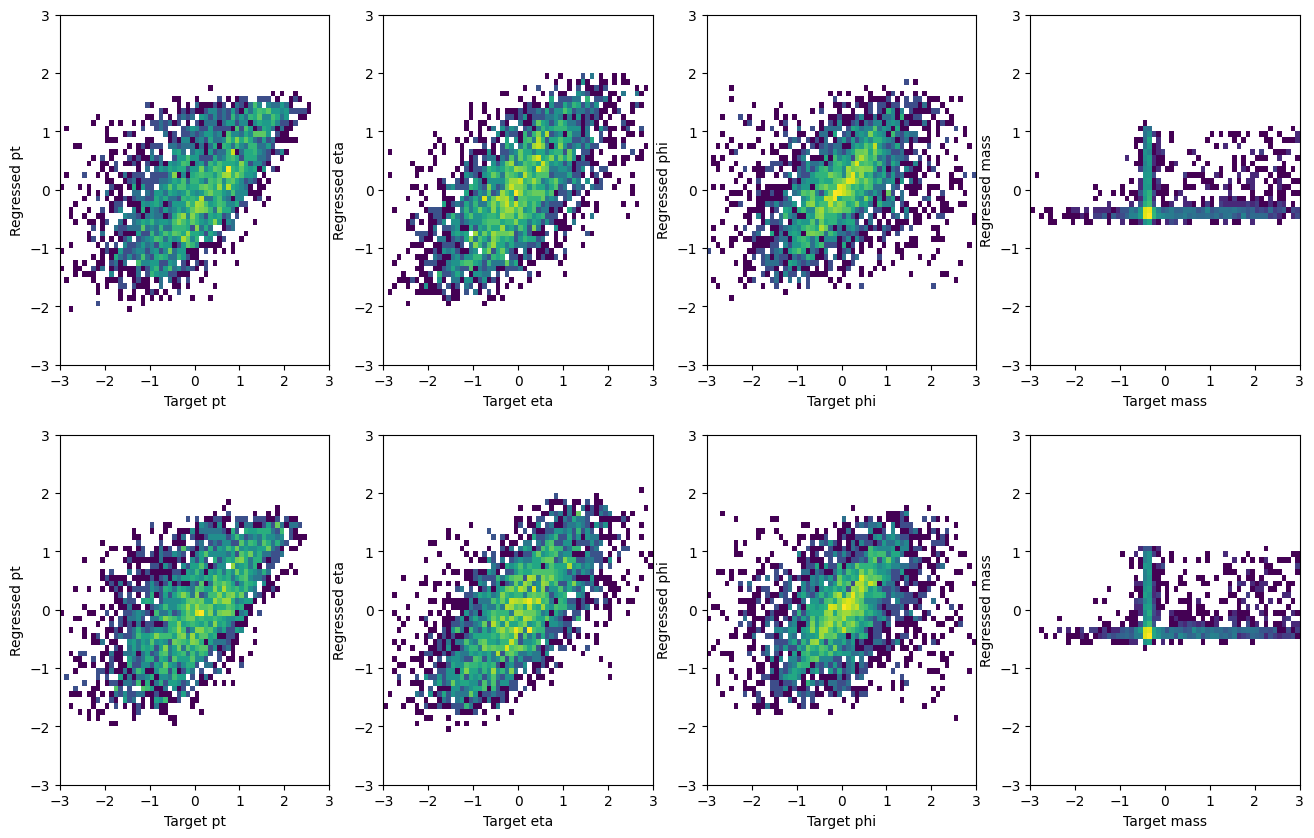

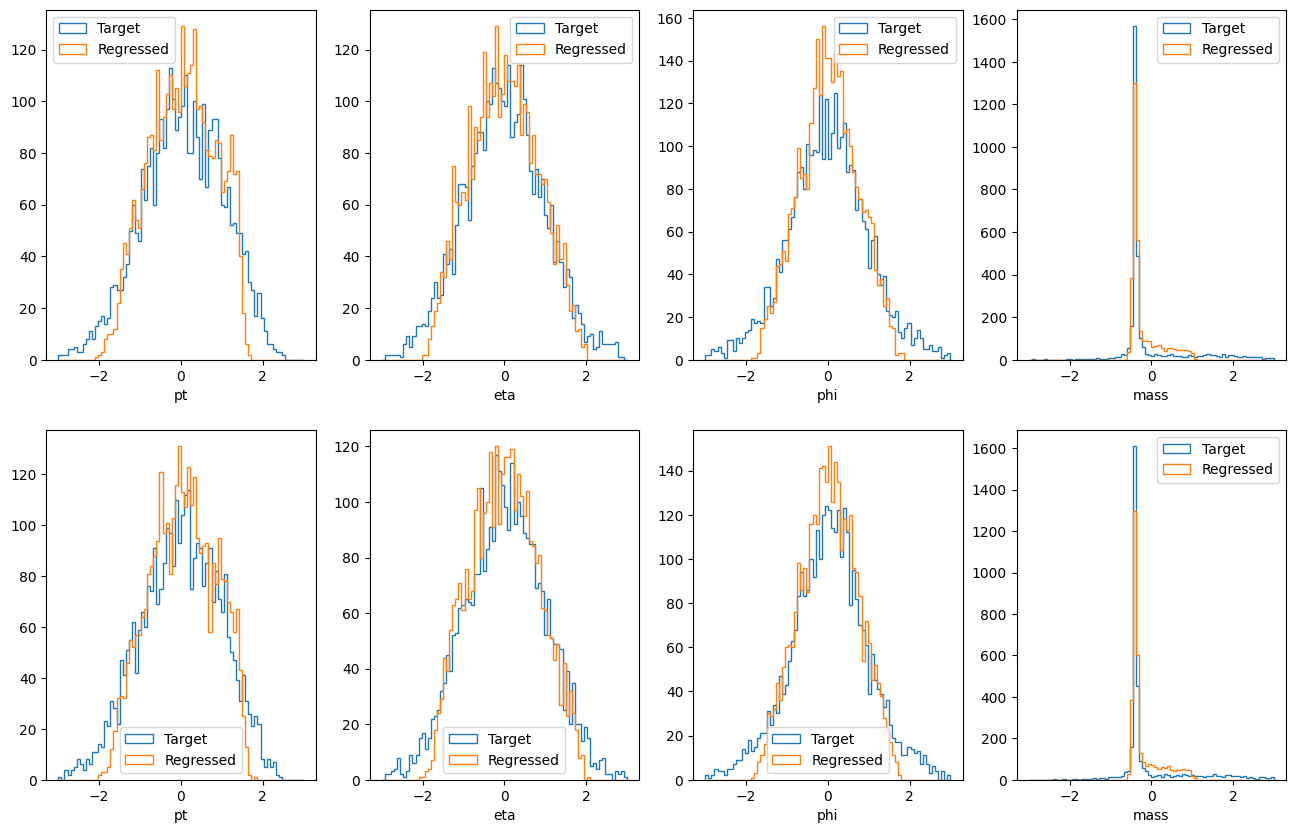

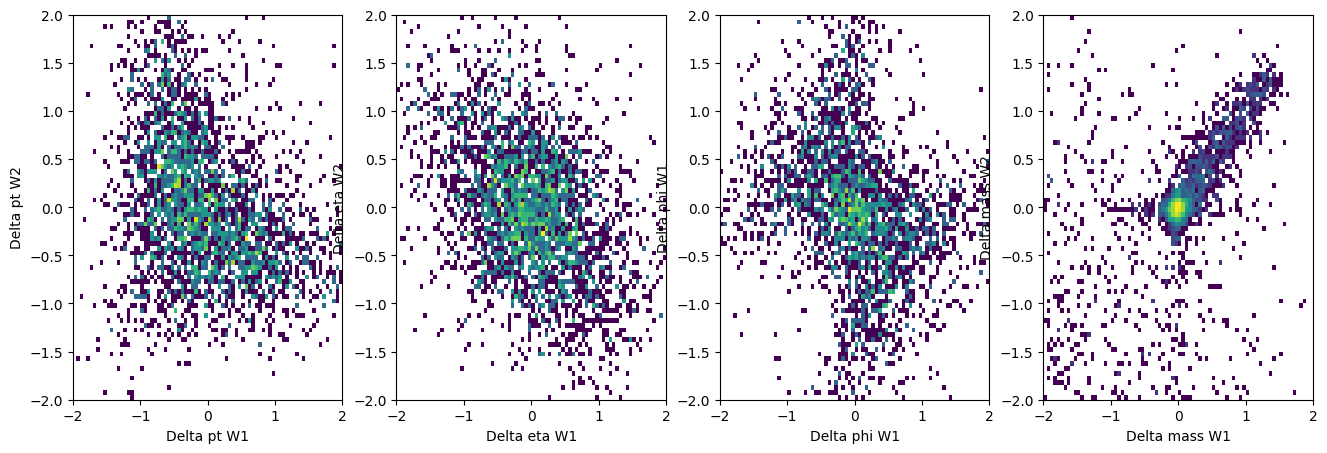

End of epoch 0
epoch 1, step 0, Loss: 2.4910, loss regr: 2.3833,  MMD total: 0.0480 
epoch 1, step 100, Loss: 2.5237, loss regr: 2.3920,  MMD total: 0.0502 
epoch 1, step 200, Loss: 2.4854, loss regr: 2.3482,  MMD total: 0.0463 
epoch 1, step 300, Loss: 2.6609, loss regr: 2.5181,  MMD total: 0.0432 
epoch 1, Validation Loss: 2.3786, loss regr: 2.3489,  MMD total: 0.0297


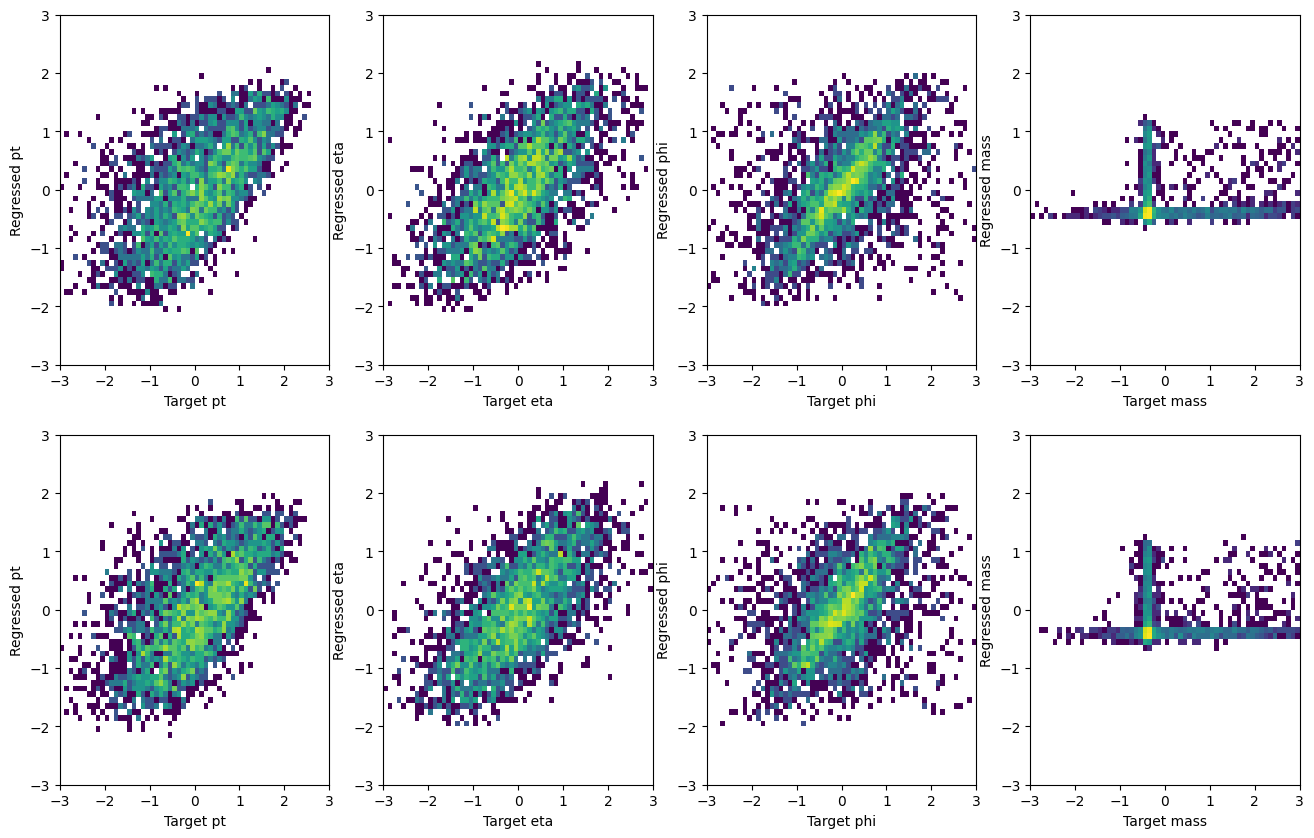

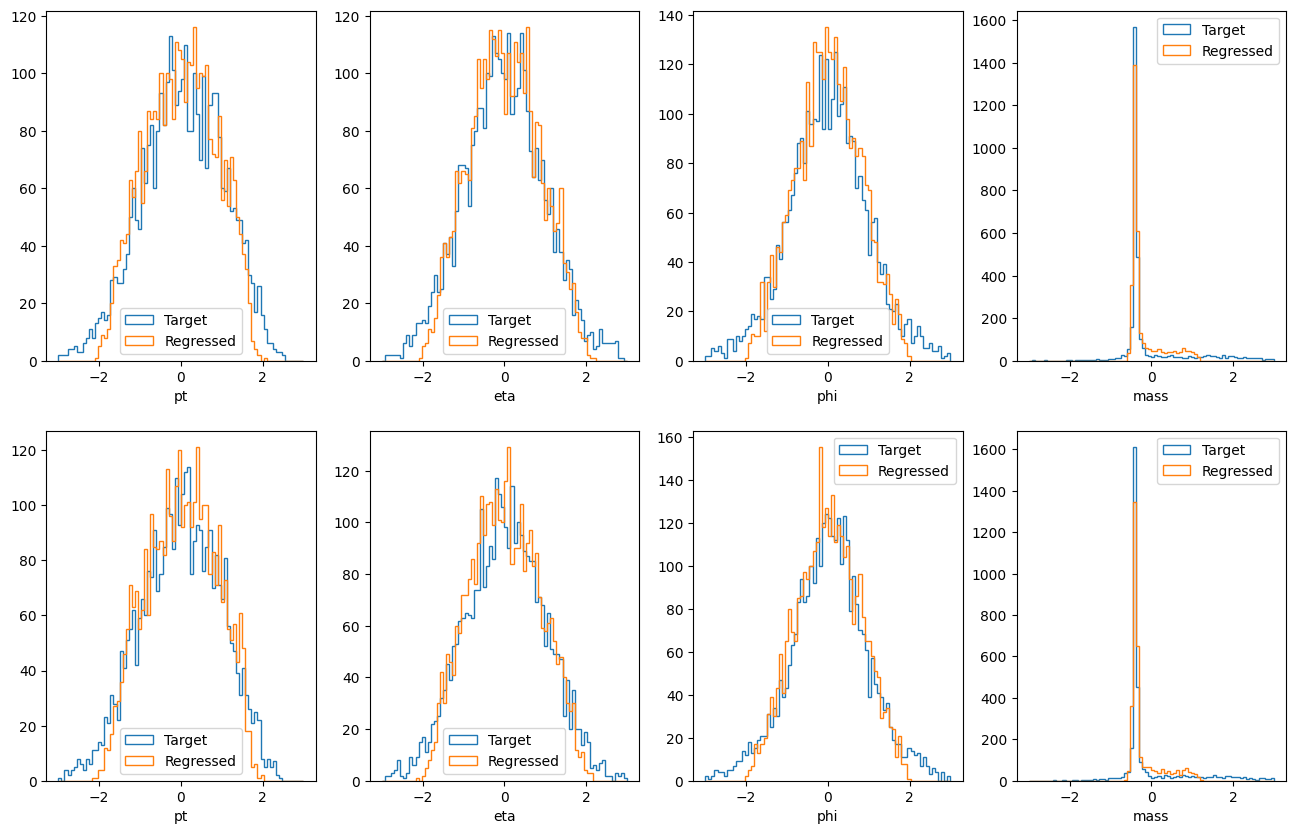

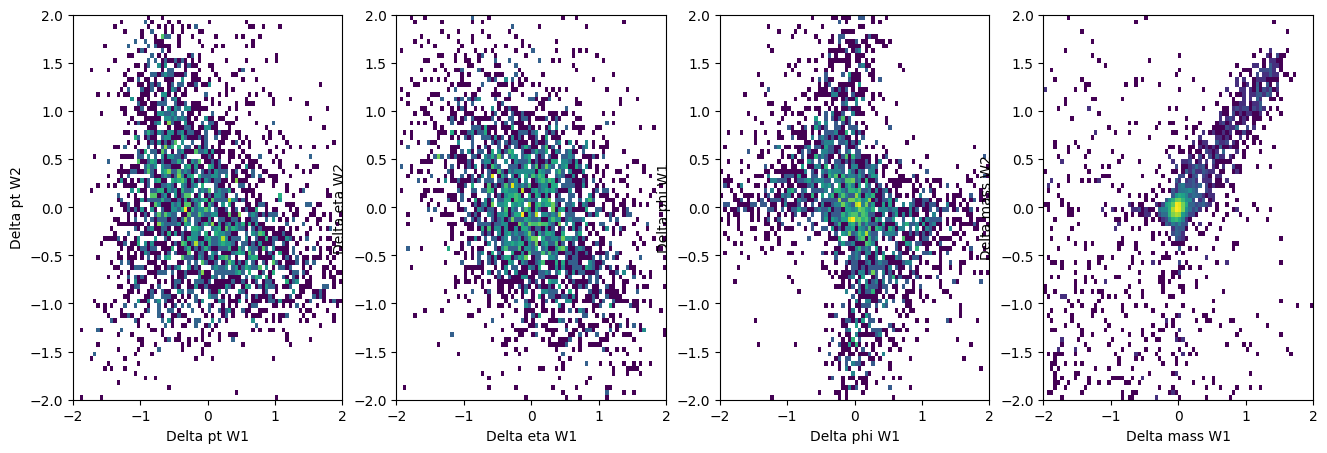

End of epoch 1
epoch 2, step 0, Loss: 2.3954, loss regr: 2.2858,  MMD total: 0.0311 
epoch 2, step 100, Loss: 2.4531, loss regr: 2.3022,  MMD total: 0.0377 
epoch 2, step 200, Loss: 2.4793, loss regr: 2.3121,  MMD total: 0.0378 
epoch 2, step 300, Loss: 2.6517, loss regr: 2.4824,  MMD total: 0.0352 
epoch 2, Validation Loss: 2.3438, loss regr: 2.3197,  MMD total: 0.0241


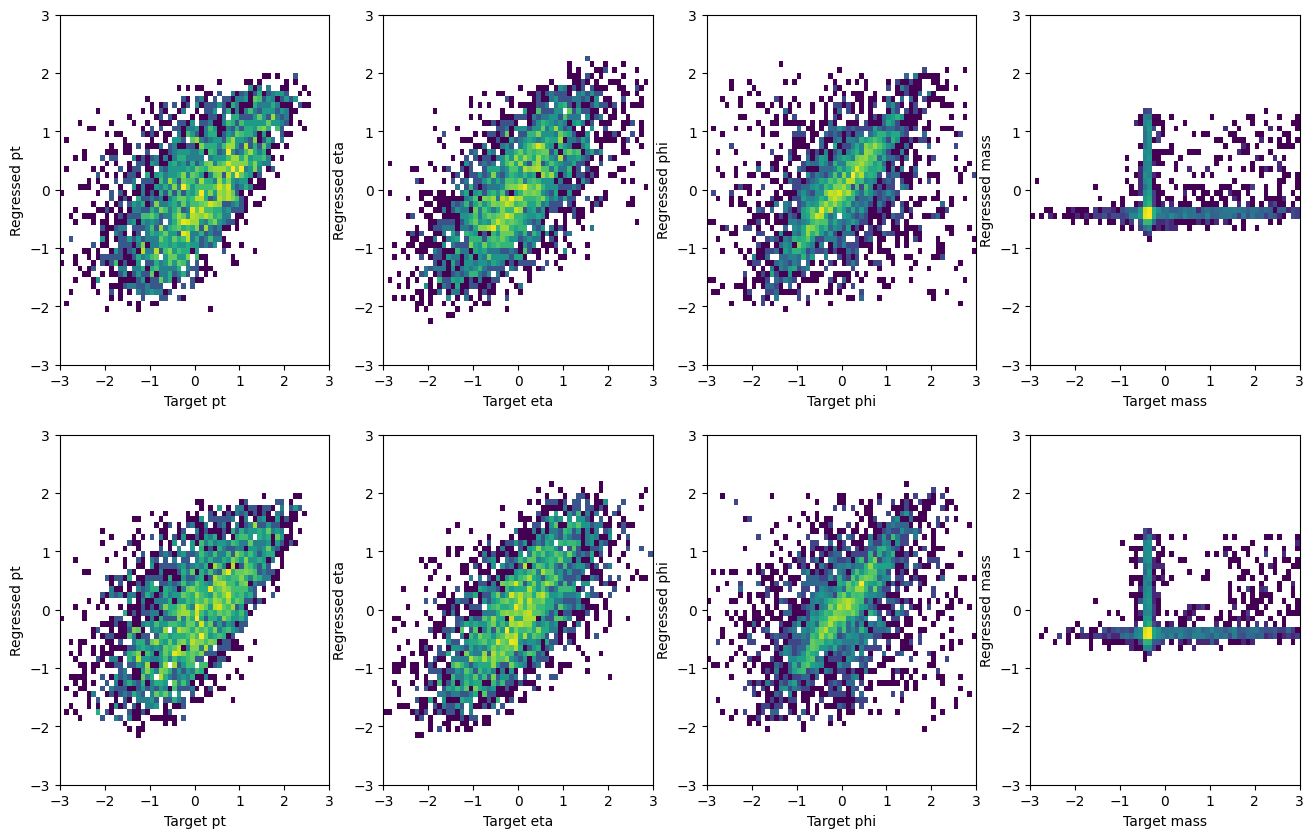

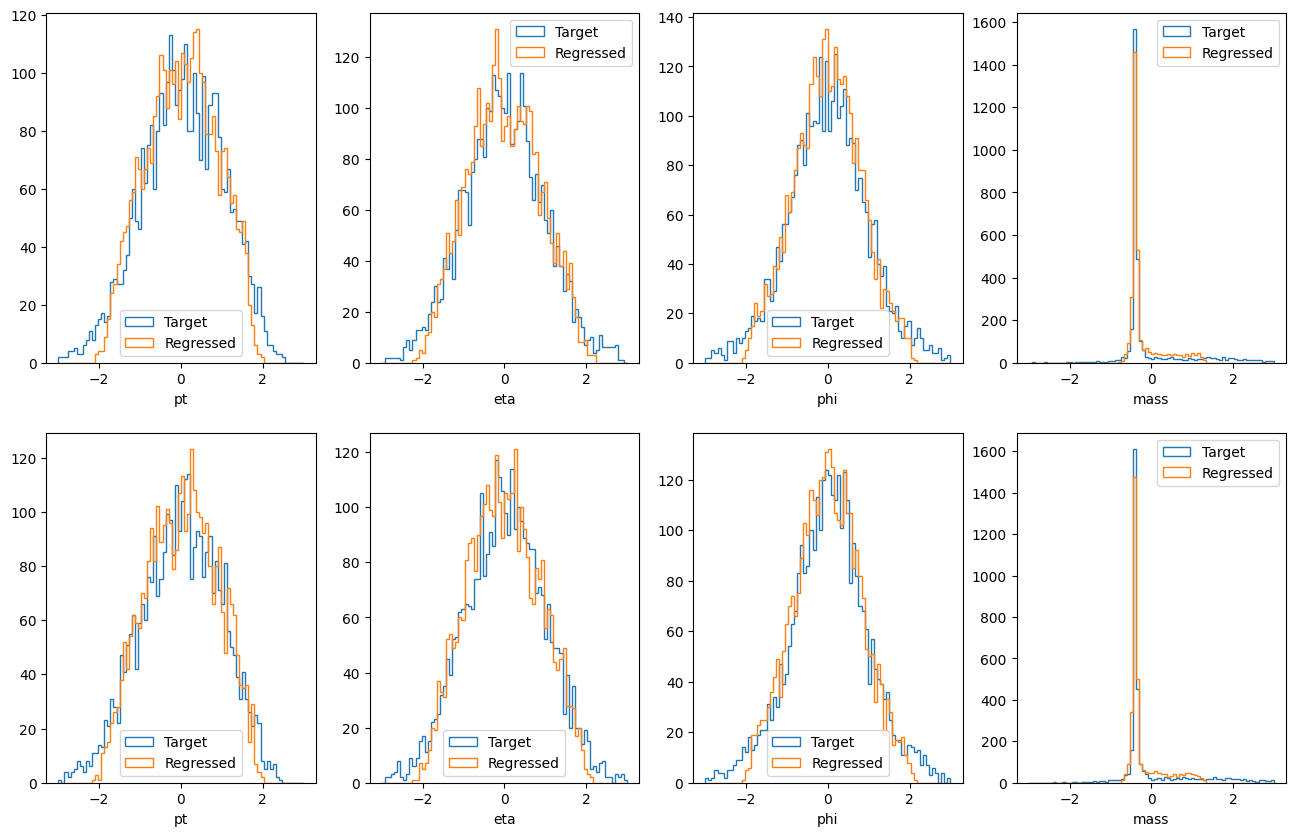

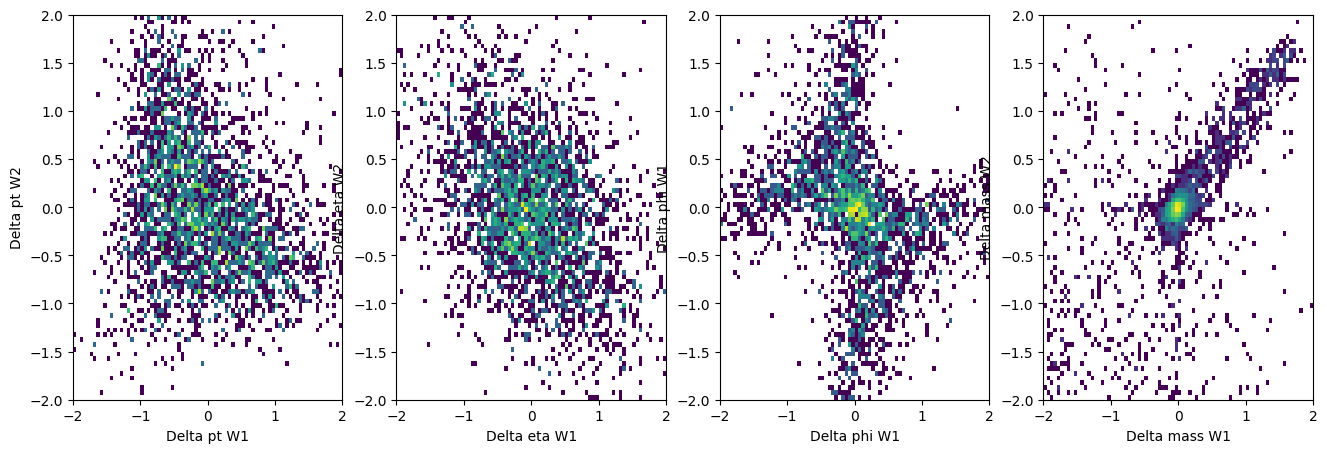

End of epoch 2
epoch 3, step 0, Loss: 2.3833, loss regr: 2.2490,  MMD total: 0.0265 
epoch 3, step 100, Loss: 2.4242, loss regr: 2.2697,  MMD total: 0.0279 
epoch 3, step 200, Loss: 2.4893, loss regr: 2.3029,  MMD total: 0.0309 
epoch 3, step 300, Loss: 2.6223, loss regr: 2.4398,  MMD total: 0.0284 
epoch 3, Validation Loss: 2.3163, loss regr: 2.2982,  MMD total: 0.0181


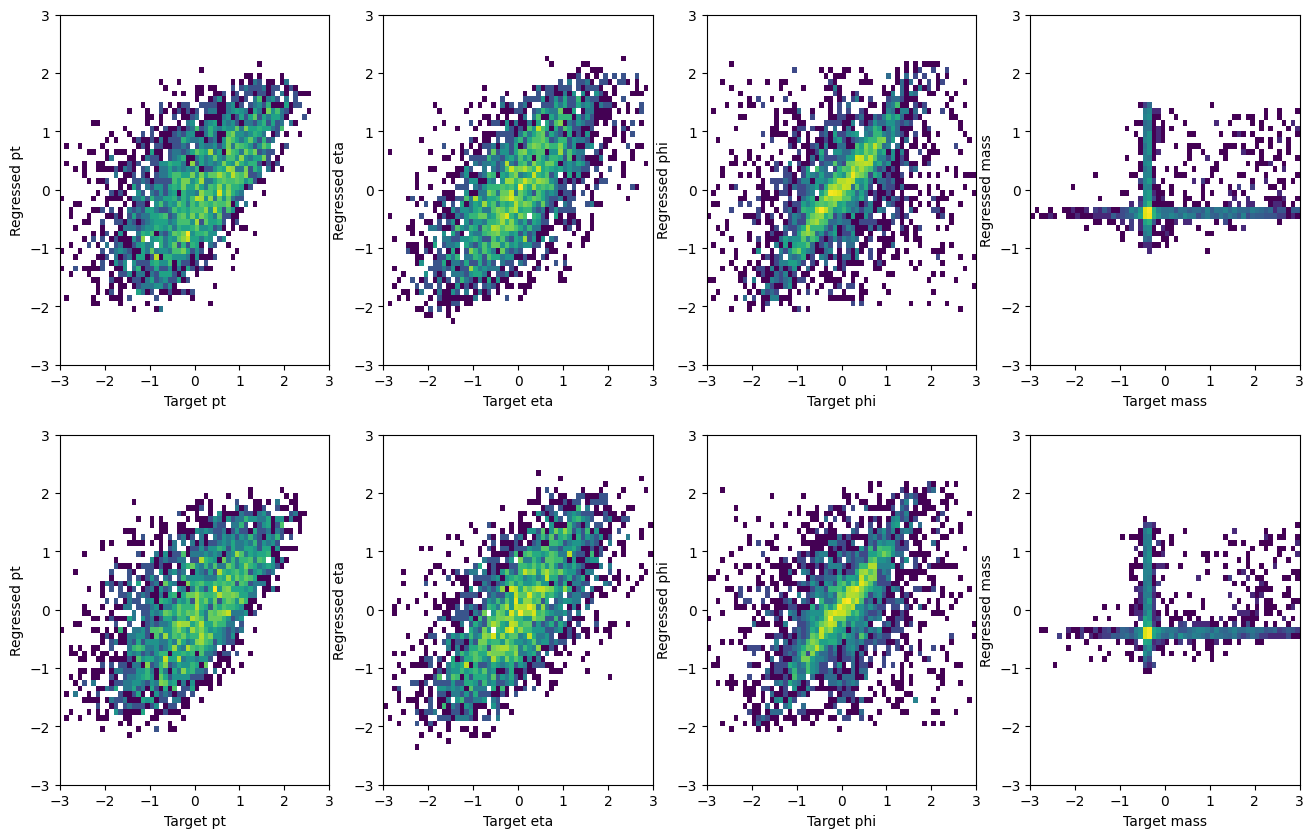

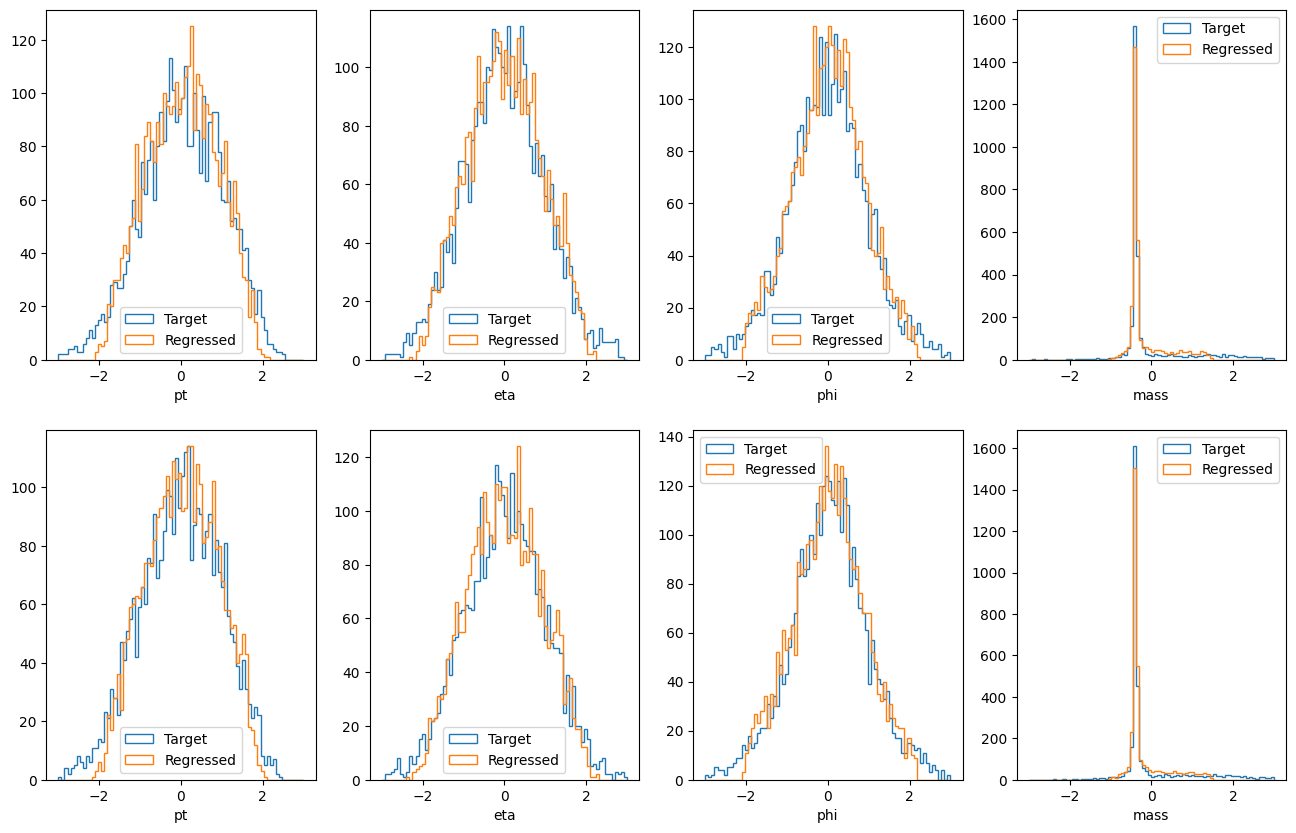

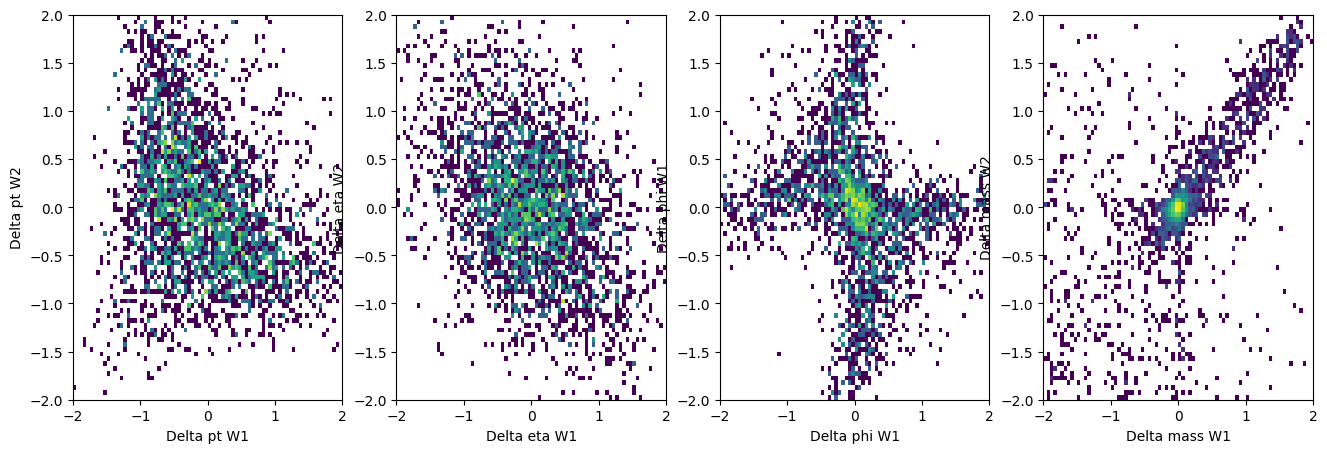

End of epoch 3
epoch 4, step 0, Loss: 2.3618, loss regr: 2.2212,  MMD total: 0.0211 
epoch 4, step 100, Loss: 2.4065, loss regr: 2.2271,  MMD total: 0.0248 
epoch 4, step 200, Loss: 2.5015, loss regr: 2.3045,  MMD total: 0.0255 
epoch 4, step 300, Loss: 2.7055, loss regr: 2.4717,  MMD total: 0.0283 
epoch 4, Validation Loss: 2.3195, loss regr: 2.3004,  MMD total: 0.0192


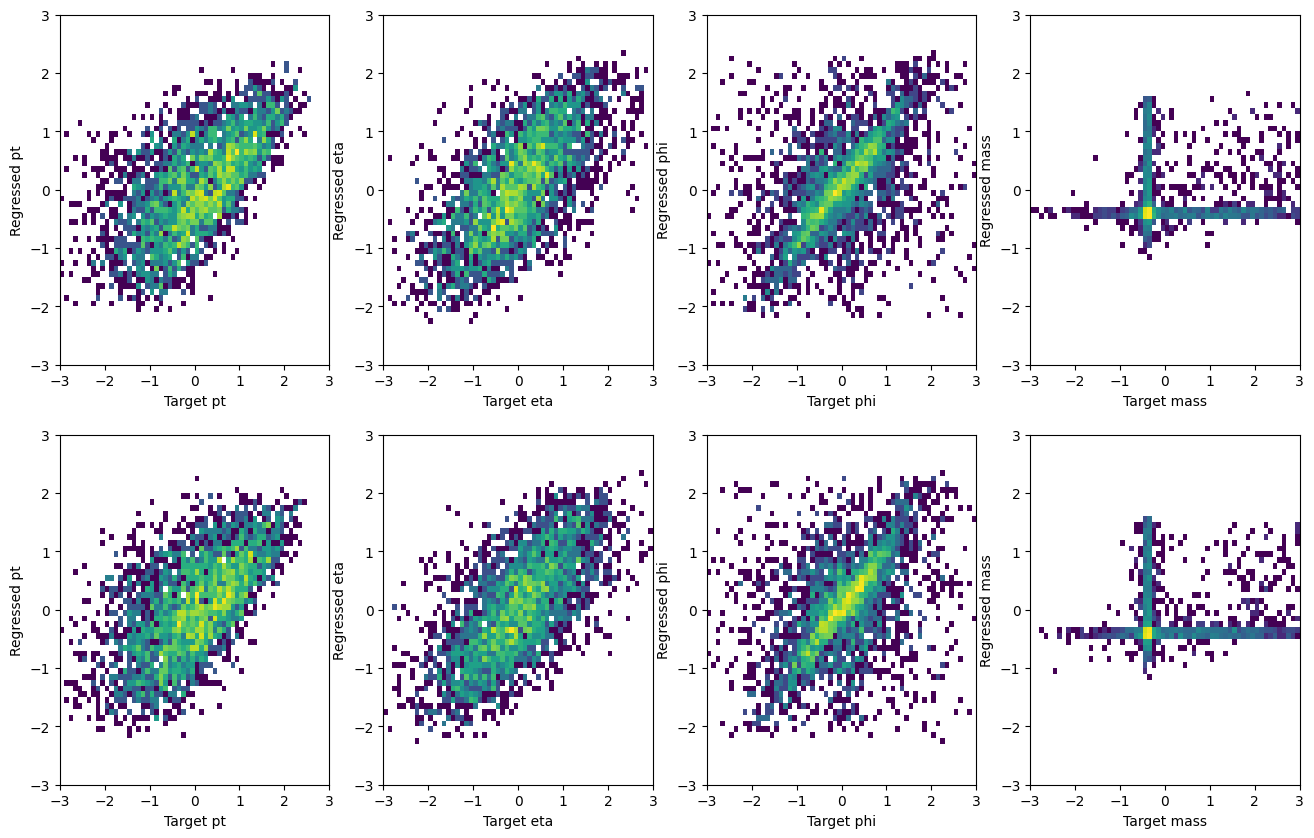

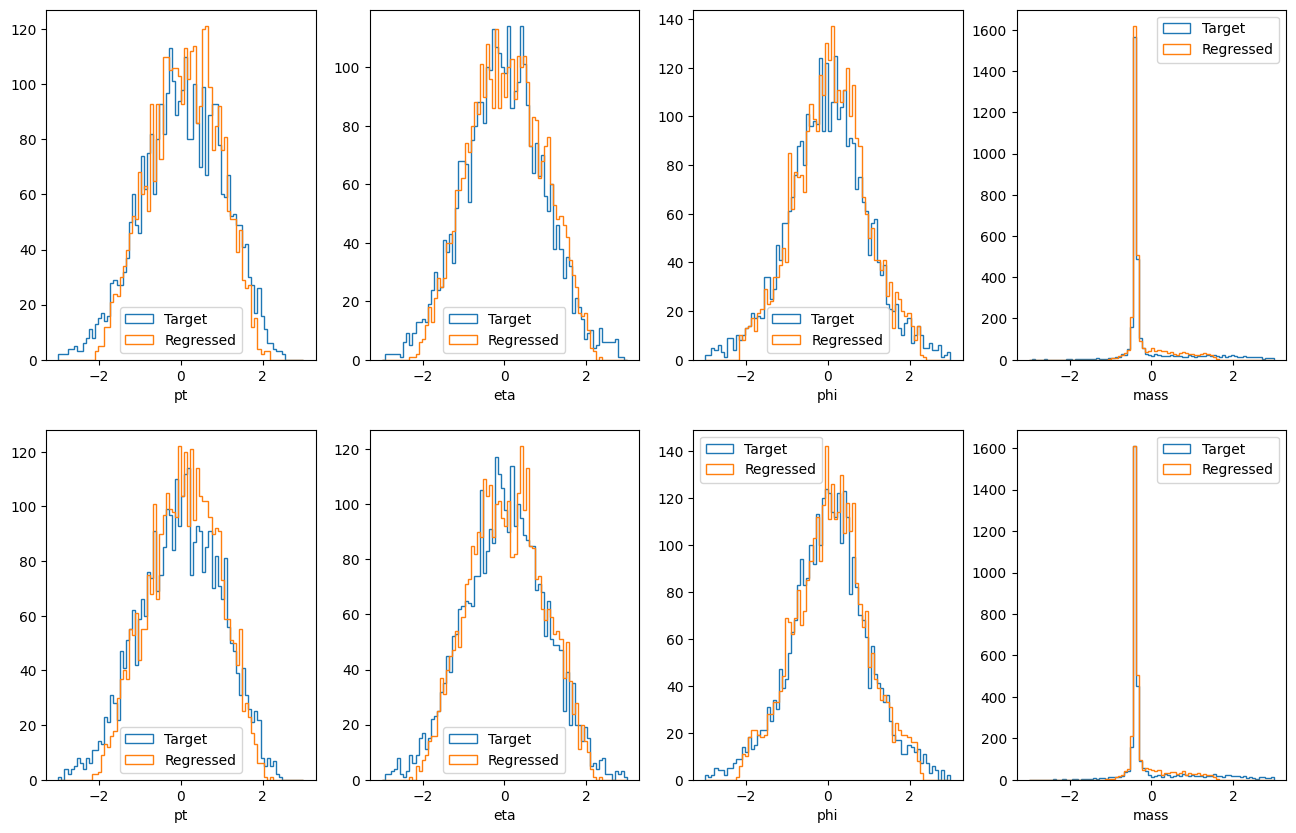

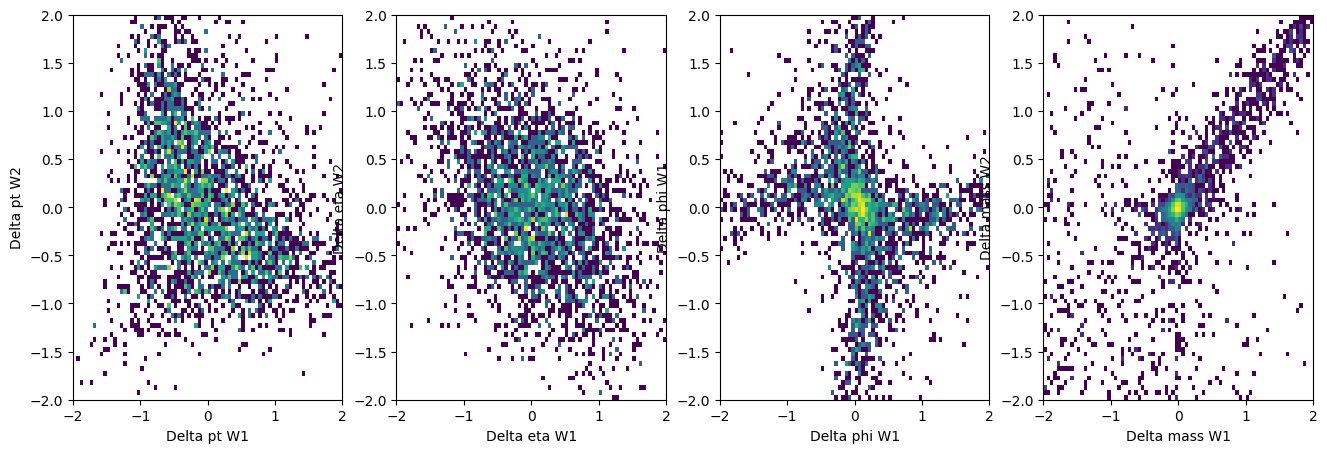

End of epoch 4
epoch 5, step 0, Loss: 2.4440, loss regr: 2.2563,  MMD total: 0.0220 
epoch 5, step 100, Loss: 2.4605, loss regr: 2.2668,  MMD total: 0.0214 
epoch 5, step 200, Loss: 2.5223, loss regr: 2.2731,  MMD total: 0.0258 
epoch 5, step 300, Loss: 2.7100, loss regr: 2.4619,  MMD total: 0.0244 
epoch 5, Validation Loss: 2.2947, loss regr: 2.2785,  MMD total: 0.0163


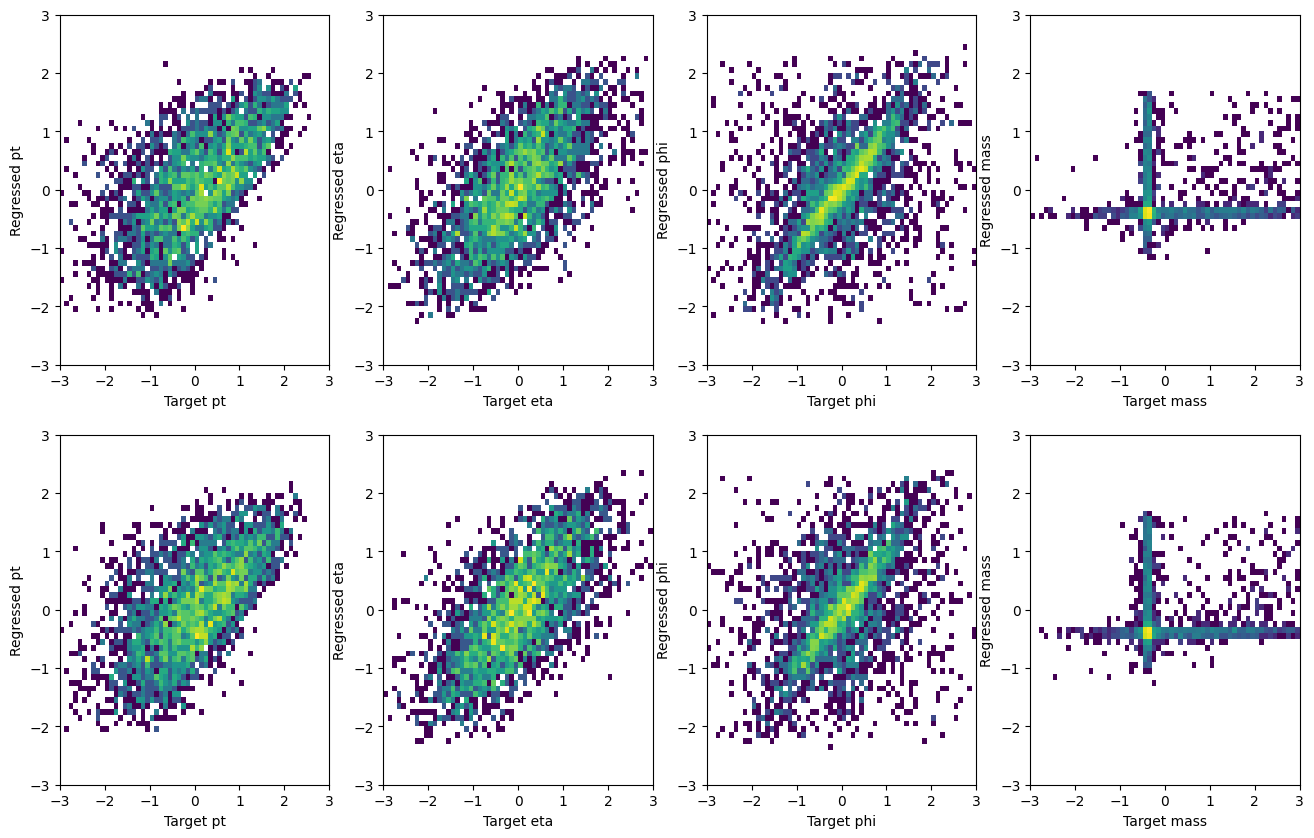

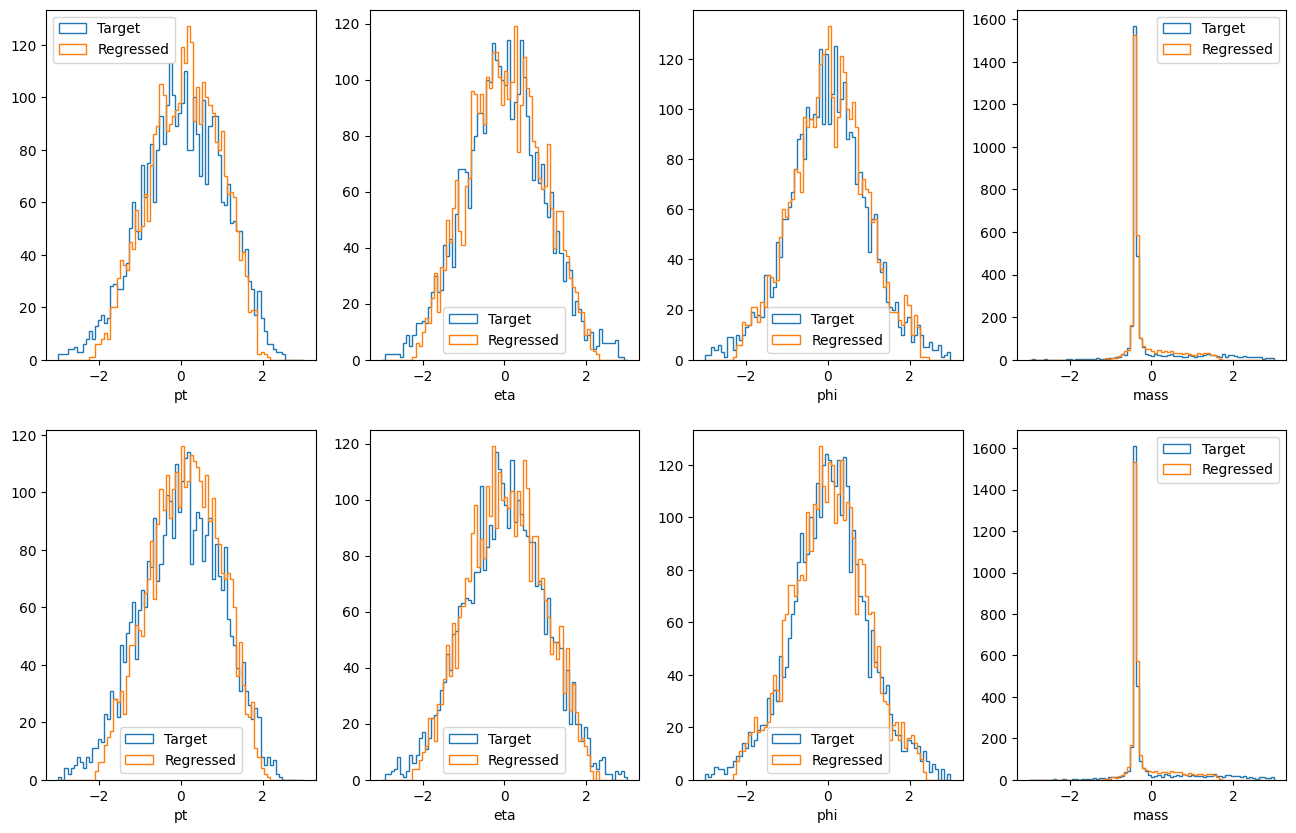

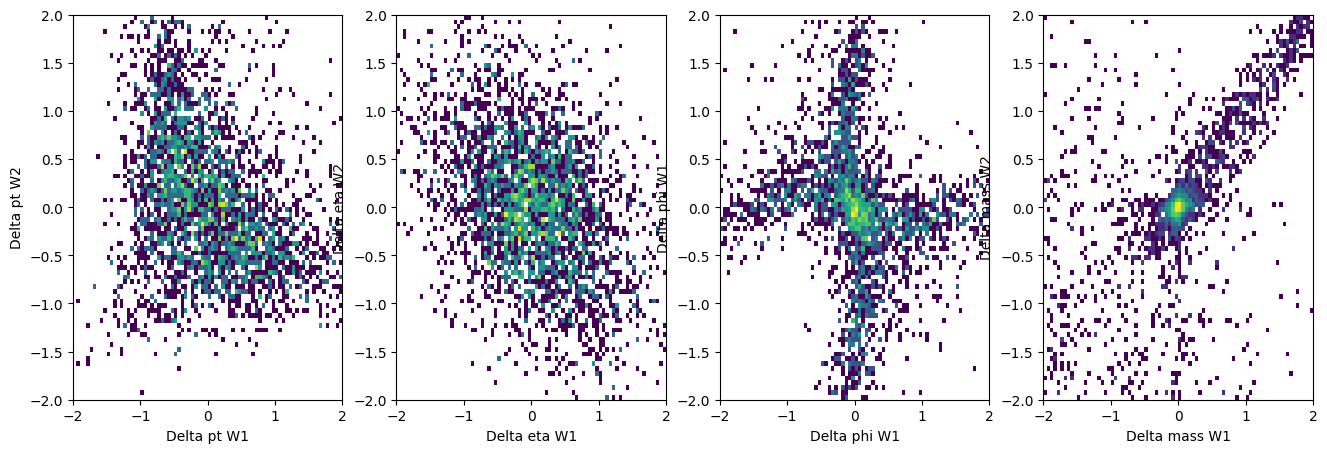

End of epoch 5
epoch 6, step 0, Loss: 2.4144, loss regr: 2.2295,  MMD total: 0.0178 
epoch 6, step 100, Loss: 2.5021, loss regr: 2.2622,  MMD total: 0.0216 
epoch 6, step 200, Loss: 2.6276, loss regr: 2.3379,  MMD total: 0.0246 
epoch 6, step 300, Loss: 2.6797, loss regr: 2.4338,  MMD total: 0.0202 
epoch 6, Validation Loss: 2.3152, loss regr: 2.3021,  MMD total: 0.0131


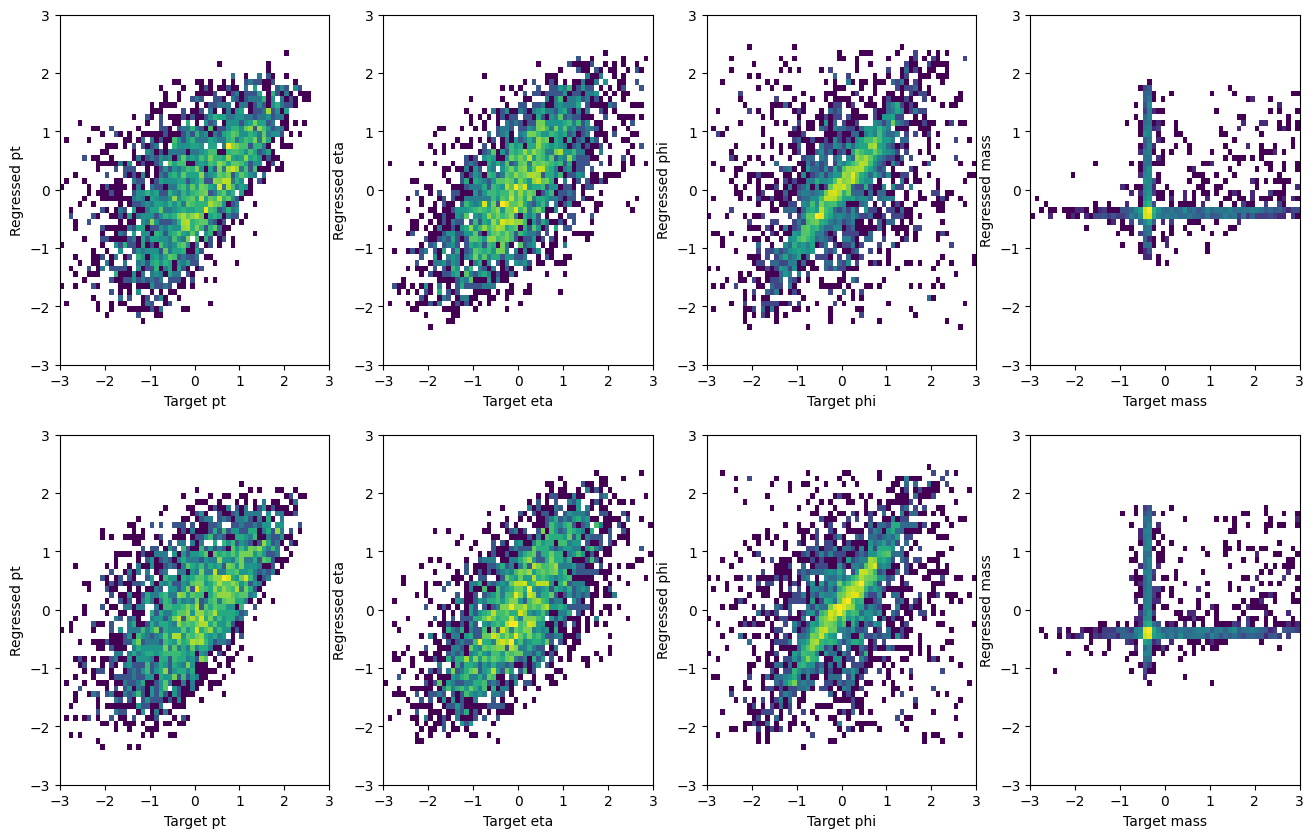

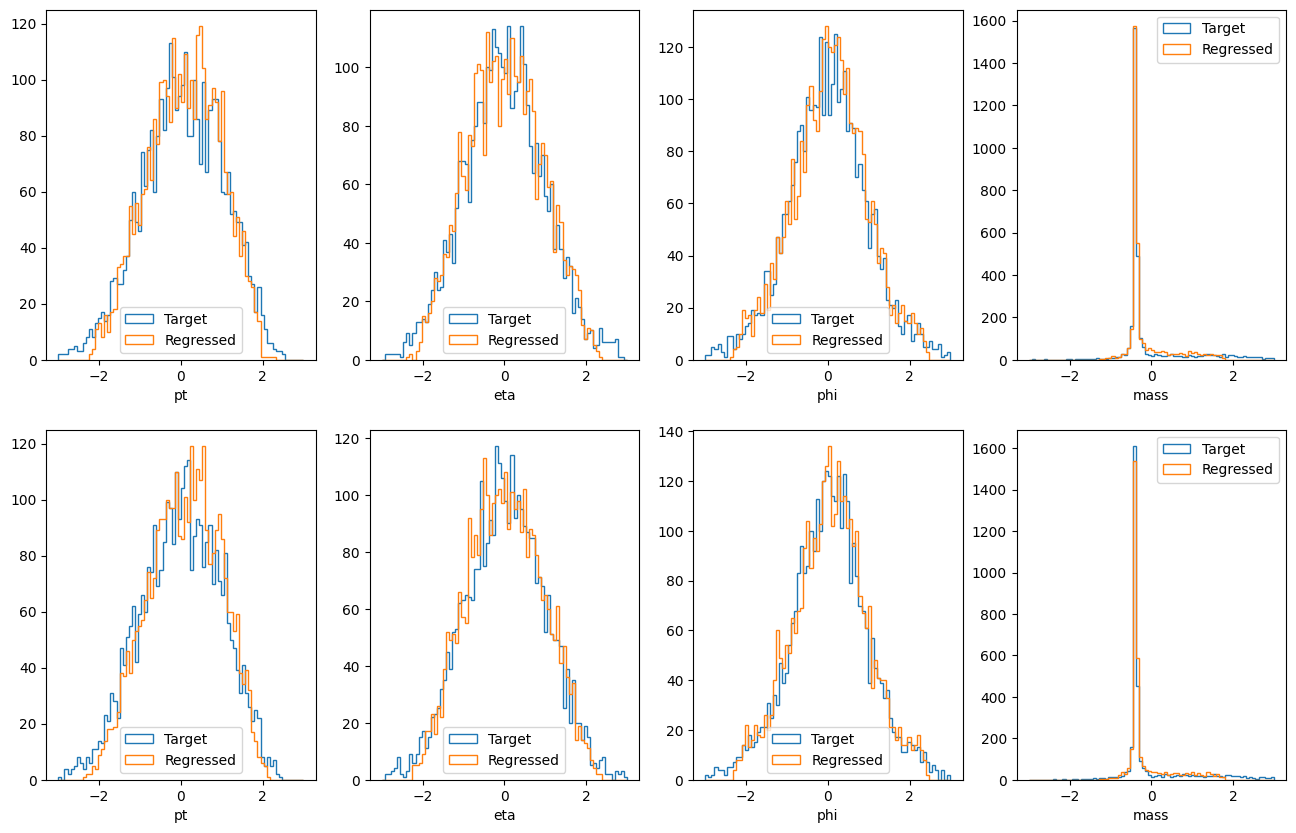

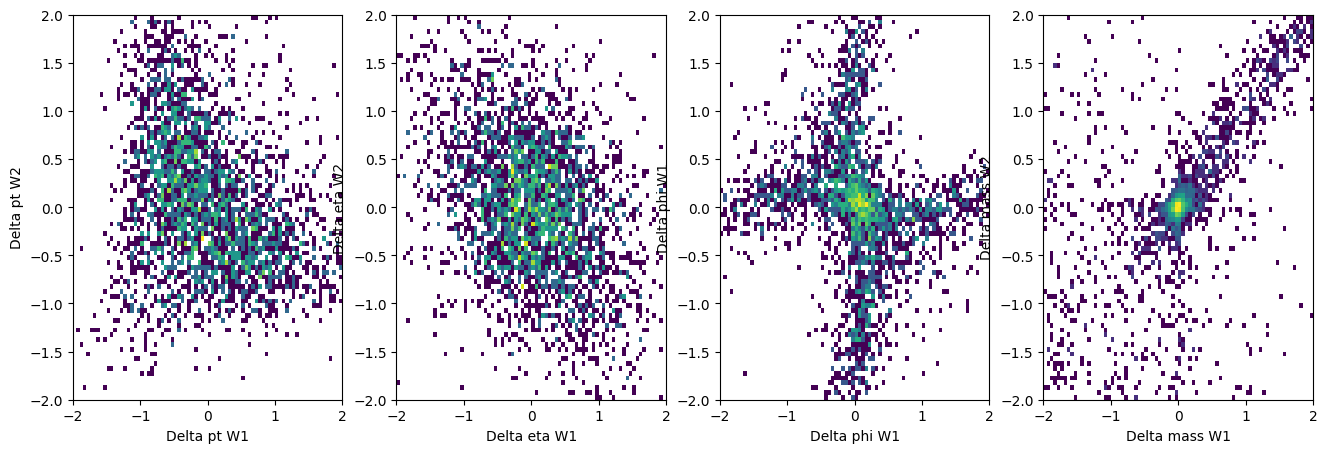

End of epoch 6
epoch 7, step 0, Loss: 2.4360, loss regr: 2.2385,  MMD total: 0.0158 
epoch 7, step 100, Loss: 2.5370, loss regr: 2.2818,  MMD total: 0.0192 
epoch 7, step 200, Loss: 2.5892, loss regr: 2.3042,  MMD total: 0.0204 
epoch 7, step 300, Loss: 2.7038, loss regr: 2.4746,  MMD total: 0.0160 
epoch 7, Validation Loss: 2.3465, loss regr: 2.3359,  MMD total: 0.0106


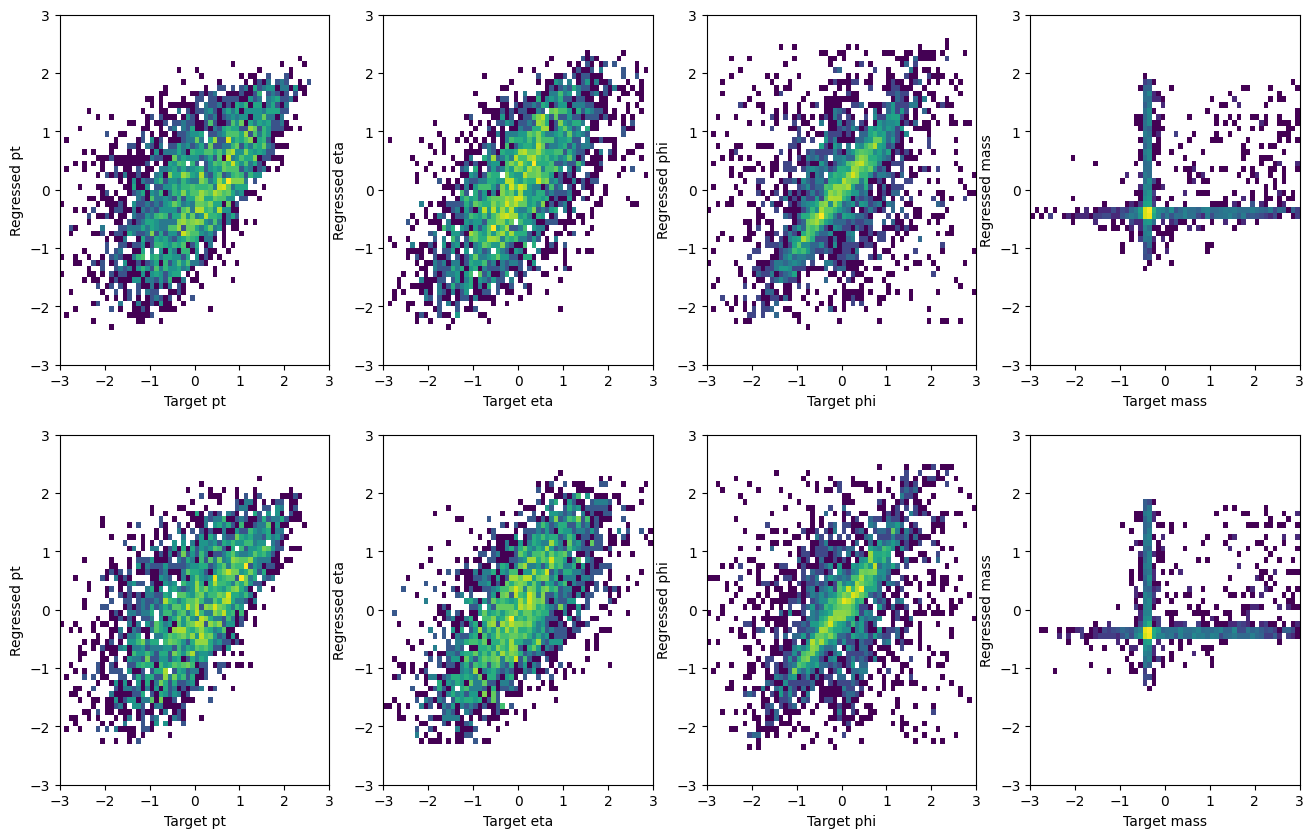

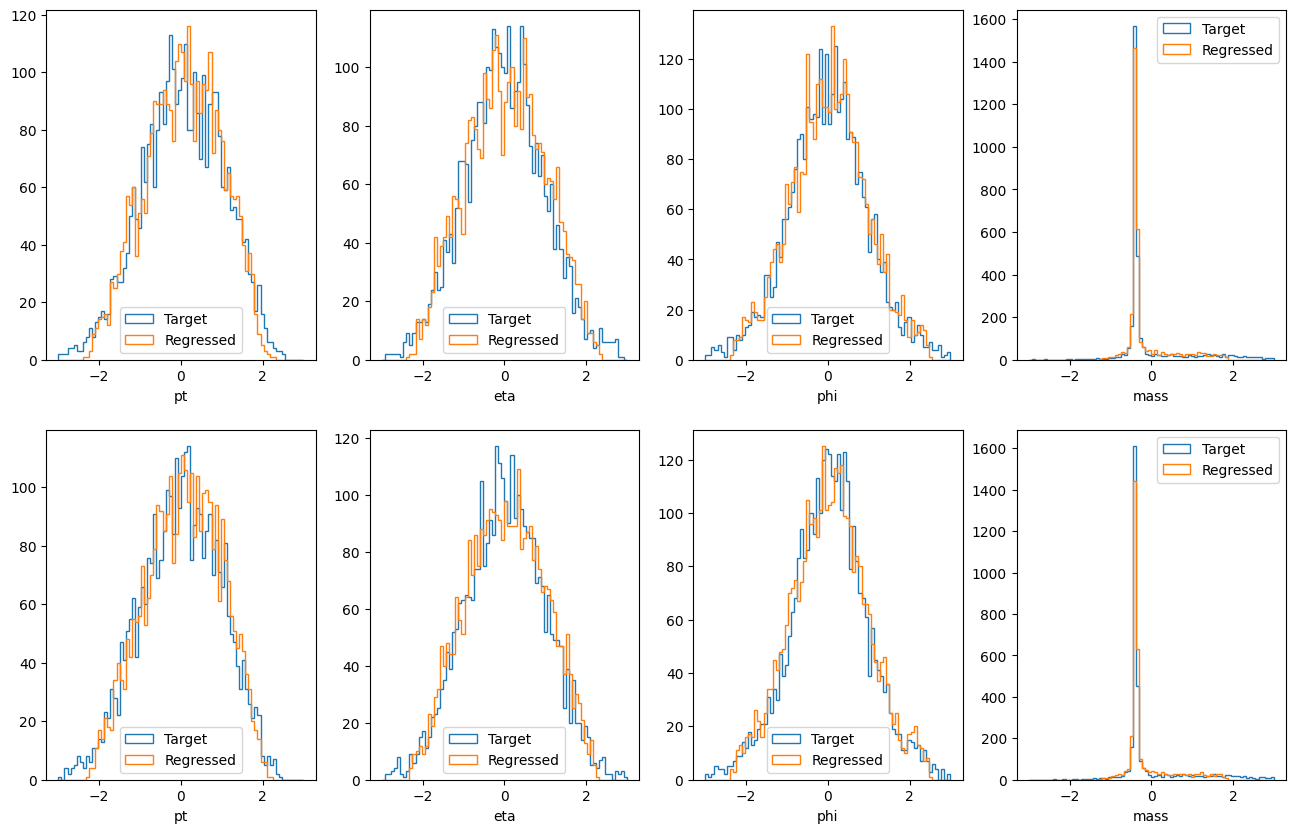

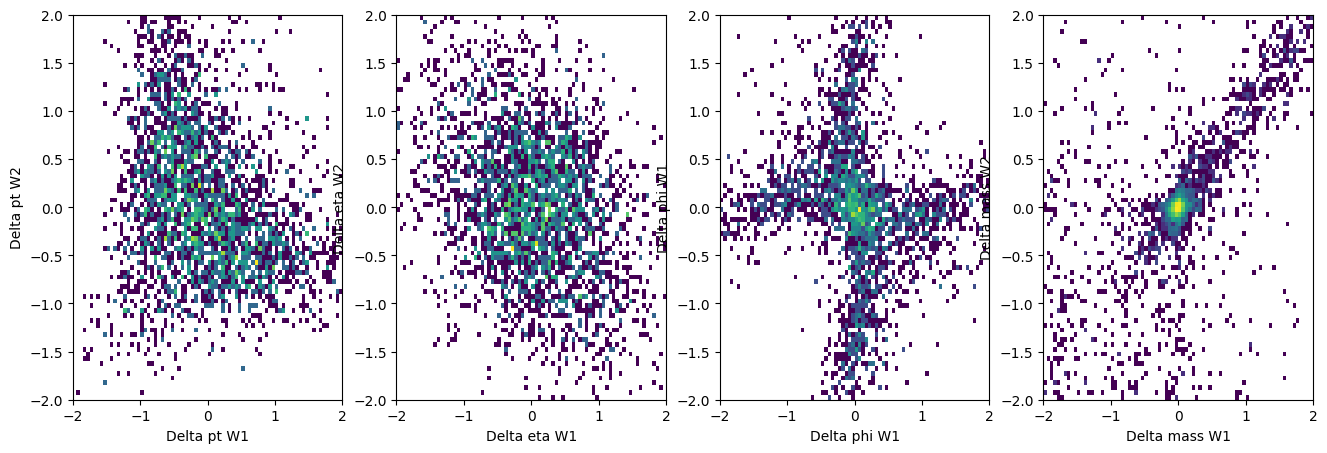

End of epoch 7
epoch 8, step 0, Loss: 2.4230, loss regr: 2.2315,  MMD total: 0.0131 
epoch 8, step 100, Loss: 2.4858, loss regr: 2.2513,  MMD total: 0.0151 
epoch 8, step 200, Loss: 2.6150, loss regr: 2.2587,  MMD total: 0.0215 
epoch 8, step 300, Loss: 2.8065, loss regr: 2.4984,  MMD total: 0.0180 
epoch 8, Validation Loss: 2.3741, loss regr: 2.3641,  MMD total: 0.0100


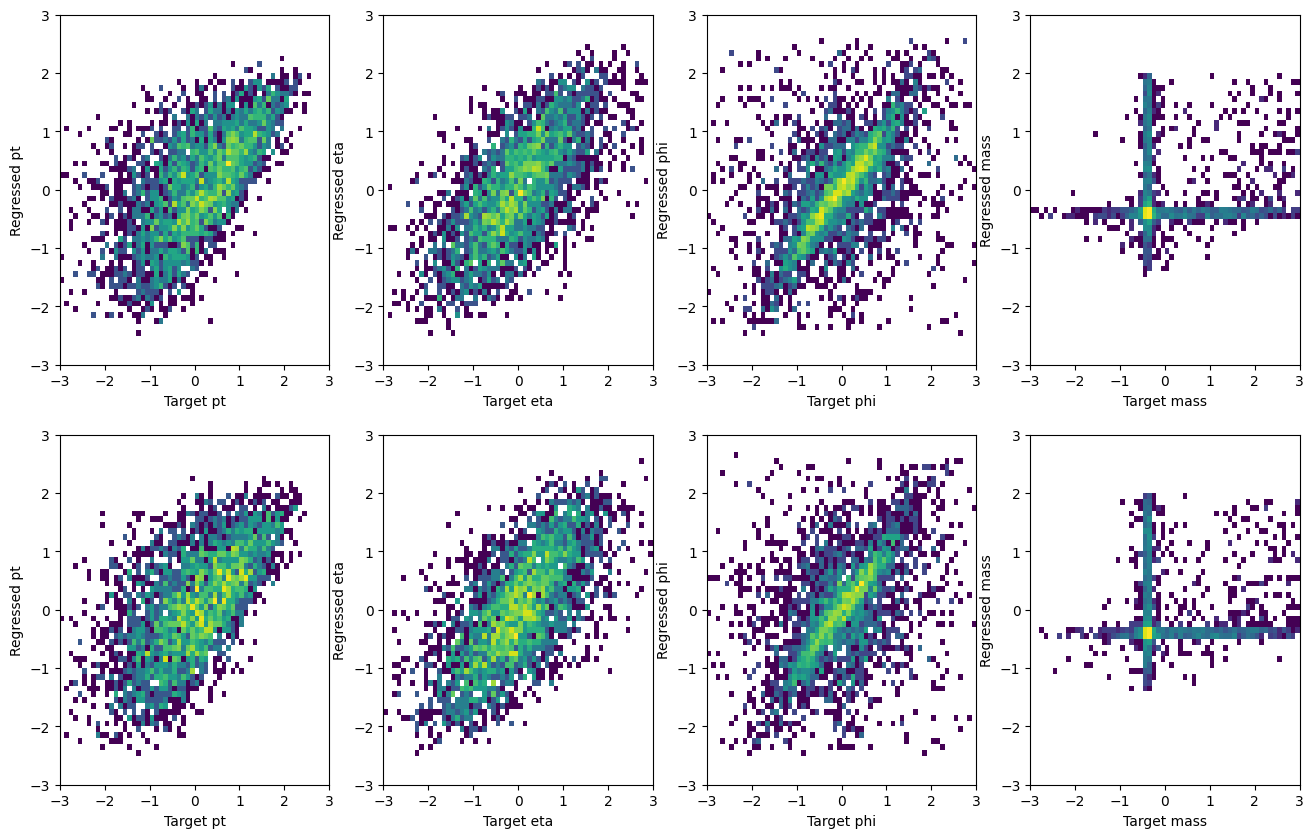

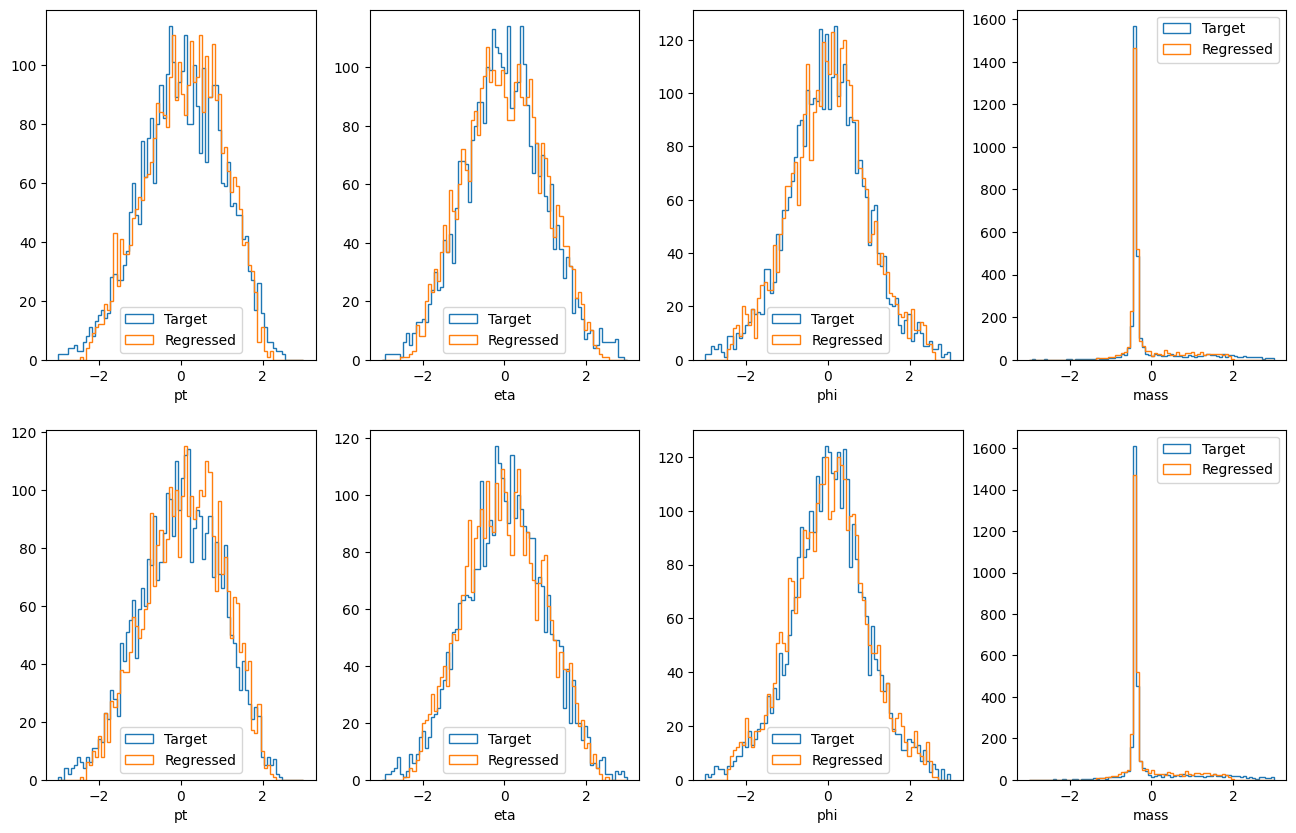

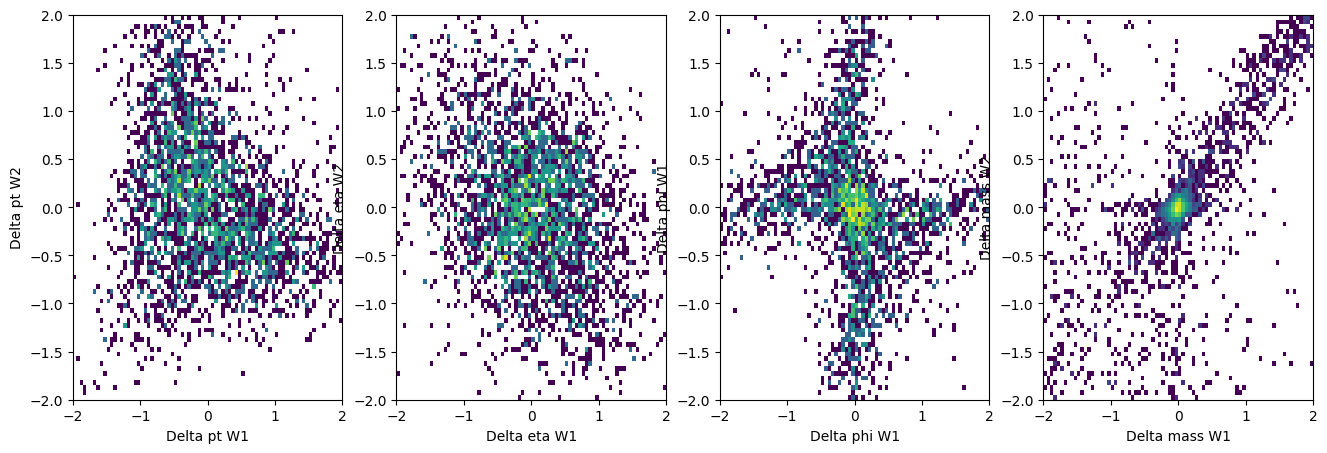

End of epoch 8
epoch 9, step 0, Loss: 2.5029, loss regr: 2.3015,  MMD total: 0.0118 
epoch 9, step 100, Loss: 2.5523, loss regr: 2.2501,  MMD total: 0.0165 
epoch 9, step 200, Loss: 2.5993, loss regr: 2.3097,  MMD total: 0.0153 
epoch 9, step 300, Loss: 2.7750, loss regr: 2.4704,  MMD total: 0.0155 
epoch 9, Validation Loss: 2.3719, loss regr: 2.3628,  MMD total: 0.0091


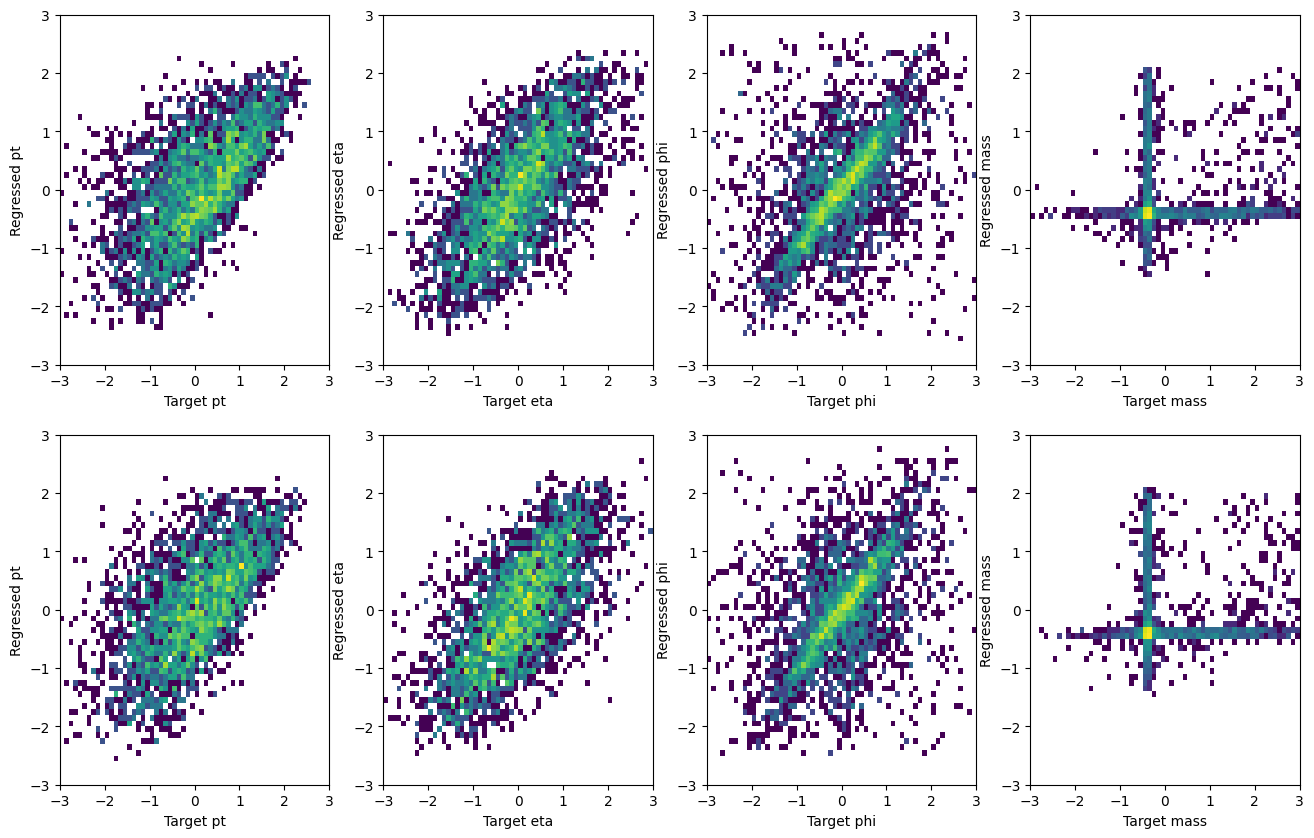

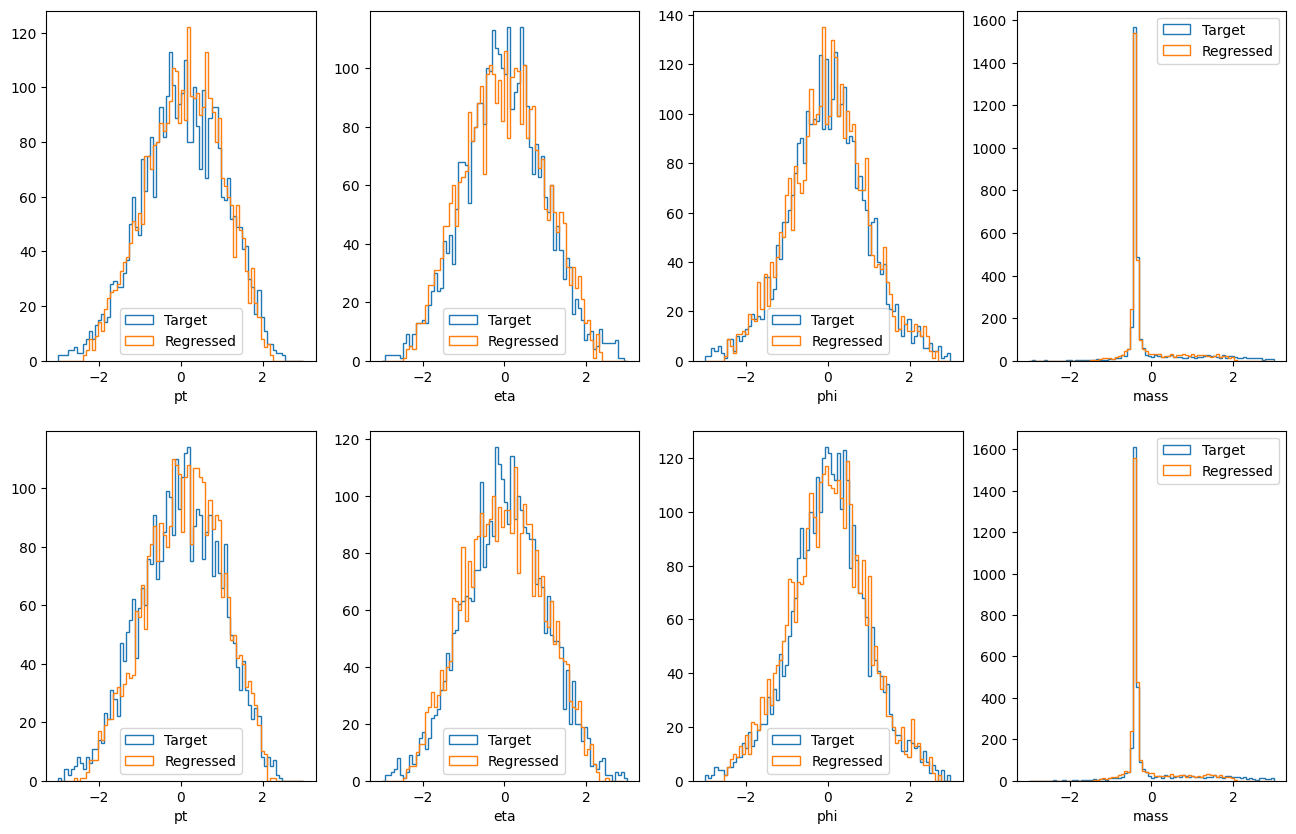

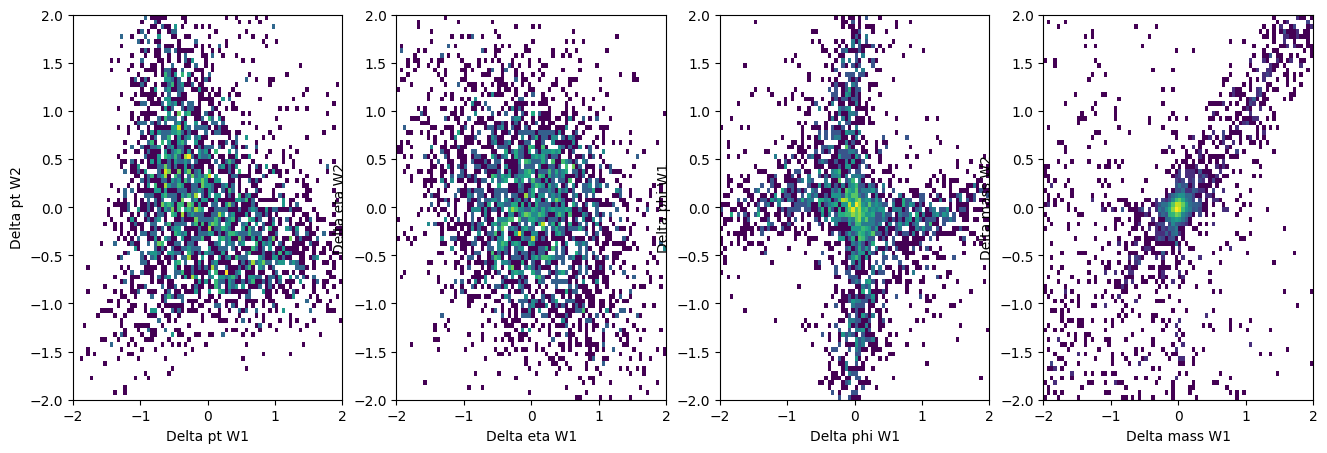

End of epoch 9
epoch 10, step 0, Loss: 2.4943, loss regr: 2.2737,  MMD total: 0.0112 
epoch 10, step 100, Loss: 2.5492, loss regr: 2.3271,  MMD total: 0.0108 
epoch 10, step 200, Loss: 2.6596, loss regr: 2.3141,  MMD total: 0.0157 
epoch 10, step 300, Loss: 2.8276, loss regr: 2.4919,  MMD total: 0.0148 
epoch 10, Validation Loss: 2.3789, loss regr: 2.3695,  MMD total: 0.0094


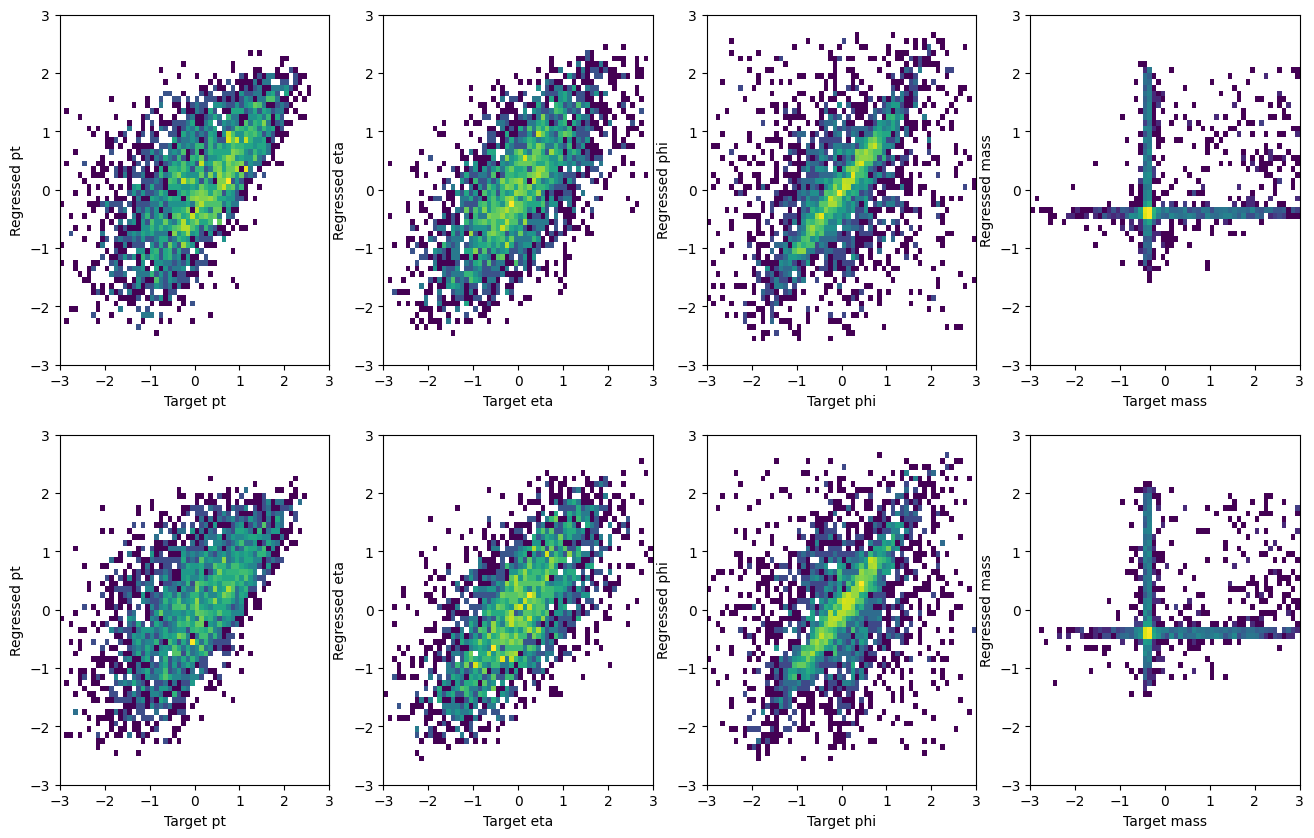

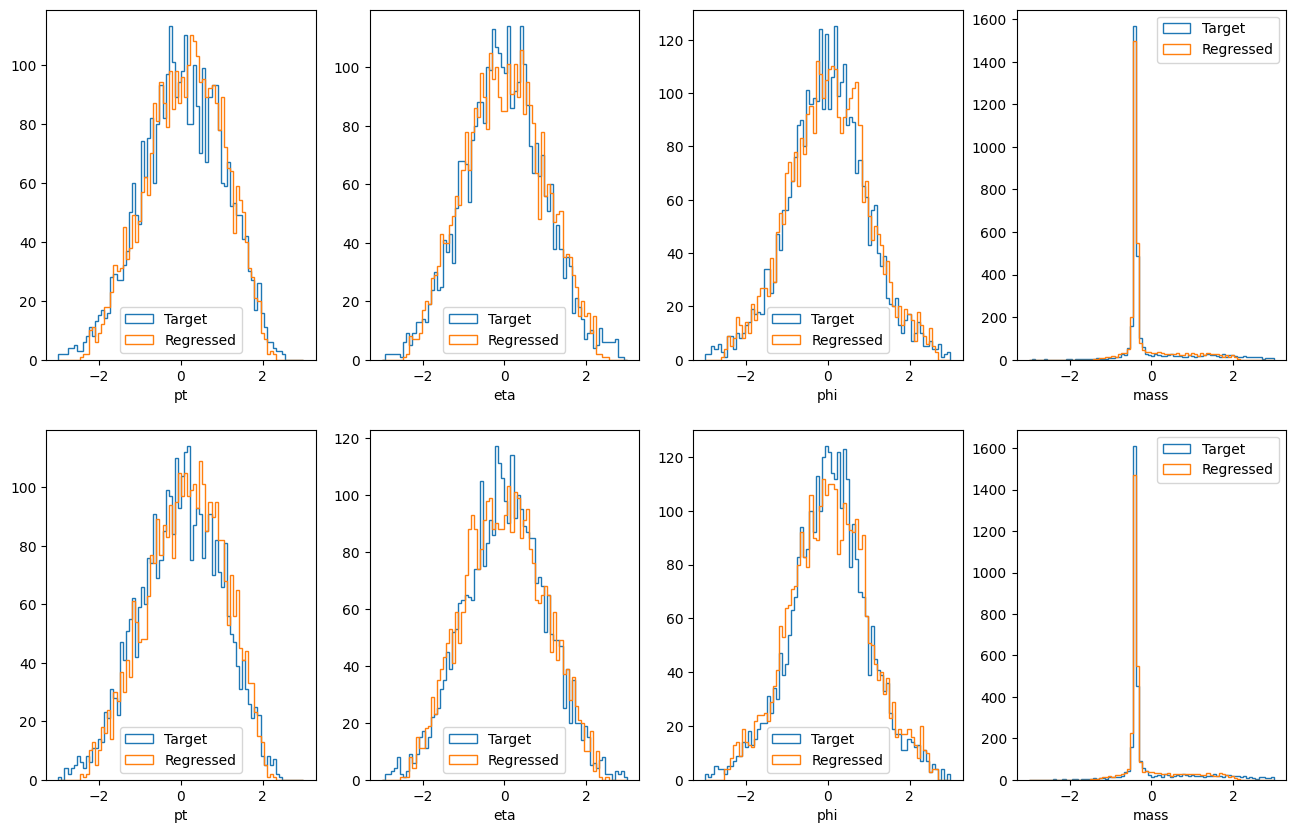

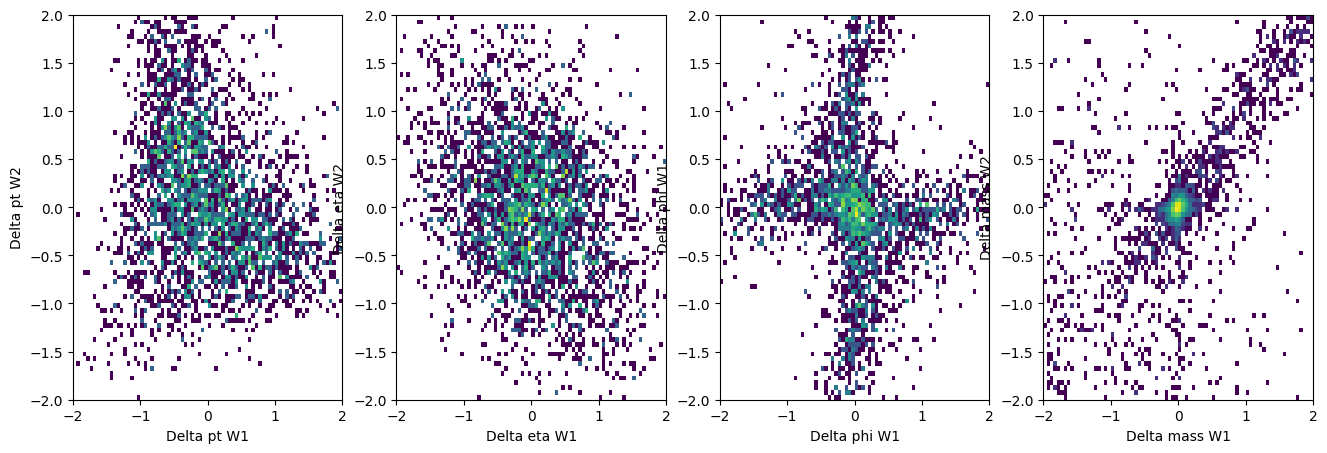

End of epoch 10
epoch 11, step 0, Loss: 2.4887, loss regr: 2.2404,  MMD total: 0.0109 
epoch 11, step 100, Loss: 2.5727, loss regr: 2.2776,  MMD total: 0.0123 
epoch 11, step 200, Loss: 2.7329, loss regr: 2.3505,  MMD total: 0.0152 
epoch 11, step 300, Loss: 2.7687, loss regr: 2.4833,  MMD total: 0.0113 
epoch 11, Validation Loss: 2.4086, loss regr: 2.4012,  MMD total: 0.0074


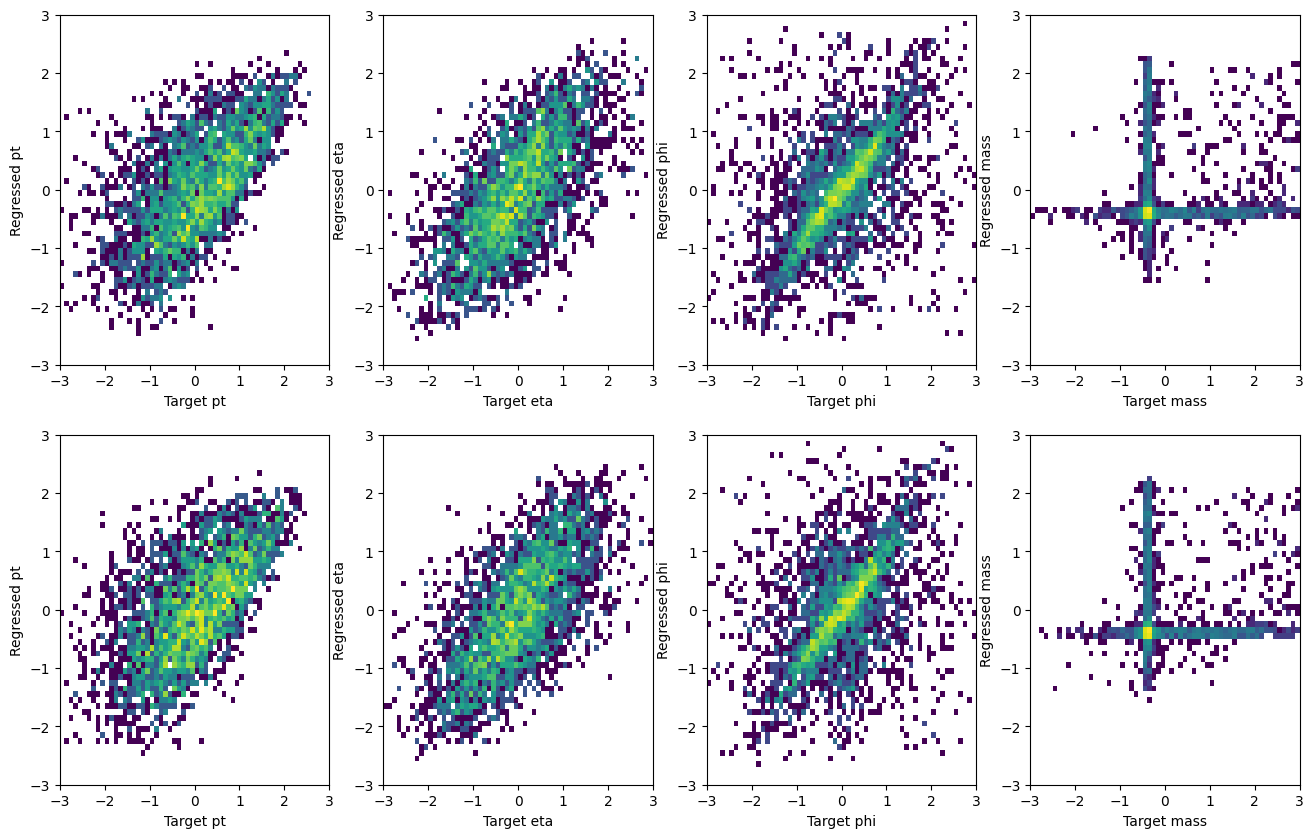

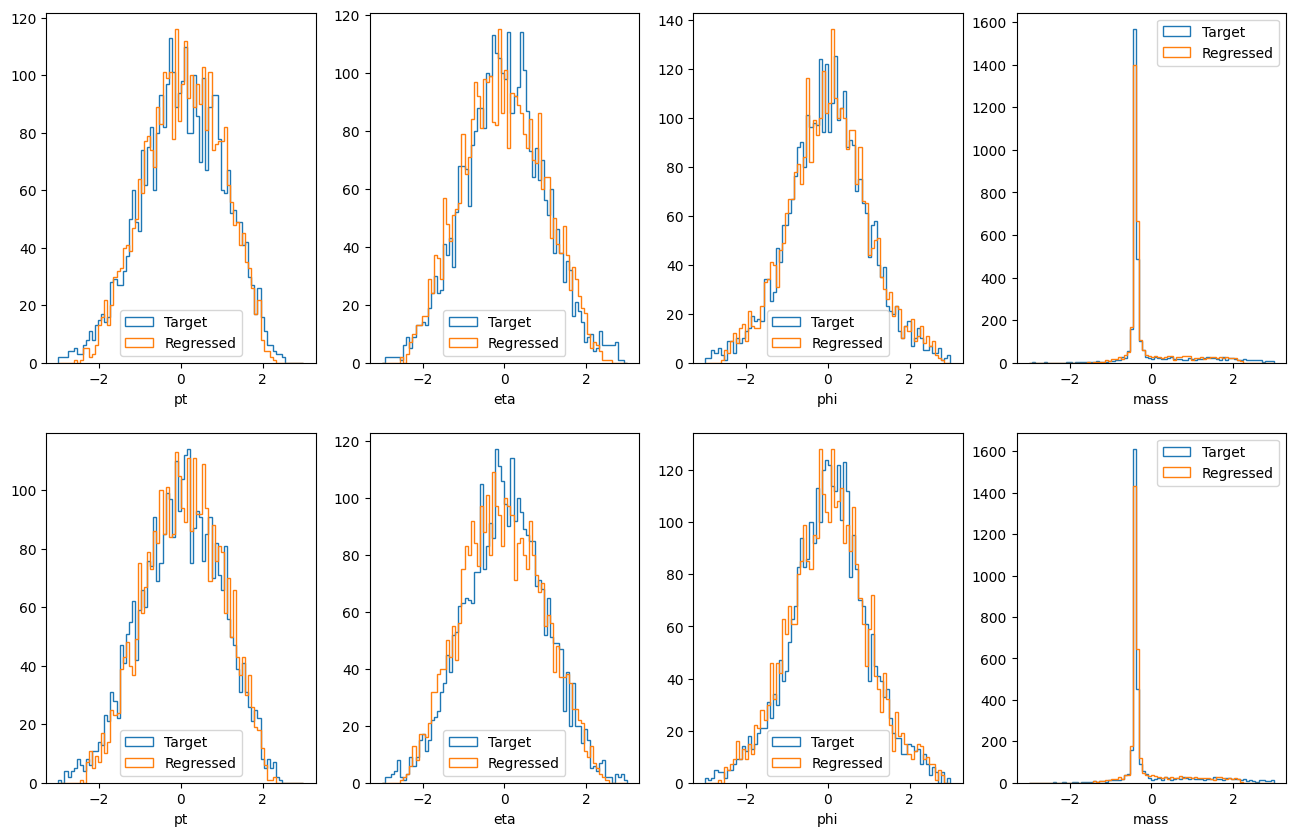

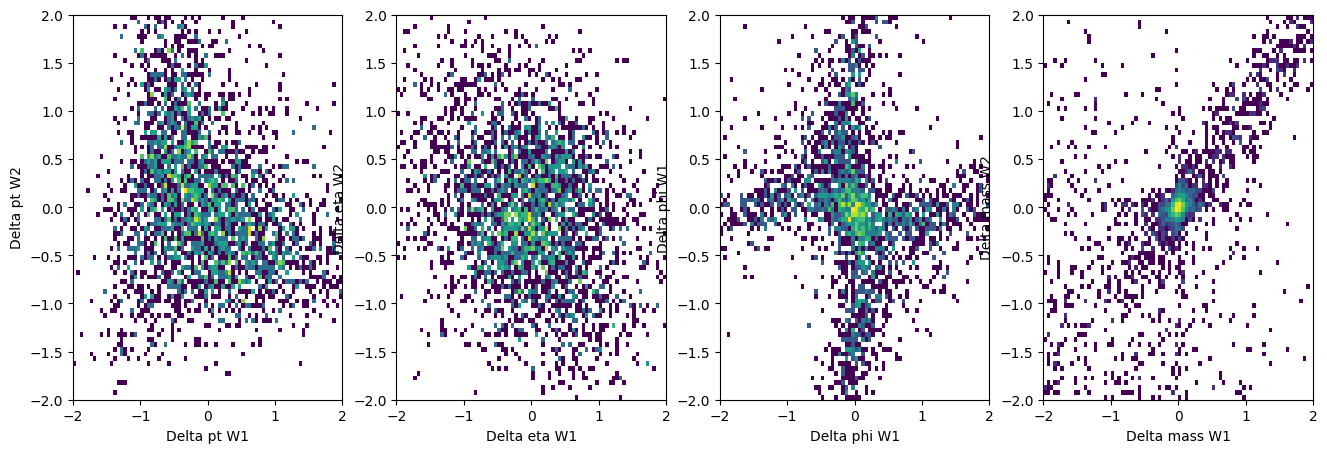

End of epoch 11
epoch 12, step 0, Loss: 2.5807, loss regr: 2.2951,  MMD total: 0.0110 
epoch 12, step 100, Loss: 2.5341, loss regr: 2.2871,  MMD total: 0.0093 
epoch 12, step 200, Loss: 2.7385, loss regr: 2.3881,  MMD total: 0.0124 
epoch 12, step 300, Loss: 2.8380, loss regr: 2.5173,  MMD total: 0.0111 
epoch 12, Validation Loss: 2.4085, loss regr: 2.4009,  MMD total: 0.0075


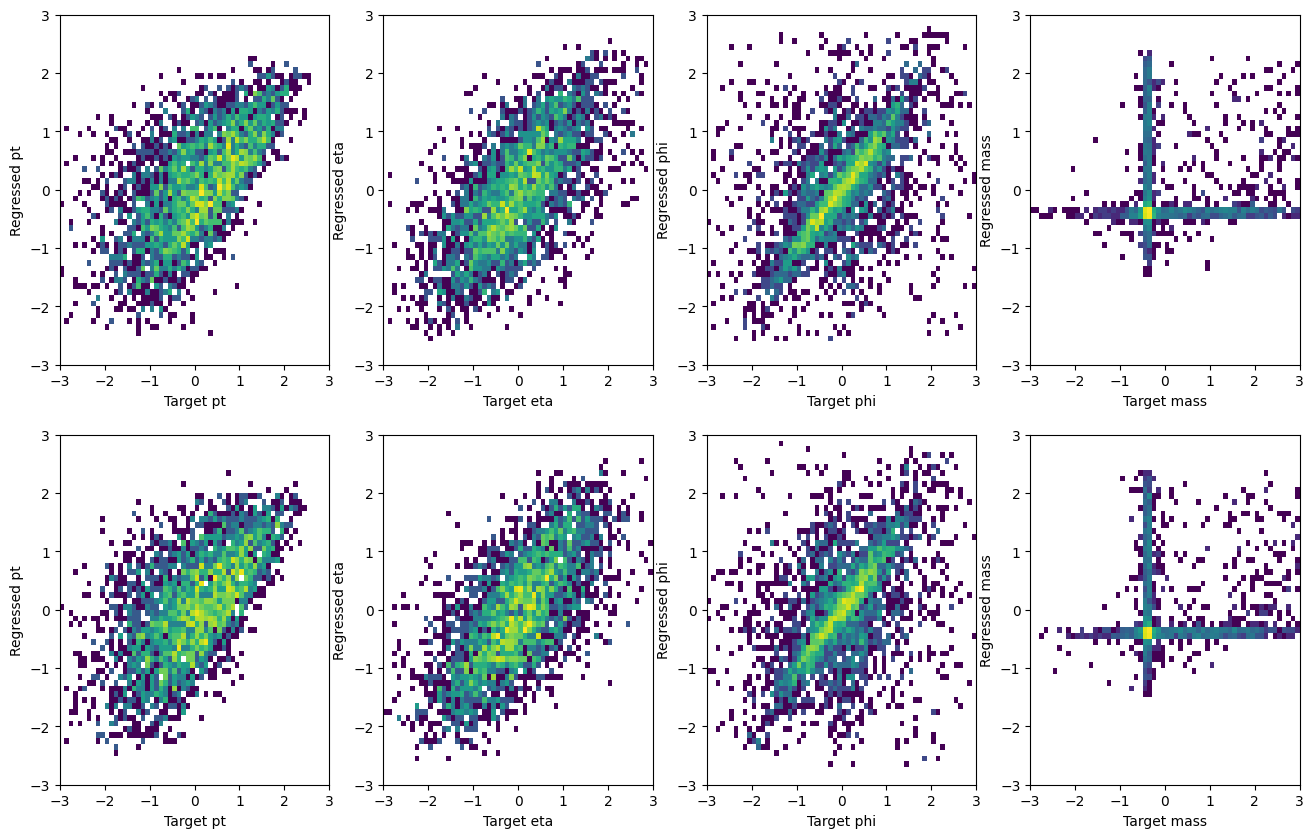

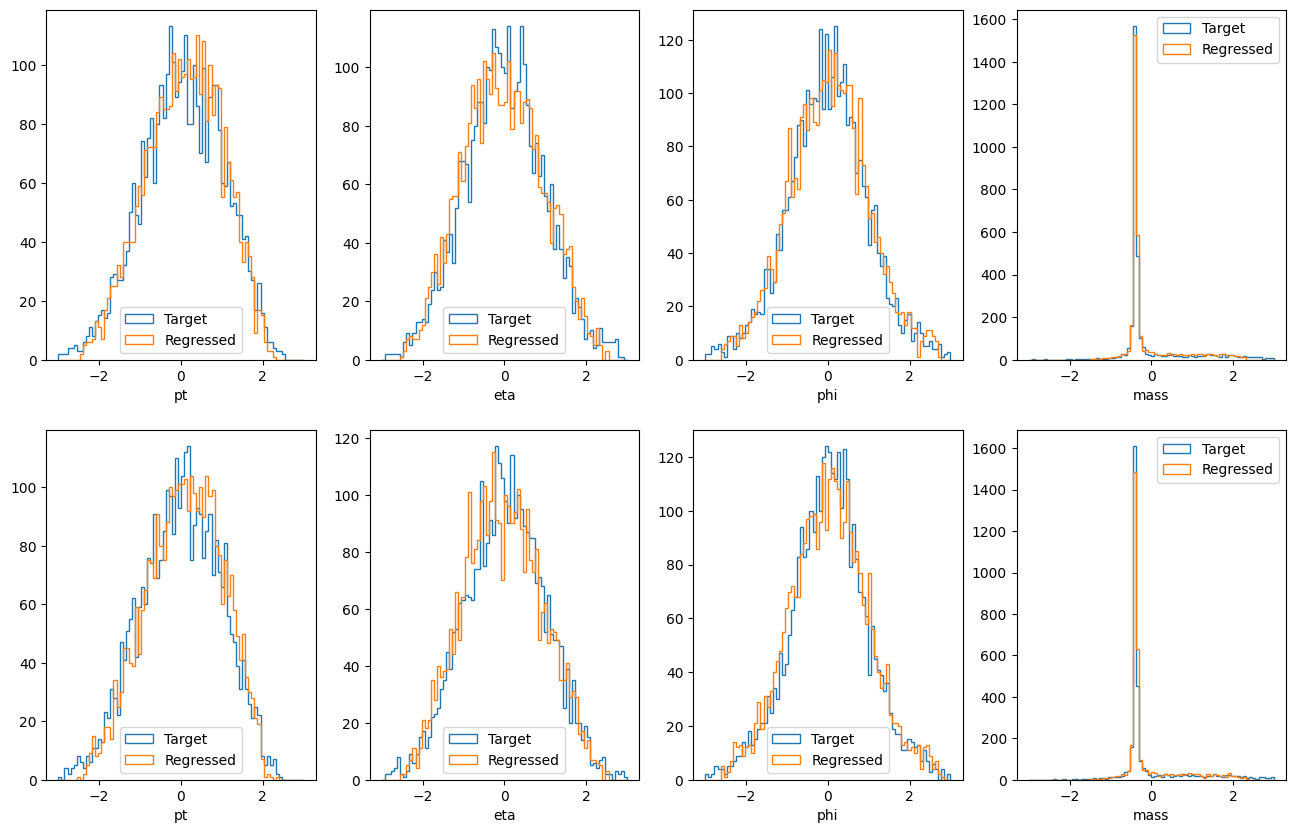

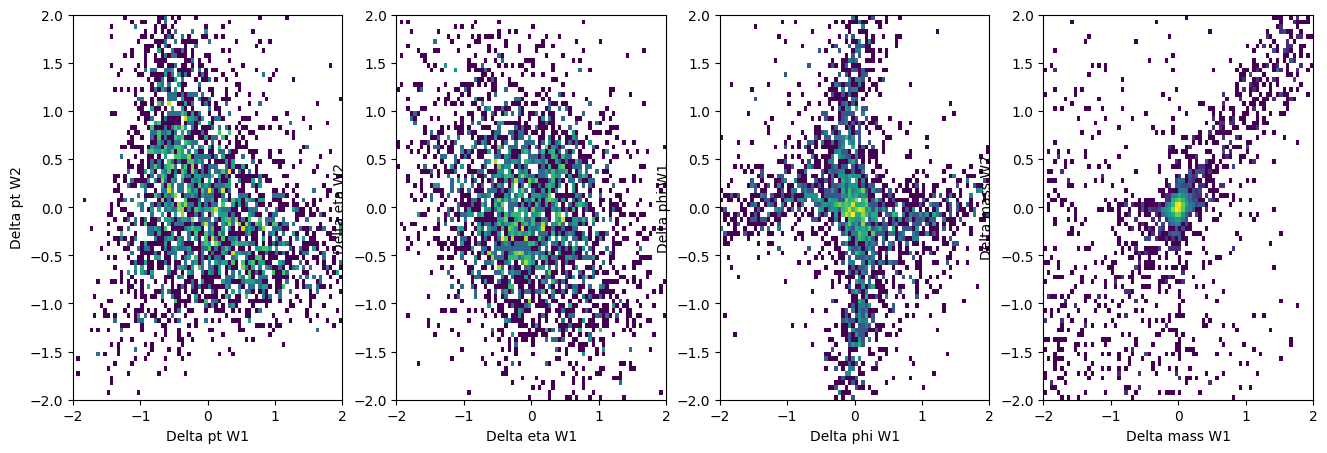

End of epoch 12
epoch 13, step 0, Loss: 2.5451, loss regr: 2.2510,  MMD total: 0.0100 
epoch 13, step 100, Loss: 2.6507, loss regr: 2.2980,  MMD total: 0.0115 
epoch 13, step 200, Loss: 2.6939, loss regr: 2.3697,  MMD total: 0.0103 
epoch 13, step 300, Loss: 2.8851, loss regr: 2.5136,  MMD total: 0.0114 
epoch 13, Validation Loss: 2.4235, loss regr: 2.4168,  MMD total: 0.0067


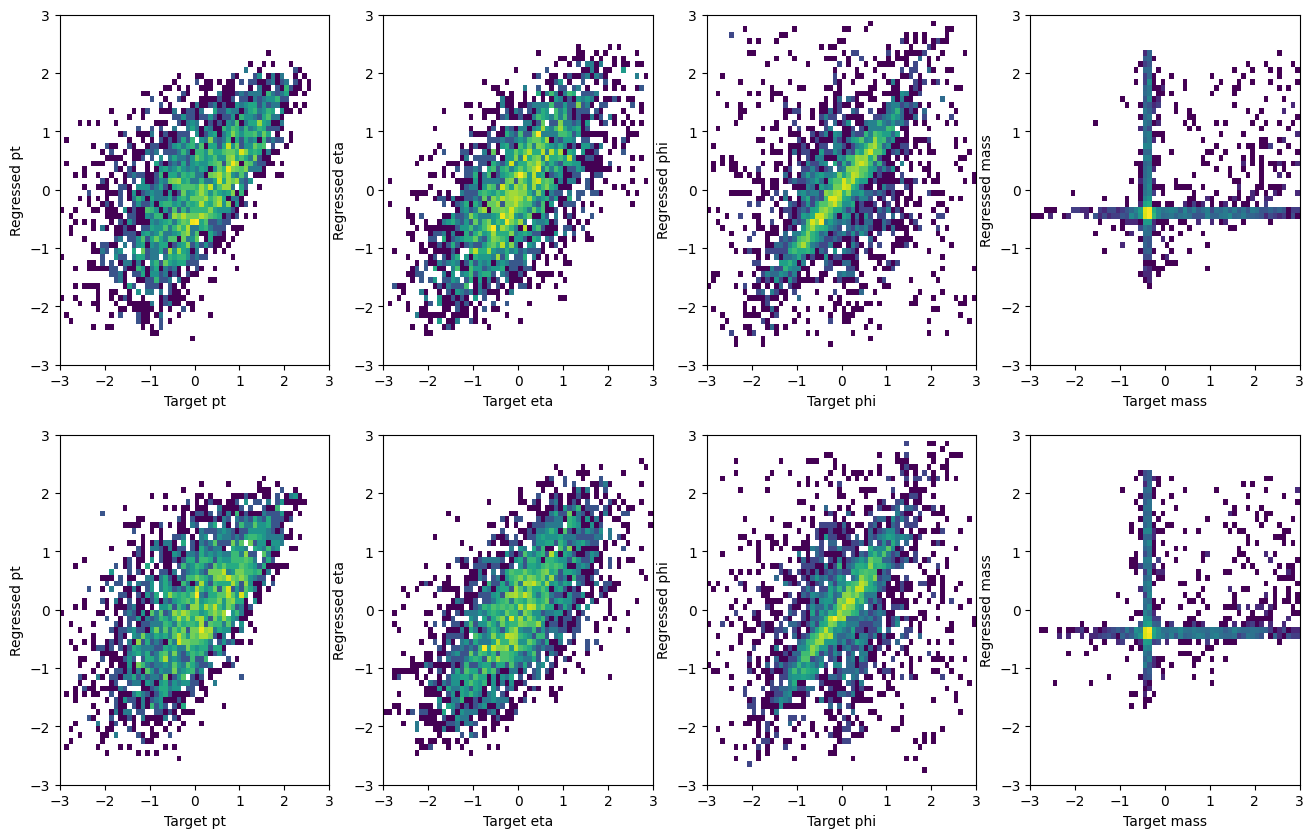

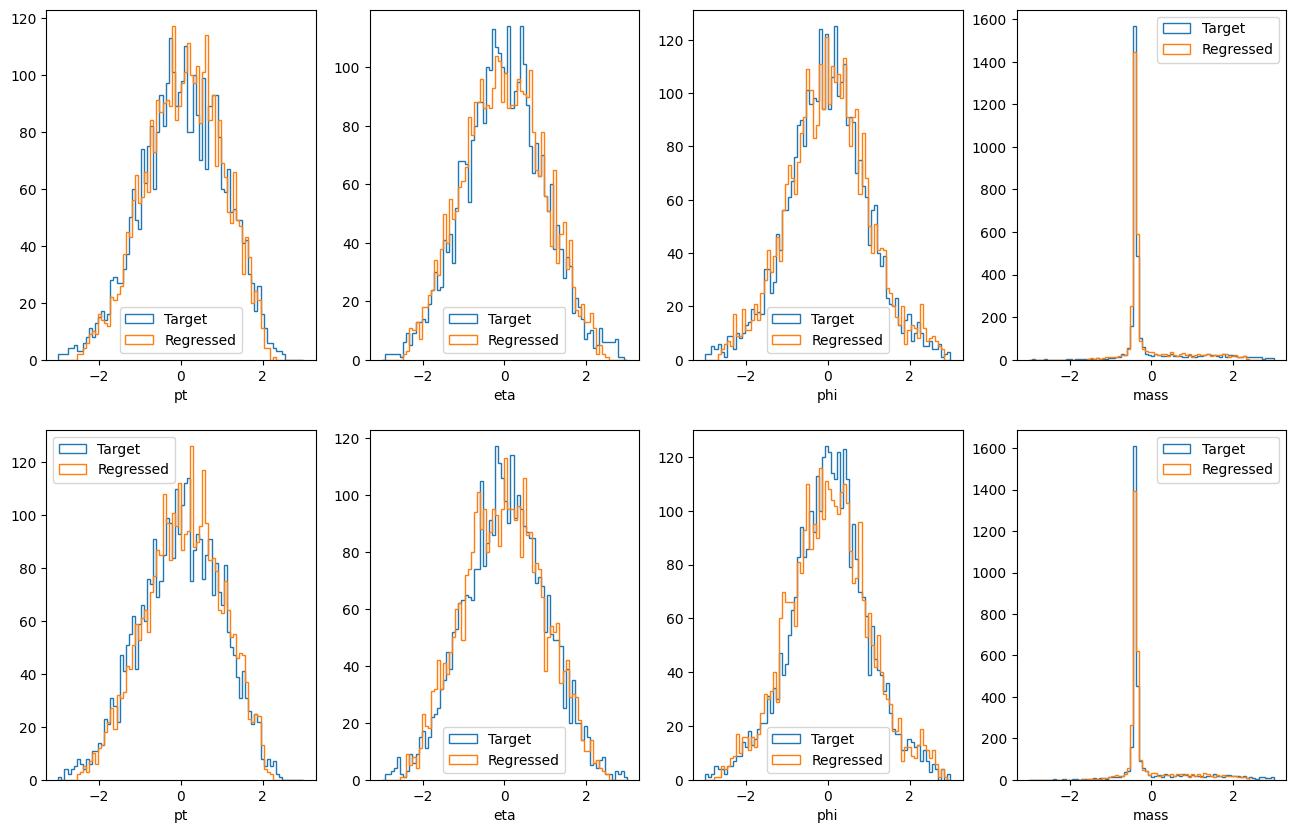

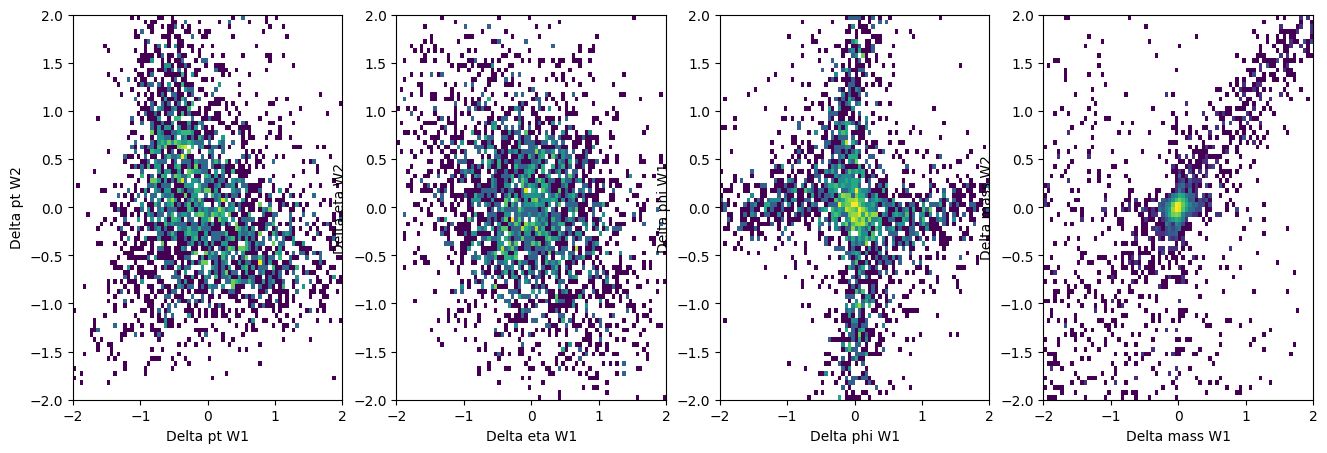

End of epoch 13
epoch 14, step 0, Loss: 2.6217, loss regr: 2.3151,  MMD total: 0.0093 
epoch 14, step 100, Loss: 2.6261, loss regr: 2.3380,  MMD total: 0.0086 
epoch 14, step 200, Loss: 2.9645, loss regr: 2.4299,  MMD total: 0.0146 
epoch 14, step 300, Loss: 2.9494, loss regr: 2.5629,  MMD total: 0.0106 
epoch 14, Validation Loss: 2.4284, loss regr: 2.4202,  MMD total: 0.0082


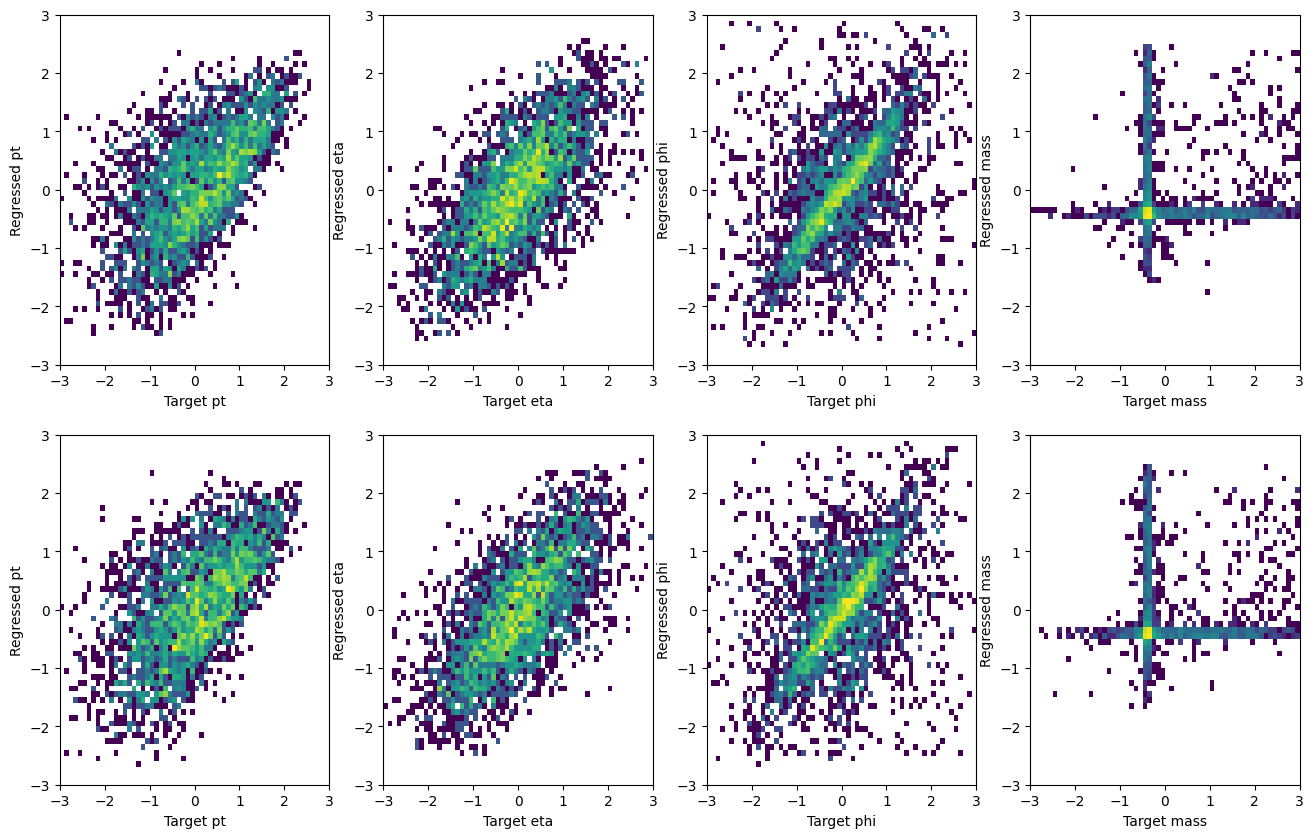

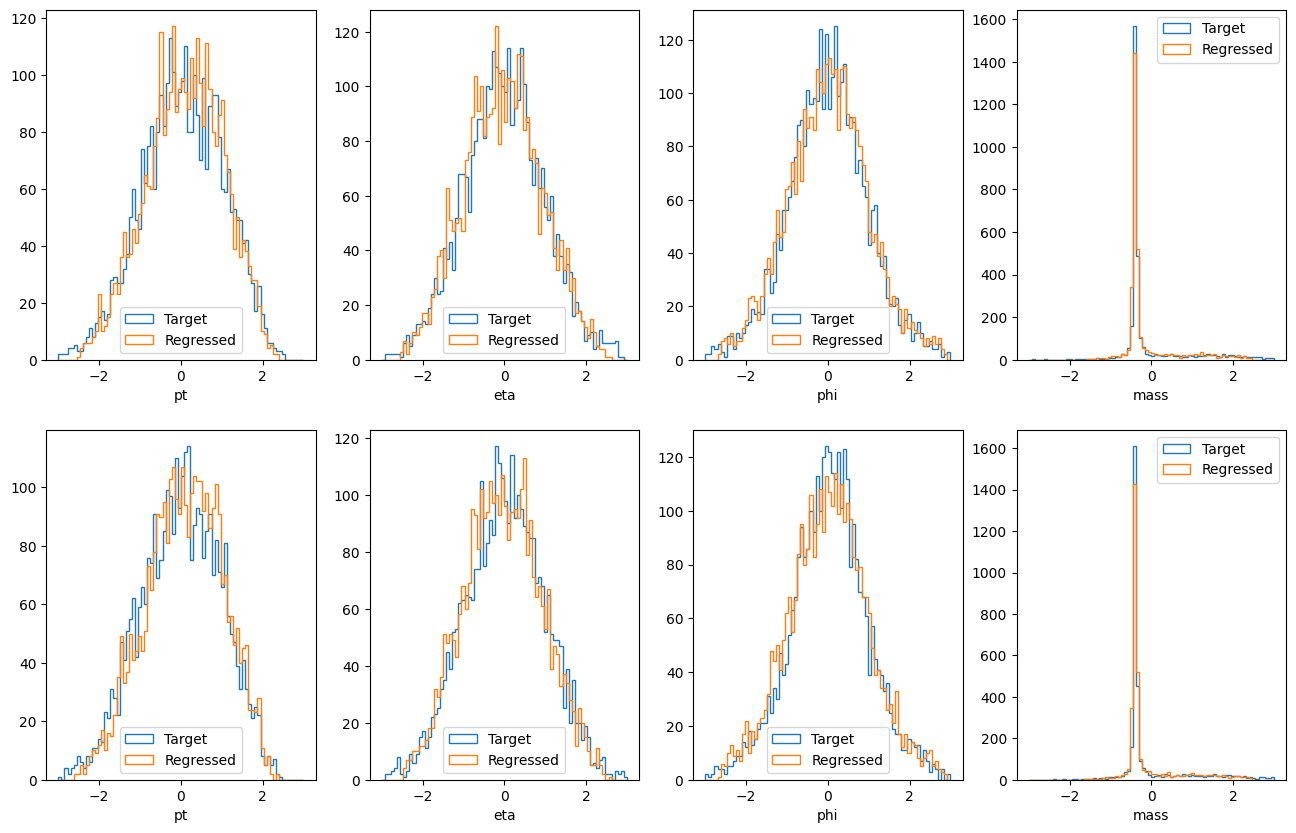

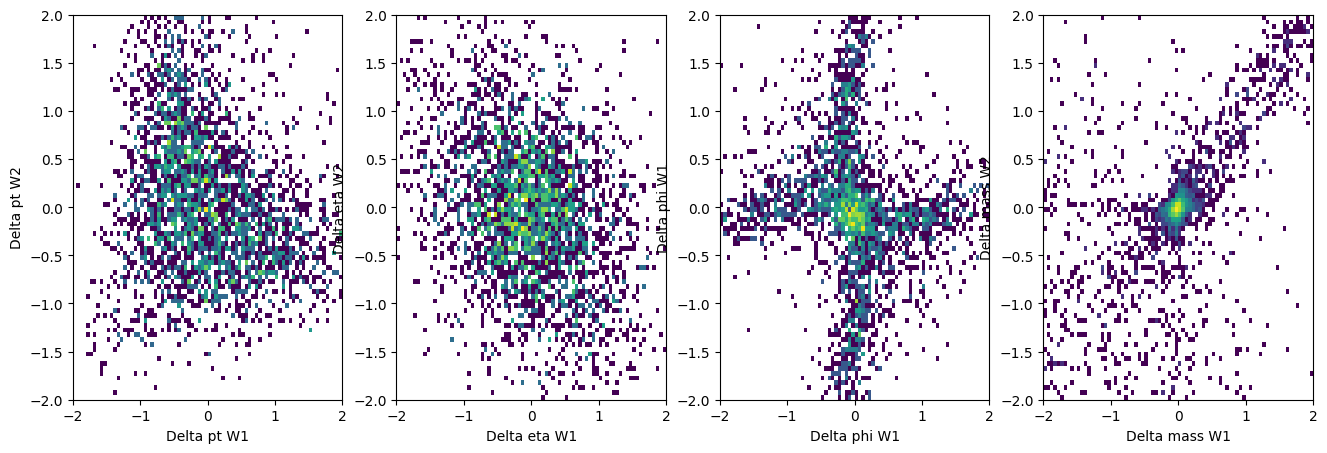

End of epoch 14
epoch 15, step 0, Loss: 2.6590, loss regr: 2.2817,  MMD total: 0.0101 
epoch 15, step 100, Loss: 2.6728, loss regr: 2.3203,  MMD total: 0.0092 
epoch 15, step 200, Loss: 2.8168, loss regr: 2.4392,  MMD total: 0.0096 
epoch 15, step 300, Loss: 3.0464, loss regr: 2.5330,  MMD total: 0.0123 
epoch 15, Validation Loss: 2.4365, loss regr: 2.4287,  MMD total: 0.0078


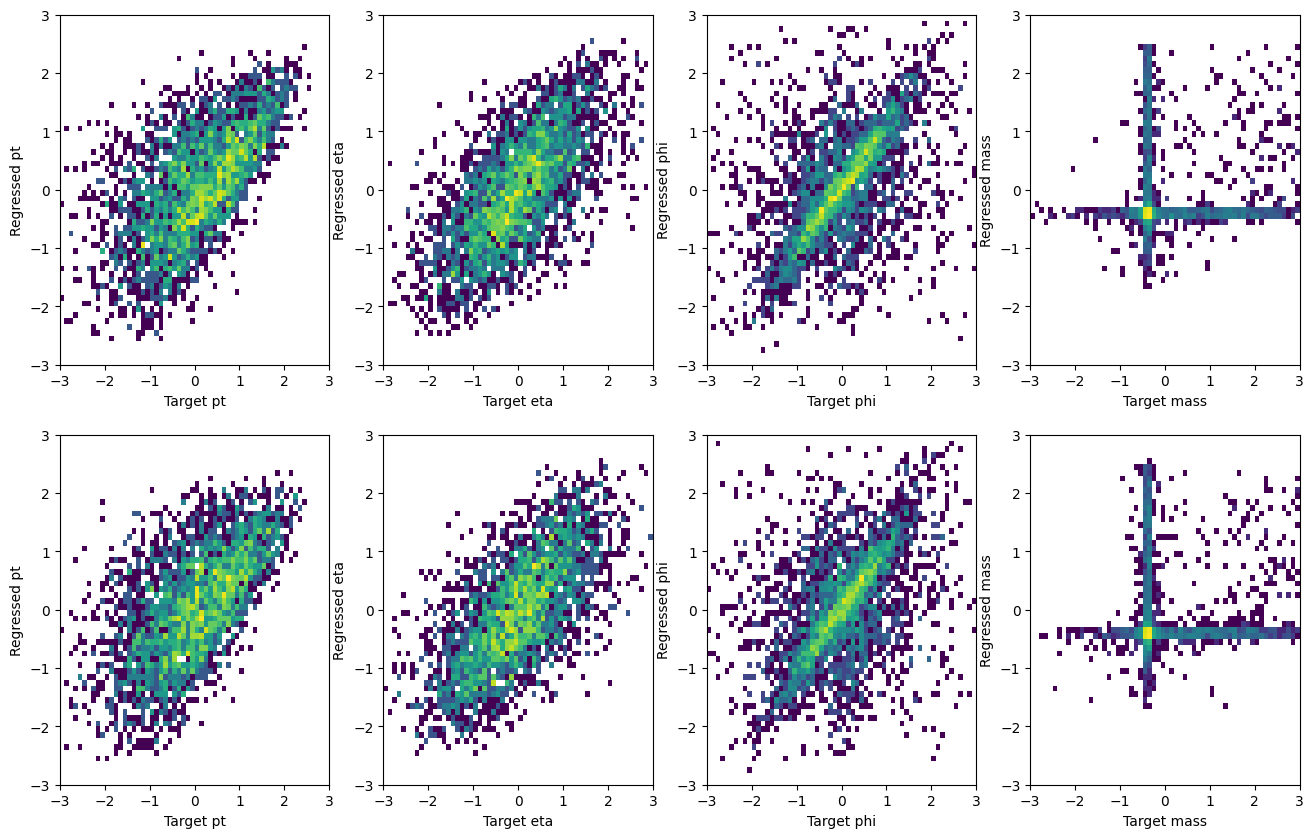

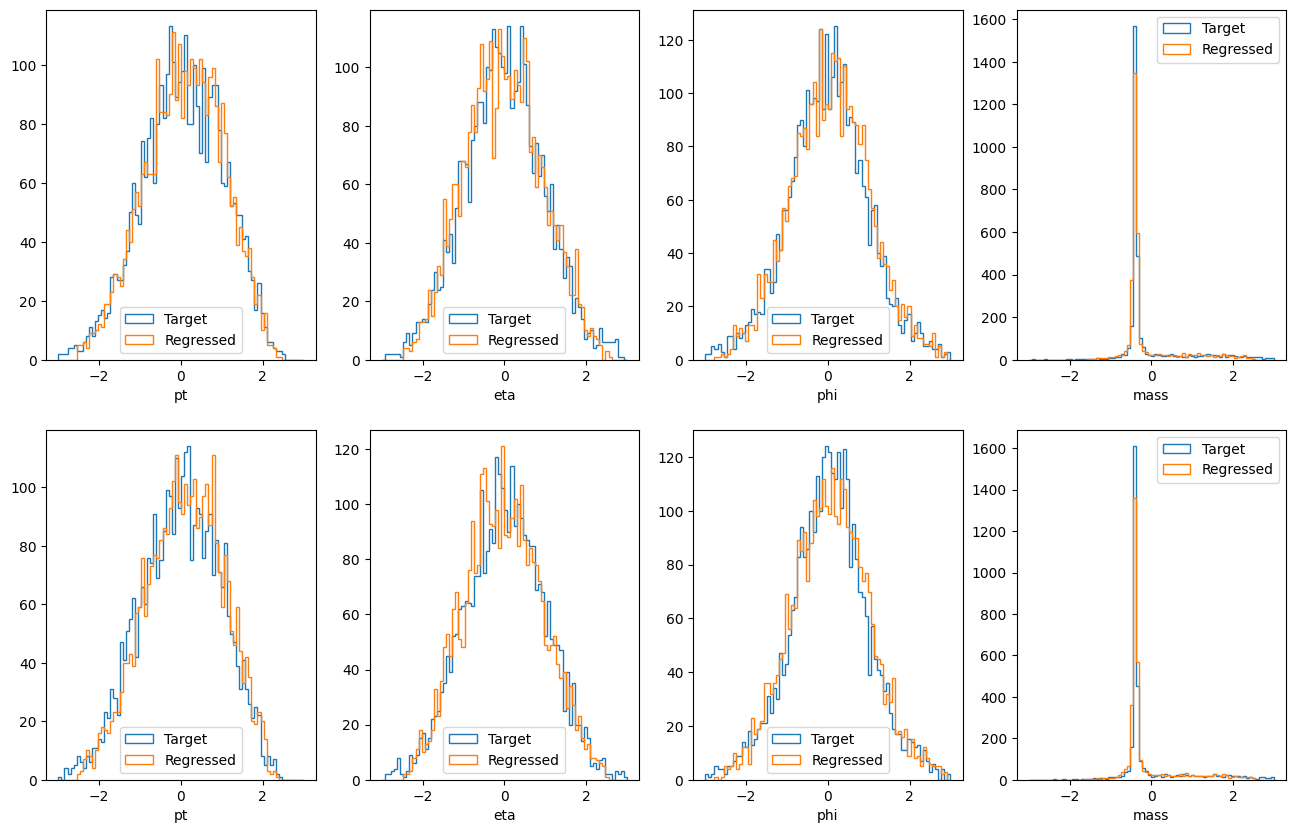

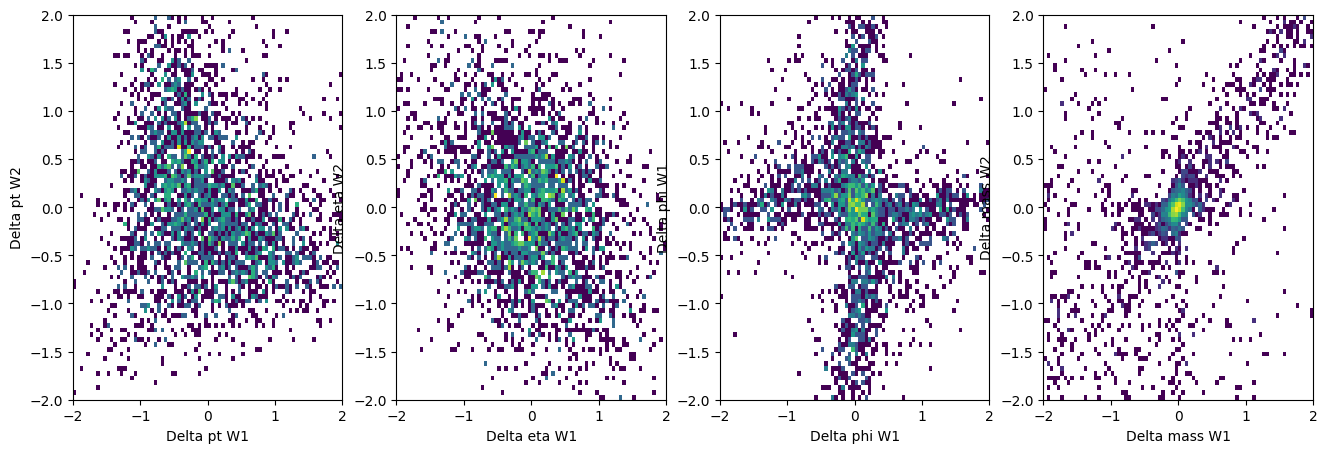

End of epoch 15
epoch 16, step 0, Loss: 2.7181, loss regr: 2.2847,  MMD total: 0.0103 
epoch 16, step 100, Loss: 2.7634, loss regr: 2.3627,  MMD total: 0.0094 
epoch 16, step 200, Loss: 2.8069, loss regr: 2.4053,  MMD total: 0.0092 
epoch 16, step 300, Loss: 2.9713, loss regr: 2.5812,  MMD total: 0.0087 
epoch 16, Validation Loss: 2.4325, loss regr: 2.4243,  MMD total: 0.0082


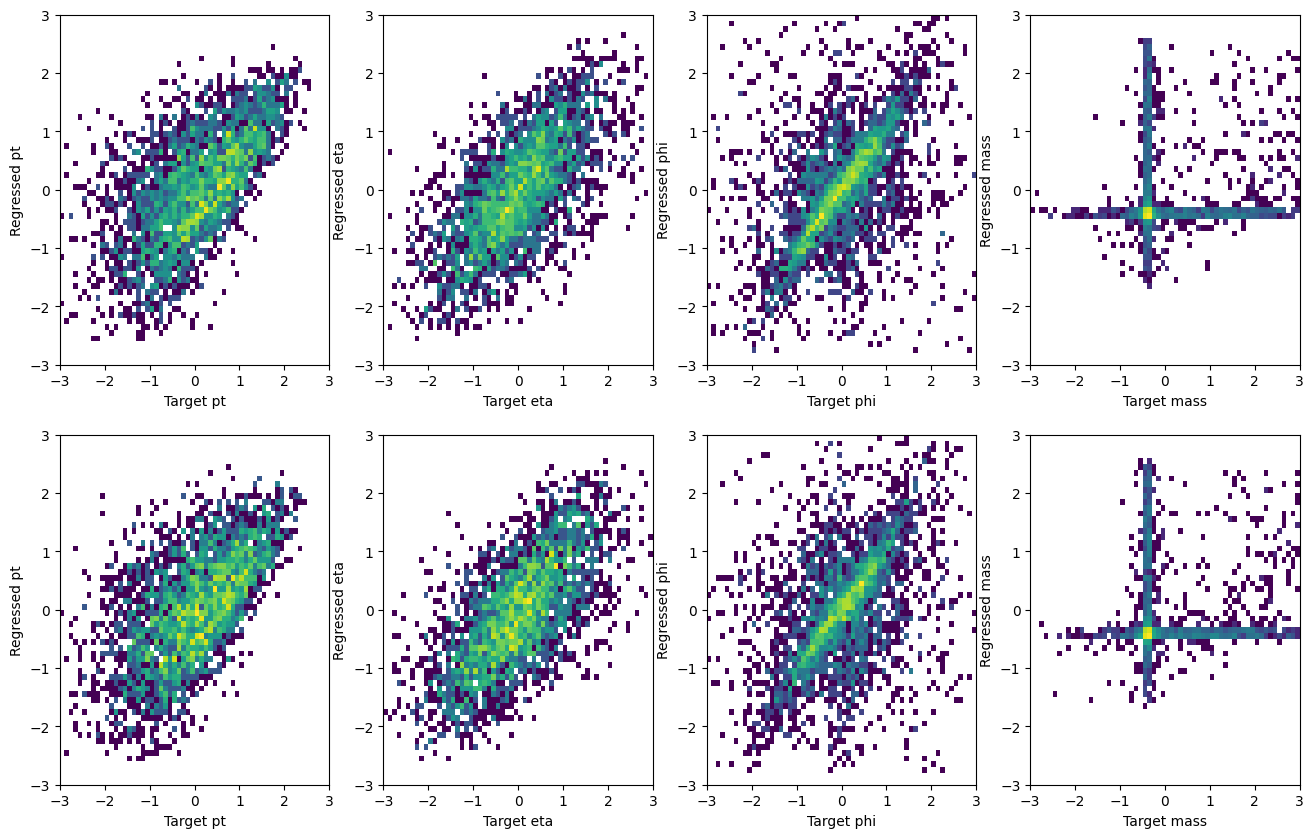

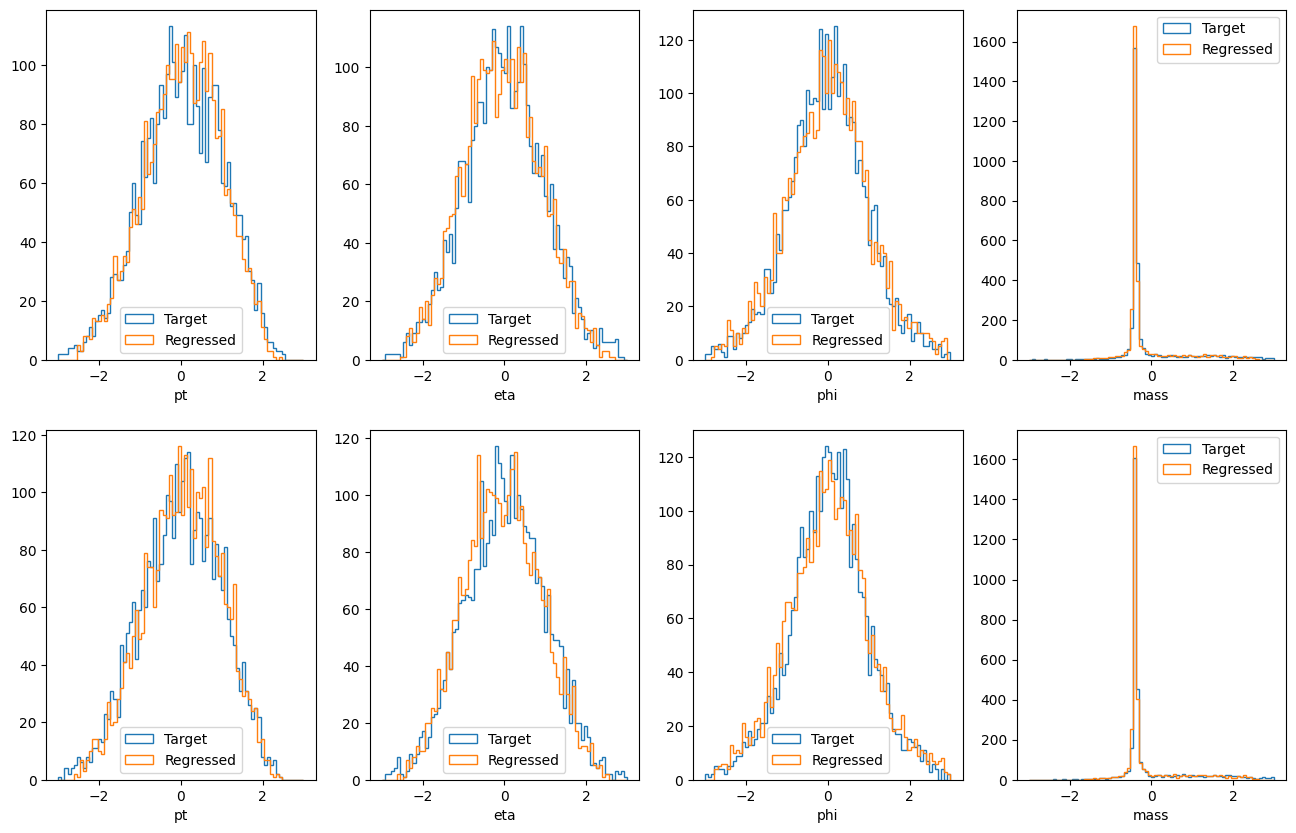

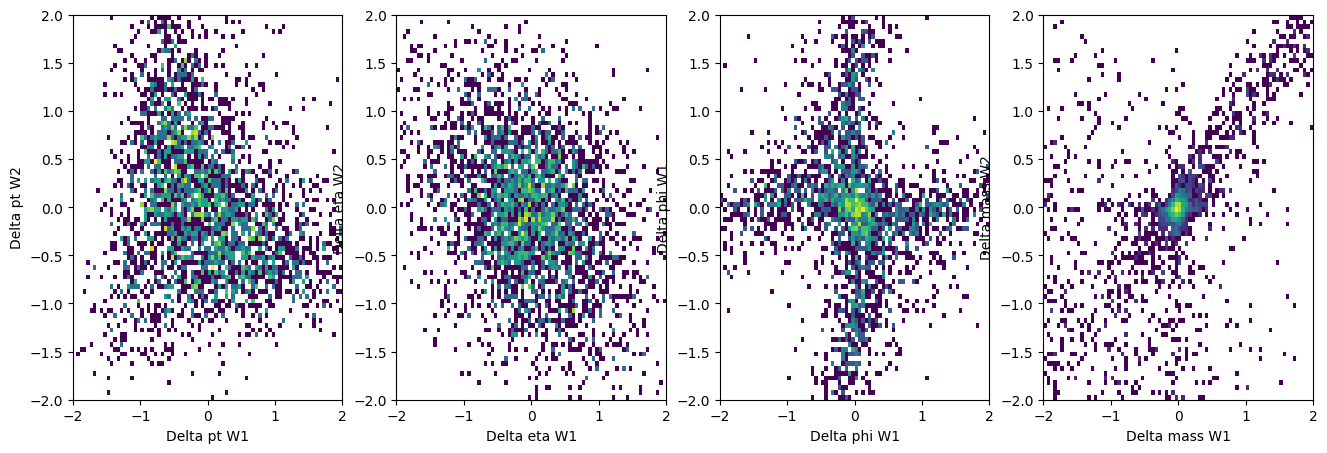

End of epoch 16
epoch 17, step 0, Loss: 2.7470, loss regr: 2.2758,  MMD total: 0.0101 
epoch 17, step 100, Loss: 2.7432, loss regr: 2.3100,  MMD total: 0.0092 
epoch 17, step 200, Loss: 2.7296, loss regr: 2.3914,  MMD total: 0.0072 
epoch 17, step 300, Loss: 2.9689, loss regr: 2.5609,  MMD total: 0.0083 
epoch 17, Validation Loss: 2.4430, loss regr: 2.4371,  MMD total: 0.0058


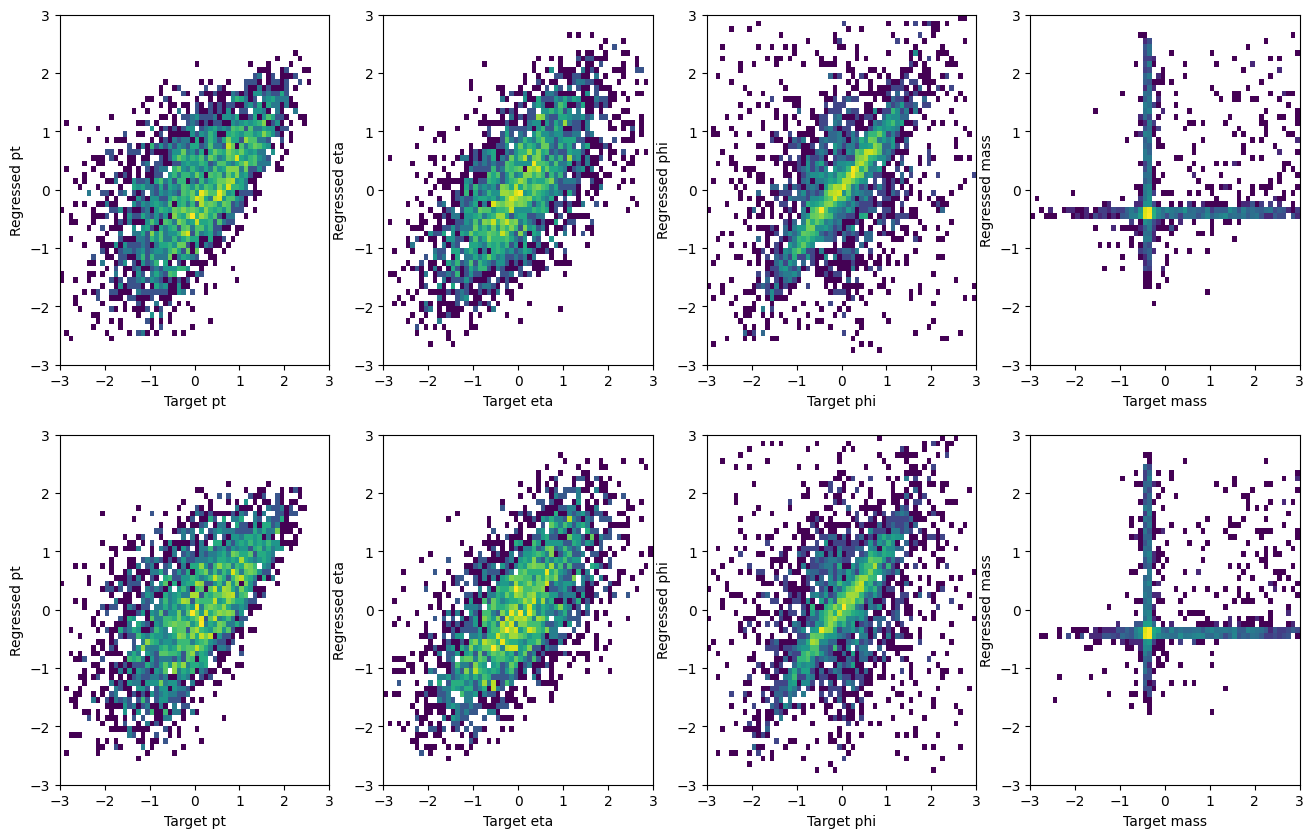

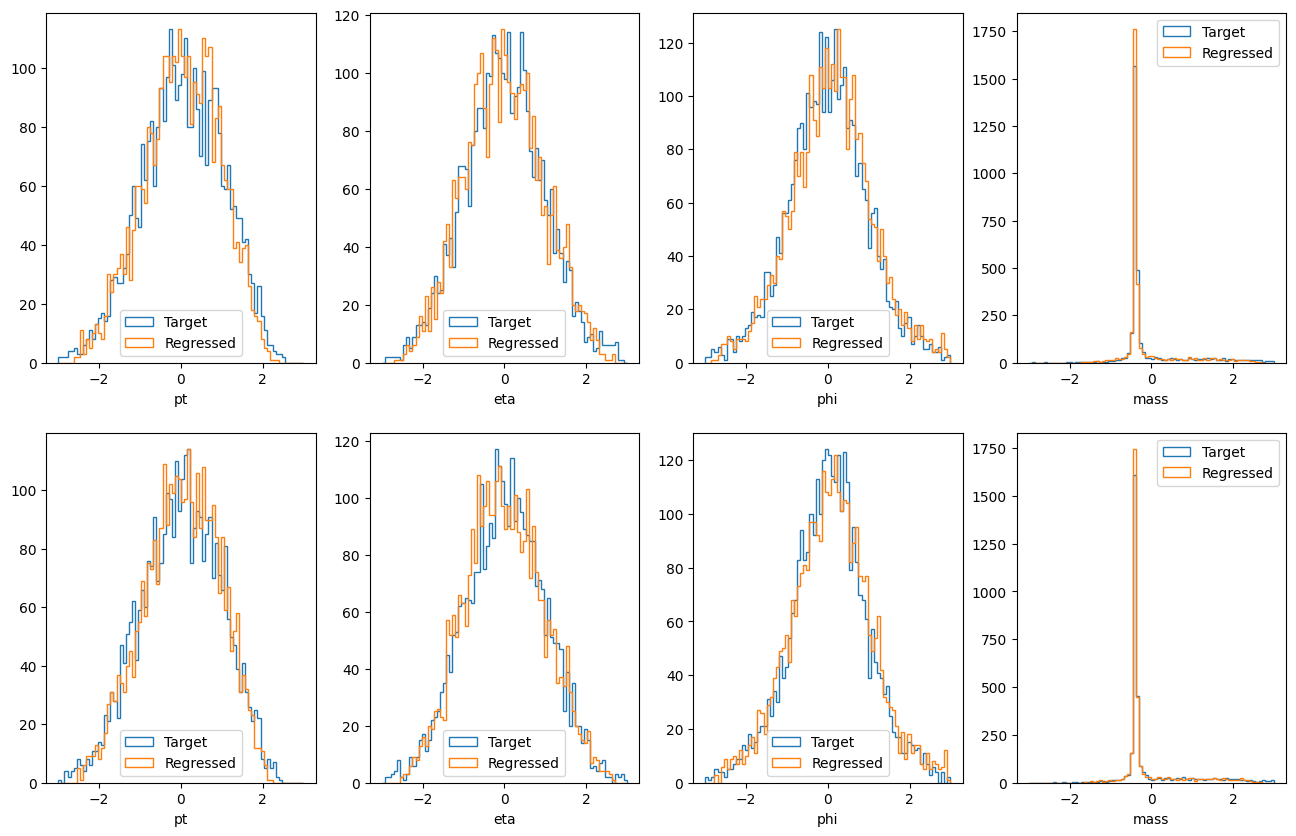

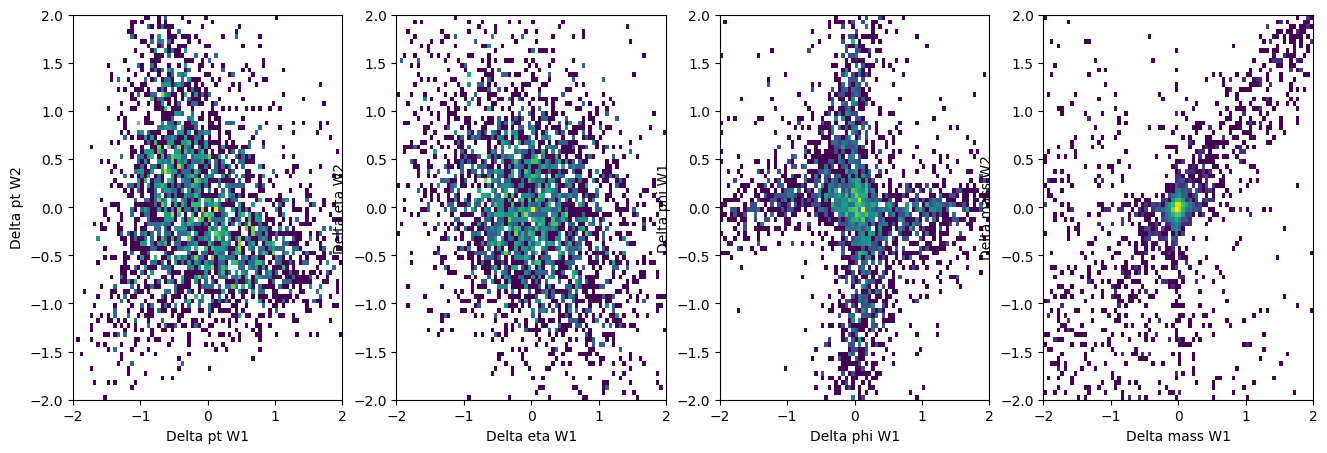

End of epoch 17
epoch 18, step 0, Loss: 2.7976, loss regr: 2.2994,  MMD total: 0.0097 
epoch 18, step 100, Loss: 2.9595, loss regr: 2.4016,  MMD total: 0.0105 
epoch 18, step 200, Loss: 2.7339, loss regr: 2.3768,  MMD total: 0.0069 
epoch 18, step 300, Loss: 3.1013, loss regr: 2.5817,  MMD total: 0.0094 
epoch 18, Validation Loss: 2.4579, loss regr: 2.4526,  MMD total: 0.0053


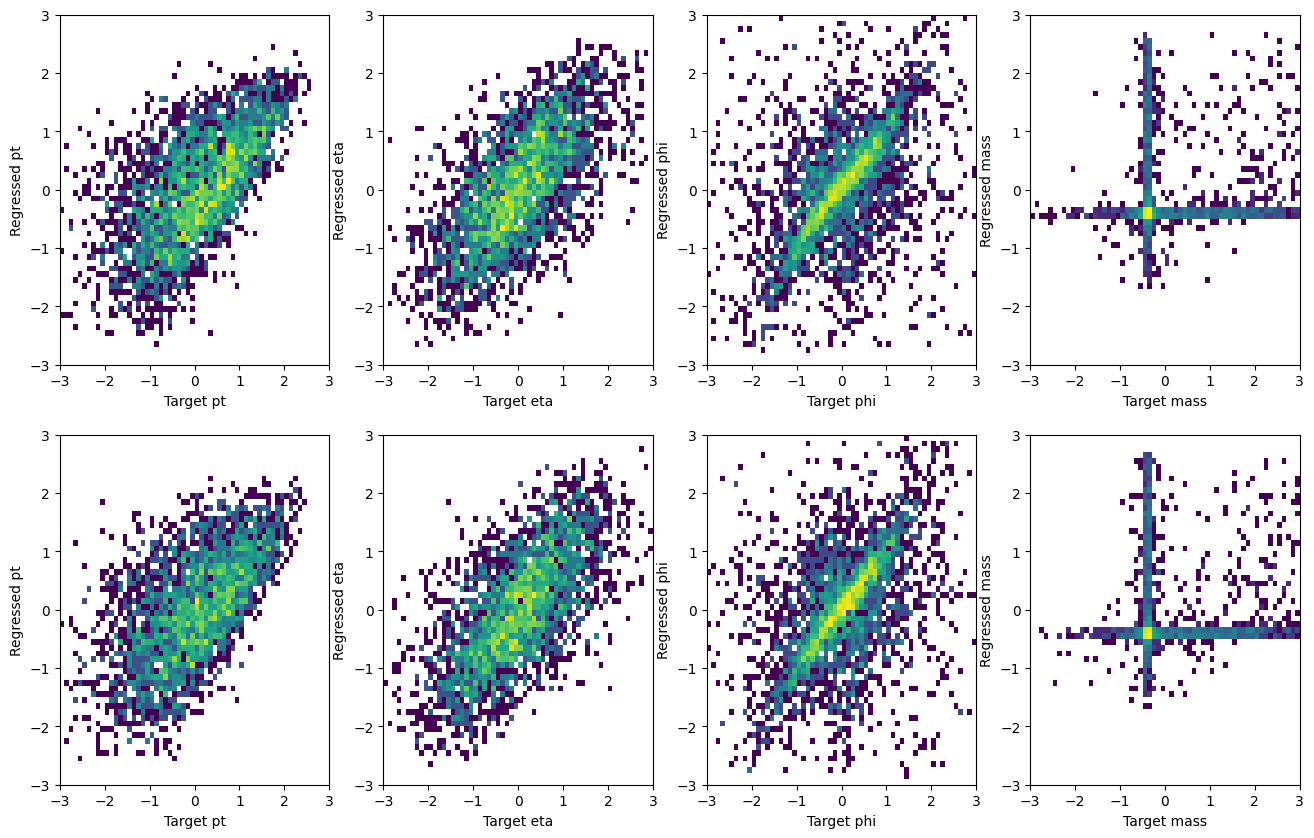

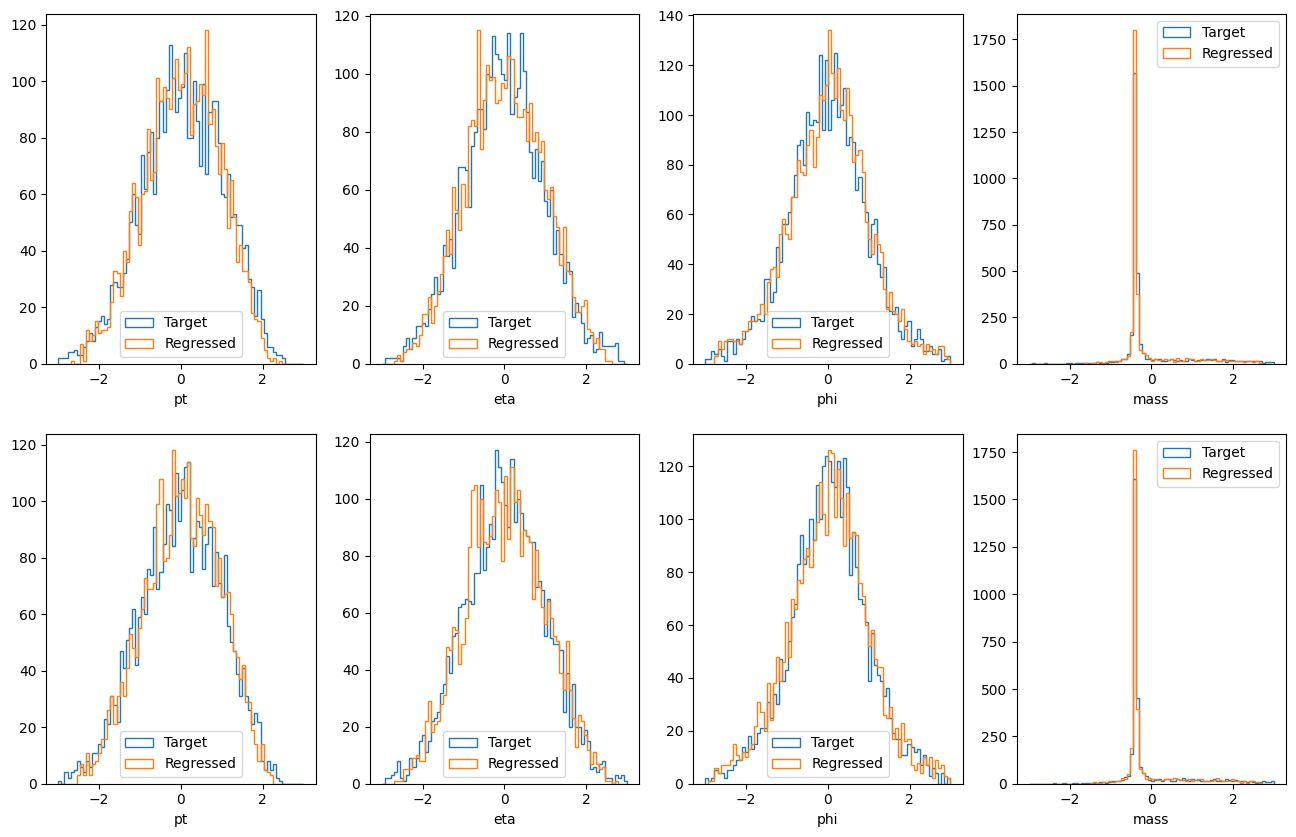

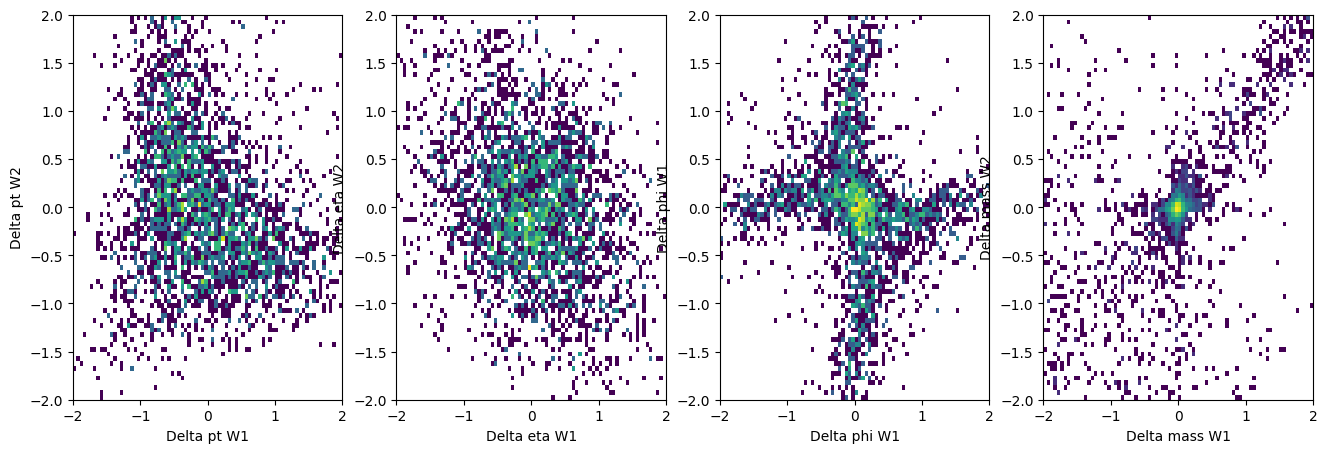

End of epoch 18
epoch 19, step 0, Loss: 2.8324, loss regr: 2.3243,  MMD total: 0.0090 
epoch 19, step 100, Loss: 2.9758, loss regr: 2.3871,  MMD total: 0.0101 
epoch 19, step 200, Loss: 2.8345, loss regr: 2.4664,  MMD total: 0.0065 


KeyboardInterrupt: 

In [54]:
max_MMD_constraint = 1e-3
scale_MMD_constraint = 20.

num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
d_model = 32
nhead = 4
num_encoder_layers = 4
num_decoder_layers = 2
learning_rate = 1e-3

model = WWRegressorComplete(d_model, nhead, num_encoder_layers, num_decoder_layers,
                   regression_net=[32])
model.to(device)

constraint = mdmm.MaxConstraint(
                    compute_MMD_loss,
                    max_MMD_constraint,
                    scale=scale_MMD_constraint,
                    damping=1.,
                    )

# Create the optimizer
MDMM_module = mdmm.MDMM([constraint]) # support many constraints TODO: use a constraint for every particle

optimizer = MDMM_module.make_optimizer(model.parameters(), lr=learning_rate, optimizer=torch.optim.AdamW)

trained_model = train_withMMD_philoss_mdmmconstraint(model, MDMM_module, device, dataloader_train, dataloader_val, optimizer, criterion, num_epochs)

In [56]:
with torch.no_grad():
    model.train()
    jets, lepton, met,full_mask, nu, W = dataset_val[0:50000]
    W_out = model(jets, lepton, met,full_mask)
    loss = criterion(W_out, W)

(<Figure size 1600x1000 with 8 Axes>,
 <Figure size 1600x1000 with 8 Axes>,
 <Figure size 1600x500 with 4 Axes>)

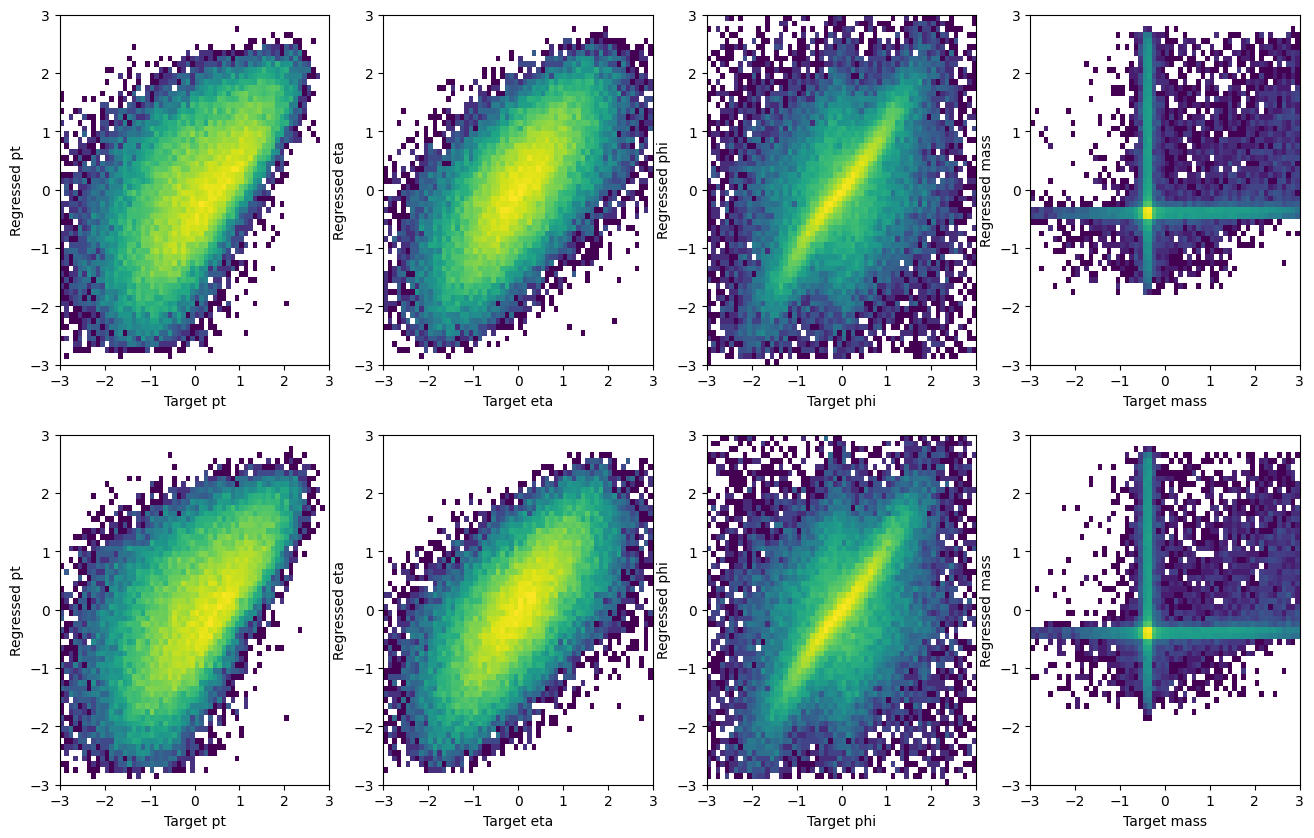

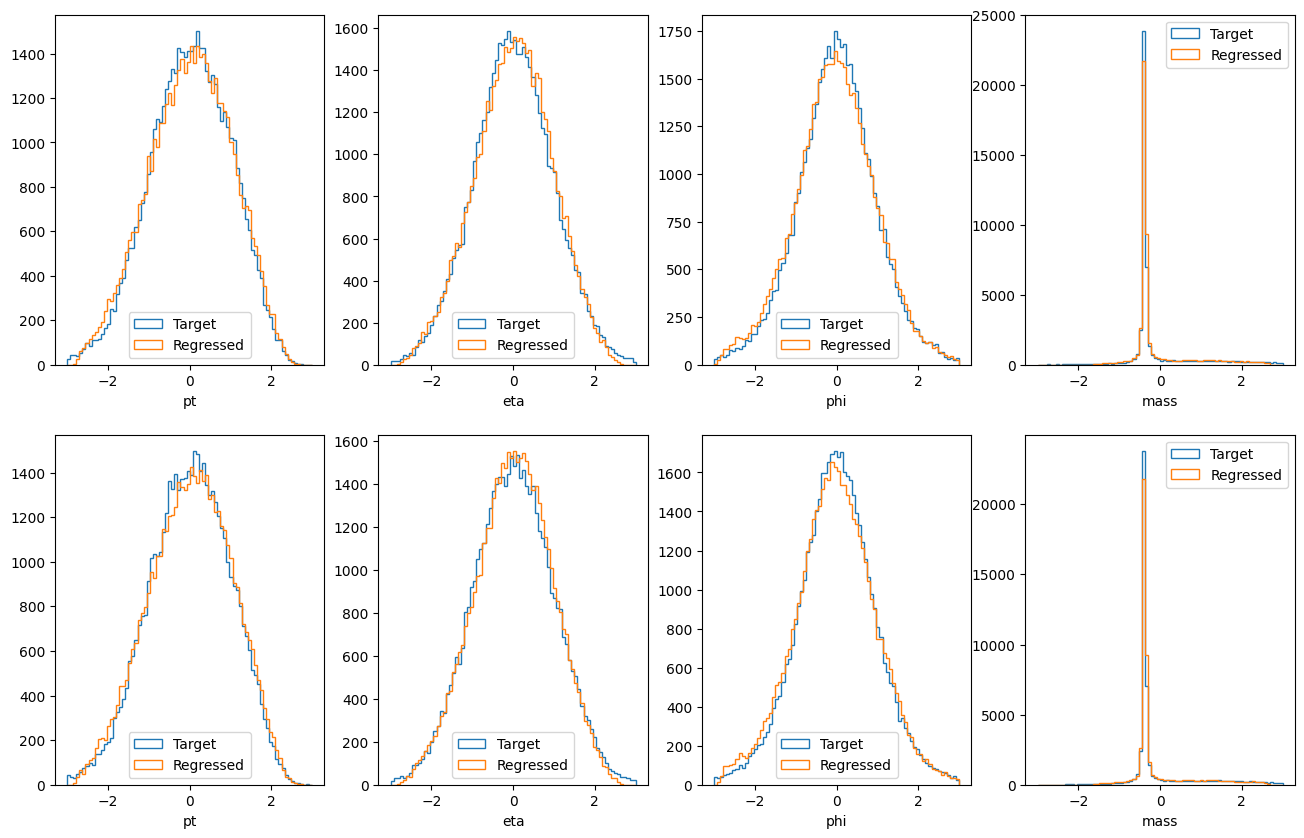

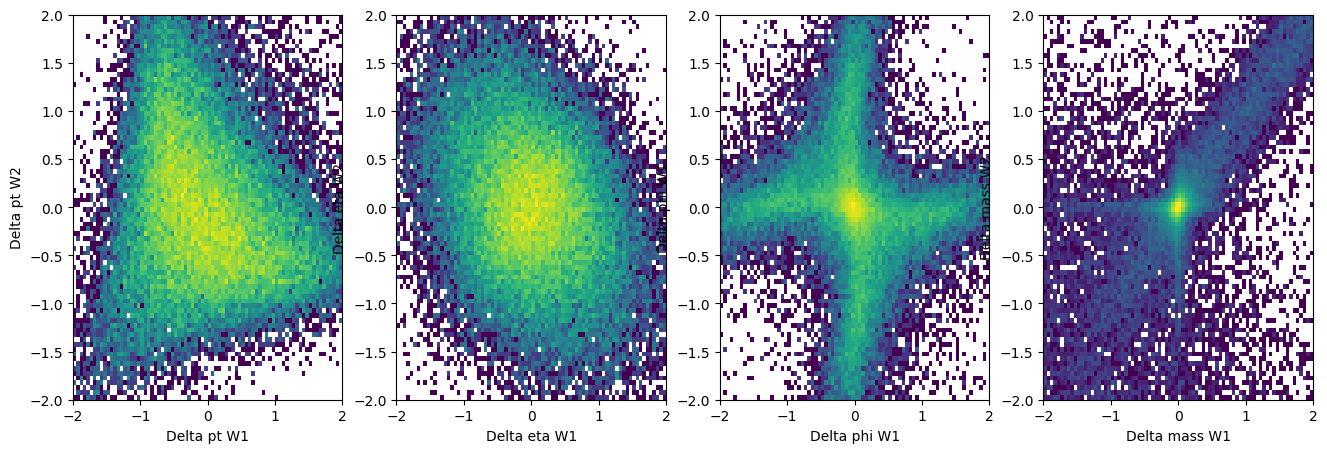

In [57]:
validation_plots(W, W_out)

In [55]:
torch.save(model.state_dict(), "models/model_WWregr_mmd_phiperiodic_MDMMconstraints.pt")

# Comparison with a very simple DNN